# 1. 라이브러리 로드

In [1]:
import warnings
import time
import glob
import gensim
import pandas as pd
import numpy as np
import logging
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer # 표제어
from nltk.corpus import stopwords # 불용어
from gensim.models import CoherenceModel # 모델 평가

# 2. 데이터 로드

In [2]:
data = pd.read_csv("C:/MyGithub/2019_Miraeassetdaewoo_Bigdata_Festival/CNN_20171006.csv", encoding='utf-8')
data.head(3)

,Unnamed: 0,KEYWORDS,SUMMARY,TEXT,TITLE,URL
0,0,"['energy', 'sugars', 'bars', 'grams', 'syrup',...","Story highlights Don't be fooled by the word ""...","Story highlights Don't be fooled by the word ""...",Are energy bars healthy?,https://www.cnn.com/2017/08/25/health/energy-b...
1,1,"['facebook', 'whats', 'world', 'unfolds', 'tam...",Chat with us in Facebook Messenger.\nFind out ...,Chat with us in Facebook Messenger. Find out w...,Tamagotchi is back,http://www.cnn.com/videos/cnnmoney/2017/10/10/...
2,2,"['jedi', 'shots', 'rey', 'force', 'wars', 'sta...","ESPN's ""Monday Night Football"" had bears, viki...","ESPN's ""Monday Night Football"" had bears, viki...",'Star Wars: The Last Jedi' trailer debuts on '...,http://money.cnn.com/2017/10/09/media/star-war...


# 3. 환경 변수 설정

In [3]:
wordnet_lemmatizer = WordNetLemmatizer() # 어근 추출
tokenizer = RegexpTokenizer(r'\w+')
STOPWORDS = set(stopwords.words('english')) # 불용어 제거
STOPWORDS.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 4. Tokenize

In [4]:
data['ALL_TEXT'] = data['TITLE'] + ' ' + data['TEXT'] # 제목과 Text 모두 이용
data

,Unnamed: 0,KEYWORDS,SUMMARY,TEXT,TITLE,URL,ALL_TEXT
0,0,"['energy', 'sugars', 'bars', 'grams', 'syrup',...","Story highlights Don't be fooled by the word ""...","Story highlights Don't be fooled by the word ""...",Are energy bars healthy?,https://www.cnn.com/2017/08/25/health/energy-b...,Are energy bars healthy? Story highlights Don'...
1,1,"['facebook', 'whats', 'world', 'unfolds', 'tam...",Chat with us in Facebook Messenger.\nFind out ...,Chat with us in Facebook Messenger. Find out w...,Tamagotchi is back,http://www.cnn.com/videos/cnnmoney/2017/10/10/...,Tamagotchi is back Chat with us in Facebook Me...
2,2,"['jedi', 'shots', 'rey', 'force', 'wars', 'sta...","ESPN's ""Monday Night Football"" had bears, viki...","ESPN's ""Monday Night Football"" had bears, viki...",'Star Wars: The Last Jedi' trailer debuts on '...,http://money.cnn.com/2017/10/09/media/star-war...,'Star Wars: The Last Jedi' trailer debuts on '...
3,3,"['clients', 'art', 'science', 'scent', 'collid...","Lyn Harris' independent space, Perfumer H , in...","This feature is part of ' Details ,' a new ser...",Art and science collide in this one-of-a-kind ...,https://www.cnn.com/style/article/details-perf...,Art and science collide in this one-of-a-kind ...
4,4,"['akufoaddo', 'tanker', 'incidents', 'dozens',...",(CNN) A tanker exploded near a gas station in ...,(CNN) A tanker exploded near a gas station in ...,"Seven killed, dozens injured in Ghana tanker e...",https://www.cnn.com/2017/10/08/africa/ghana-ta...,"Seven killed, dozens injured in Ghana tanker e..."
5,5,"['spanish', 'independence', 'regions', 'meets'...","Carles Puigdemont, the President of Catalonia,...",(CNN) Pro-independence Catalans gathered on th...,Catalans' future on line as parliament meets,https://www.cnn.com/2017/10/10/europe/cataloni...,Catalans' future on line as parliament meets (...
6,6,"['press', 'excuse', 'secretary', 'trump', 'hou...","""I think it's fake news, but if he did that, I...",(CNN) In a Forbes magazine interview published...,The Trump White House's 'joke' excuse,http://www.cnn.com/2017/10/10/politics/trump-j...,The Trump White House's 'joke' excuse (CNN) In...
7,7,"['pollution', 'repeal', 'kellogg', 'asthma', '...",President Barak Obama shakes Camryn Kellogg's ...,(CNN) The days when all three of her children ...,Health impact of Trump environmental repeal,https://www.cnn.com/2017/10/10/health/health-e...,Health impact of Trump environmental repeal (C...
8,8,"['look', 'response', 'force', 'trump', 'tour',...",(CNN) Finally lumbering into a devastated Puer...,"Michael D'Antonio is the author of the book "" ...",Trump in Puerto Rico: A narcissist's tour de f...,https://www.cnn.com/2017/10/03/opinions/trump-...,Trump in Puerto Rico: A narcissist's tour de f...
9,9,"['okunoin', 'tohoku', 'japan', 'risshakuji', '...","(CNN) — Upon hearing I would have to climb 1,0...",\n\n\n\nThis article was first published in Ju...,"Yamadera Risshakuji in Tohoku: 1,015 steps to ...",https://www.cnn.com/travel/article/yamadera-te...,"Yamadera Risshakuji in Tohoku: 1,015 steps to ..."


In [5]:
def data_token(x):
    alltext = data.loc[x:x, 'ALL_TEXT'].tolist() * 5 # 리스트로 만들기
    # alltext를 5배, 10배.. 변경시켜도 output에 변화가 있다.
    # alltext가 키워드 추출하기에 너무 적은 단어 수로 구성되어 있을 경우, 5배를 해 주는게 효과적이다.
    alltext = [[wordnet_lemmatizer.lemmatize(z) for z in tokenizer.tokenize(str(t).lower()) if z not in STOPWORDS] for t in alltext] # 불용어 제거
    return alltext

alltext = data_token(0)
print(alltext)

[['energy', 'bar', 'healthy', 'story', 'highlight', 'fooled', 'word', 'energy', 'energy', 'bar', 'contain', 'much', 'saturated', 'fat', 'snicker', 'bar', 'cnn', 'energy', 'bar', 'convenient', 'source', 'nutrition', 'come', 'wide', 'variety', 'flavor', 'satisfy', 'different', 'palate', 'often', 'fortified', 'vitamin', 'mineral', 'help', 'fill', 'nutritional', 'gap', 'like', 'many', 'food', 'specific', 'category', 'energy', 'bar', 'created', 'equal', 'low', 'saturated', 'fat', 'sugar', 'decent', 'amount', 'protein', 'fiber', 'provide', 'nutritious', 'satisfying', 'pick', 'others', 'closely', 'mimic', 'candy', 'bar', 'example', 'bar', 'covered', 'chocolate', 'contain', 'much', 'saturated', 'fat', 'snicker', 'bar', 'others', 'contain', 'almost', 'much', 'sugar', 'granola', 'bar', 'convenient', 'source', 'nutrition', 'vary', 'significantly', 'term', 'nutrition', 'energy', 'bar', 'containing', 'mostly', 'fruit', 'nut', 'serve', 'satisfying', 'snack', 'looking', 'meal', 'replacement', 'aim', 

In [6]:
# 한 번만 등장하는 단어 제거
def remove_once(alltext) :
    frequency = defaultdict(int)
    for text in alltext:
        for token in text:
            if not token.isdigit():
                frequency[token] += 1
    alltext = [[token for token in text if frequency[token] > 1] for text in alltext]
    return alltext

alltext = remove_once(alltext)
print(alltext)

[['energy', 'bar', 'healthy', 'story', 'highlight', 'fooled', 'word', 'energy', 'energy', 'bar', 'contain', 'much', 'saturated', 'fat', 'snicker', 'bar', 'cnn', 'energy', 'bar', 'convenient', 'source', 'nutrition', 'come', 'wide', 'variety', 'flavor', 'satisfy', 'different', 'palate', 'often', 'fortified', 'vitamin', 'mineral', 'help', 'fill', 'nutritional', 'gap', 'like', 'many', 'food', 'specific', 'category', 'energy', 'bar', 'created', 'equal', 'low', 'saturated', 'fat', 'sugar', 'decent', 'amount', 'protein', 'fiber', 'provide', 'nutritious', 'satisfying', 'pick', 'others', 'closely', 'mimic', 'candy', 'bar', 'example', 'bar', 'covered', 'chocolate', 'contain', 'much', 'saturated', 'fat', 'snicker', 'bar', 'others', 'contain', 'almost', 'much', 'sugar', 'granola', 'bar', 'convenient', 'source', 'nutrition', 'vary', 'significantly', 'term', 'nutrition', 'energy', 'bar', 'containing', 'mostly', 'fruit', 'nut', 'serve', 'satisfying', 'snack', 'looking', 'meal', 'replacement', 'aim', 

In [7]:
def gensim_dict(alltext):
    dictionary = gensim.corpora.Dictionary(alltext)
    return dictionary

dictionary = gensim_dict(alltext)
print(dictionary)

2019-10-29 00:37:13,784 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:13,792 : INFO : built Dictionary(111 unique tokens: ['replacement', 'energy', 'watch', 'come', 'satisfying']...) from 5 documents (total 845 corpus positions)


Dictionary(111 unique tokens: ['replacement', 'energy', 'watch', 'come', 'satisfying']...)


In [8]:
def corpus_text(dictionary, alltext):
    corpus = [dictionary.doc2bow(text) for text in alltext]
    return corpus

corpus = corpus_text(dictionary, alltext)

# 5. LDA 최선의 하이퍼 파라미터 찾기 - Pass

In [9]:
warnings.filterwarnings('ignore')

# 실험값 담을 곳
find_coherence=[]
find_perplexity=[]
find_pass=[]

for i in range(10): # 10회 실험
    t_Num_topic = 10 # 토픽 갯수
    
    # 실험에서 pass는 5씩 커지게 설정
    if i==0:
        p=1
    else:
        p=i*5
            
    # 실험
    find_lda = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=t_Num_topic, passes=p) # p 값에 따라 실험하기
    
    # 실험값 담기 - Pass
    print('Epoch', p)
    find_pass.append(p)
    
    # 실험값 담기 - Coherence
    t_cm = CoherenceModel(model=find_lda, corpus=corpus, coherence='u_mass')
    t_coherence = t_cm.get_coherence()
    print('Coherence', t_coherence)
    find_coherence.append(t_coherence)
    
    # 실험값 담기 - perplexity
    print('Perplexity', find_lda.log_perplexity(corpus),'\n')
    find_perplexity.append(find_lda.log_perplexity(corpus))

2019-10-29 00:37:14,122 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:14,125 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:14,127 : INFO : using serial LDA version on this node
2019-10-29 00:37:14,131 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:14,133 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:14,229 : INFO : -6.803 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:14,232 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:14,299 : INFO : topic #5 (0.100): 0.012*"bar" + 0.011*"energy" + 0.010*"saturated" + 0.010*"fat" + 0.010*"sugar" + 0.010*"others" + 0.010*"higher" + 0.010

Epoch 1
Coherence 1.0000889005818406e-12


2019-10-29 00:37:14,624 : INFO : -5.678 per-word bound, 51.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words


Perplexity -5.67769354504241 



2019-10-29 00:37:14,841 : INFO : -5.676 per-word bound, 51.1 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:14,850 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:14,854 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:14,857 : INFO : using serial LDA version on this node
2019-10-29 00:37:14,867 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:14,869 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:14,964 : INFO : -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:14,966 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:14,999 : INFO : t

Epoch 5
Coherence 1.0000889005818406e-12
Perplexity -4.862789062141667 



2019-10-29 00:37:15,617 : INFO : -6.790 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:15,620 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:15,658 : INFO : topic #4 (0.100): 0.098*"bar" + 0.030*"fat" + 0.021*"others" + 0.020*"nutrition" + 0.020*"saturated" + 0.019*"energy" + 0.018*"chocolate" + 0.017*"higher" + 0.017*"protein" + 0.017*"gram"
2019-10-29 00:37:15,660 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"fat" + 0.009*"energy" + 0.009*"protein" + 0.009*"higher" + 0.009*"gram" + 0.009*"contain" + 0.009*"sugar" + 0.009*"nutrition"
2019-10-29 00:37:15,662 : INFO : topic #7 (0.100): 0.044*"bar" + 0.025*"energy" + 0.025*"fat" + 0.021*"saturated" + 0.017*"higher" + 0.016*"gram" + 0.016*"protein" + 0.016*"contain" + 0.015*"nutrition" + 0.015*"others"
2019-10-29 00:37:15,664 : INFO : topic #6 (0.100): 0.063*"bar" + 0.027*"saturated" + 0.023*"fat" + 0.022*"energy" + 0.022*"contain" + 0

2019-10-29 00:37:16,324 : INFO : -4.843 per-word bound, 28.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:16,353 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:16,368 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"fat" + 0.009*"energy" + 0.009*"higher" + 0.009*"protein" + 0.009*"gram" + 0.009*"sugar" + 0.009*"contain" + 0.009*"snack"
2019-10-29 00:37:16,380 : INFO : topic #3 (0.100): 0.027*"bar" + 0.014*"energy" + 0.013*"saturated" + 0.012*"gram" + 0.012*"fat" + 0.011*"others" + 0.011*"sugar" + 0.011*"contain" + 0.010*"protein" + 0.010*"snack"
2019-10-29 00:37:16,383 : INFO : topic #9 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"saturated" + 0.029*"fat" + 0.018*"much" + 0.018*"others" + 0.018*"sugar" + 0.018*"nutrition" + 0.018*"contain" + 0.018*"protein"
2019-10-29 00:37:16,392 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"higher" + 0.009*"contain"

Epoch 10
Coherence 1.0000889005818406e-12
Perplexity -4.819665212744087 



2019-10-29 00:37:16,947 : INFO : -4.820 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:16,950 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:16,954 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:16,958 : INFO : using serial LDA version on this node
2019-10-29 00:37:16,962 : INFO : running online (multi-pass) LDA training, 10 topics, 15 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:17,054 : INFO : -6.796 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:17,057 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:17,105 : INFO : topic #9 (0.100): 0.096*"bar" + 0.031*"energy" + 0.022*"fat" + 0.021*"sugar" + 0.021*"saturated" + 0.020*"gram" + 0.019*"contain" + 0.019*"protein" + 0.018*"

2019-10-29 00:37:17,696 : INFO : topic #3 (0.100): 0.093*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"higher" + 0.018*"protein" + 0.018*"others" + 0.018*"nutrition" + 0.018*"gram" + 0.018*"contain"
2019-10-29 00:37:17,704 : INFO : topic diff=0.415558, rho=0.377964
2019-10-29 00:37:17,773 : INFO : -4.852 per-word bound, 28.9 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:17,777 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:17,786 : INFO : topic #8 (0.100): 0.036*"bar" + 0.018*"energy" + 0.016*"saturated" + 0.015*"fat" + 0.012*"much" + 0.012*"nutrition" + 0.012*"sugar" + 0.012*"contain" + 0.012*"higher" + 0.011*"syrup"
2019-10-29 00:37:17,789 : INFO : topic #7 (0.100): 0.014*"bar" + 0.011*"energy" + 0.011*"saturated" + 0.010*"much" + 0.010*"fat" + 0.010*"gram" + 0.010*"sugar" + 0.010*"protein" + 0.010*"others" + 0.010*"meal"
2019-10-29 00:37:17,792 : INFO : topic #1 (0.100): 0.009*"bar" + 0.009*"energy" + 

2019-10-29 00:37:18,153 : INFO : topic diff=0.062565, rho=0.277350
2019-10-29 00:37:18,209 : INFO : -4.818 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:18,211 : INFO : PROGRESS: pass 12, at document #5/5
2019-10-29 00:37:18,218 : INFO : topic #9 (0.100): 0.013*"bar" + 0.010*"energy" + 0.010*"fat" + 0.010*"sugar" + 0.010*"saturated" + 0.009*"gram" + 0.009*"contain" + 0.009*"protein" + 0.009*"much" + 0.009*"others"
2019-10-29 00:37:18,220 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"protein" + 0.009*"fat" + 0.009*"contain" + 0.009*"gram" + 0.009*"higher" + 0.009*"much" + 0.009*"aim"
2019-10-29 00:37:18,223 : INFO : topic #4 (0.100): 0.012*"bar" + 0.010*"saturated" + 0.010*"energy" + 0.010*"fat" + 0.009*"contain" + 0.009*"others" + 0.009*"much" + 0.009*"nutrition" + 0.009*"protein" + 0.009*"higher"
2019-10-29 00:37:18,225 : INFO : topic #7 (0.100): 0.010*"bar" + 0.009*"energy" + 0

Epoch 15
Coherence 1.0000889005818406e-12
Perplexity -4.817499524037514 



2019-10-29 00:37:18,637 : INFO : -6.794 per-word bound, 111.0 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:18,638 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:18,679 : INFO : topic #8 (0.100): 0.055*"bar" + 0.028*"energy" + 0.022*"saturated" + 0.019*"fat" + 0.019*"protein" + 0.017*"higher" + 0.014*"much" + 0.014*"others" + 0.014*"contain" + 0.013*"gram"
2019-10-29 00:37:18,681 : INFO : topic #1 (0.100): 0.062*"bar" + 0.024*"energy" + 0.021*"saturated" + 0.020*"fat" + 0.018*"others" + 0.018*"much" + 0.016*"higher" + 0.015*"snicker" + 0.014*"contain" + 0.014*"sugar"
2019-10-29 00:37:18,683 : INFO : topic #4 (0.100): 0.031*"bar" + 0.019*"energy" + 0.016*"saturated" + 0.015*"fat" + 0.014*"sugar" + 0.012*"contain" + 0.012*"others" + 0.012*"much" + 0.012*"protein" + 0.011*"calorie"
2019-10-29 00:37:18,685 : INFO : topic #2 (0.100): 0.088*"bar" + 0.037*"energy" + 0.035*"saturated" + 0.025*"fat" + 0.021*"higher" + 0.019*"gram" + 

2019-10-29 00:37:19,253 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:19,262 : INFO : topic #7 (0.100): 0.051*"bar" + 0.021*"saturated" + 0.020*"fat" + 0.016*"energy" + 0.015*"sugar" + 0.015*"others" + 0.014*"contain" + 0.014*"nutrition" + 0.014*"snack" + 0.013*"protein"
2019-10-29 00:37:19,264 : INFO : topic #5 (0.100): 0.016*"bar" + 0.011*"energy" + 0.011*"saturated" + 0.010*"fat" + 0.010*"contain" + 0.010*"much" + 0.010*"others" + 0.010*"protein" + 0.010*"sugar" + 0.010*"gram"
2019-10-29 00:37:19,267 : INFO : topic #3 (0.100): 0.020*"bar" + 0.013*"energy" + 0.011*"saturated" + 0.011*"fat" + 0.011*"nutrition" + 0.010*"much" + 0.010*"contain" + 0.010*"syrup" + 0.010*"sugar" + 0.010*"meal"
2019-10-29 00:37:19,268 : INFO : topic #0 (0.100): 0.015*"bar" + 0.012*"energy" + 0.012*"saturated" + 0.011*"fat" + 0.010*"contain" + 0.010*"protein" + 0.010*"others" + 0.010*"meal" + 0.010*"much" + 0.010*"also"
2019-10-29 00:37:19,270 : INFO : topic #4 (0.100): 0.010*"bar" + 0.009*"en

2019-10-29 00:37:19,722 : INFO : topic #2 (0.100): 0.013*"bar" + 0.011*"energy" + 0.010*"saturated" + 0.010*"fat" + 0.010*"higher" + 0.010*"gram" + 0.010*"much" + 0.010*"nutrition" + 0.009*"others" + 0.009*"protein"
2019-10-29 00:37:19,724 : INFO : topic #1 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"others" + 0.009*"much" + 0.009*"higher" + 0.009*"snicker" + 0.009*"contain" + 0.009*"sugar"
2019-10-29 00:37:19,726 : INFO : topic #9 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"gram" + 0.018*"protein" + 0.018*"higher" + 0.018*"much" + 0.018*"contain" + 0.018*"nutrition"
2019-10-29 00:37:19,728 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"fat" + 0.009*"gap" + 0.009*"snack" + 0.009*"generally" + 0.009*"satisfying" + 0.009*"fill"
2019-10-29 00:37:19,730 : INFO : topic diff=0.057220, rho=0.267261
2019-10-29 00:37:19,783 : INFO : -4.819 per-word bound, 28.2 perplexit

2019-10-29 00:37:20,419 : INFO : topic #2 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"higher" + 0.009*"gram" + 0.009*"much" + 0.009*"nutrition" + 0.009*"others" + 0.009*"protein"
2019-10-29 00:37:20,426 : INFO : topic #3 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"nutrition" + 0.009*"much" + 0.009*"contain" + 0.009*"syrup" + 0.009*"sugar" + 0.009*"meal"
2019-10-29 00:37:20,430 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"contain" + 0.009*"much" + 0.009*"others" + 0.009*"protein" + 0.009*"sugar" + 0.009*"gram"
2019-10-29 00:37:20,433 : INFO : topic diff=0.010558, rho=0.223607
2019-10-29 00:37:20,476 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:20,479 : INFO : PROGRESS: pass 19, at document #5/5
2019-10-29 00:37:20,485 : INFO : topic #1 (0.100): 0.009*"bar" + 0.009*"energy" + 0

Epoch 20
Coherence 1.0000889005818406e-12
Perplexity -4.817324998675013 



2019-10-29 00:37:20,702 : INFO : -6.823 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:20,703 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:20,744 : INFO : topic #7 (0.100): 0.080*"bar" + 0.031*"energy" + 0.028*"saturated" + 0.025*"fat" + 0.022*"protein" + 0.020*"higher" + 0.017*"gram" + 0.017*"contain" + 0.017*"much" + 0.015*"convenient"
2019-10-29 00:37:20,746 : INFO : topic #3 (0.100): 0.096*"bar" + 0.041*"energy" + 0.030*"fat" + 0.027*"saturated" + 0.019*"much" + 0.019*"protein" + 0.017*"nutrition" + 0.017*"others" + 0.017*"sugar" + 0.015*"higher"
2019-10-29 00:37:20,748 : INFO : topic #9 (0.100): 0.080*"bar" + 0.035*"saturated" + 0.030*"fat" + 0.024*"energy" + 0.019*"others" + 0.018*"contain" + 0.017*"sugar" + 0.017*"much" + 0.016*"gram" + 0.015*"aim"
2019-10-29 00:37:20,750 : INFO : topic #5 (0.100): 0.080*"bar" + 0.031*"saturated" + 0.028*"energy" + 0.023*"fat" + 0.021*"contain" + 0.018*"gram" + 

2019-10-29 00:37:21,257 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:21,266 : INFO : topic #0 (0.100): 0.020*"bar" + 0.012*"energy" + 0.012*"fat" + 0.012*"saturated" + 0.011*"contain" + 0.011*"much" + 0.010*"convenient" + 0.010*"nutrition" + 0.010*"gram" + 0.010*"others"
2019-10-29 00:37:21,268 : INFO : topic #3 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"much" + 0.018*"protein" + 0.018*"nutrition" + 0.018*"others" + 0.018*"sugar" + 0.018*"higher"
2019-10-29 00:37:21,270 : INFO : topic #1 (0.100): 0.020*"bar" + 0.013*"energy" + 0.012*"fat" + 0.012*"saturated" + 0.011*"nutrition" + 0.011*"higher" + 0.010*"others" + 0.010*"gram" + 0.010*"sugar" + 0.010*"much"
2019-10-29 00:37:21,274 : INFO : topic #2 (0.100): 0.015*"bar" + 0.011*"saturated" + 0.011*"energy" + 0.011*"fat" + 0.010*"others" + 0.010*"higher" + 0.010*"nutrition" + 0.010*"sugar" + 0.010*"protein" + 0.010*"athlete"
2019-10-29 00:37:21,276 : INFO : topic #4 (0.100): 0.035*"bar

2019-10-29 00:37:21,780 : INFO : topic #0 (0.100): 0.011*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"contain" + 0.009*"much" + 0.009*"convenient" + 0.009*"nutrition" + 0.009*"gram" + 0.009*"others"
2019-10-29 00:37:21,783 : INFO : topic #1 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"others" + 0.009*"gram" + 0.009*"sugar" + 0.009*"much"
2019-10-29 00:37:21,787 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"saturated" + 0.009*"gram" + 0.009*"chocolate" + 0.009*"syrup" + 0.009*"higher" + 0.009*"sugar" + 0.009*"others" + 0.009*"satisfying"
2019-10-29 00:37:21,790 : INFO : topic #5 (0.100): 0.011*"bar" + 0.010*"saturated" + 0.010*"energy" + 0.009*"fat" + 0.009*"contain" + 0.009*"gram" + 0.009*"higher" + 0.009*"others" + 0.009*"nutrition" + 0.009*"protein"
2019-10-29 00:37:21,793 : INFO : topic #7 (0.100): 0.011*"bar" + 0.010*"energy" + 0.010*"saturated" + 0.009*"fat" + 0.009*"prote

2019-10-29 00:37:22,313 : INFO : topic #4 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"gram" + 0.009*"sugar" + 0.009*"contain" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"protein"
2019-10-29 00:37:22,316 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"others" + 0.009*"higher" + 0.009*"energy" + 0.009*"much" + 0.009*"protein" + 0.009*"gram" + 0.009*"nutrition" + 0.009*"fat"
2019-10-29 00:37:22,319 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"contain" + 0.009*"gram" + 0.009*"higher" + 0.009*"others" + 0.009*"nutrition" + 0.009*"protein"
2019-10-29 00:37:22,323 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"others" + 0.009*"higher" + 0.009*"nutrition" + 0.009*"sugar" + 0.009*"protein" + 0.009*"athlete"
2019-10-29 00:37:22,326 : INFO : topic diff=0.008714, rho=0.223607
2019-10-29 00:37:22,392 : INFO : -4.817 per-word bound, 28.2

2019-10-29 00:37:22,897 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"palate" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"others" + 0.009*"nutrition" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:22,900 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"contain" + 0.009*"much" + 0.009*"convenient" + 0.009*"nutrition" + 0.009*"gram" + 0.009*"others"
2019-10-29 00:37:22,903 : INFO : topic #1 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"others" + 0.009*"gram" + 0.009*"sugar" + 0.009*"much"
2019-10-29 00:37:22,904 : INFO : topic diff=0.001876, rho=0.196116
2019-10-29 00:37:23,030 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words


Epoch 25
Coherence 1.0000889005818406e-12
Perplexity -4.817281461749556 



2019-10-29 00:37:23,125 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:23,128 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:23,130 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:23,133 : INFO : using serial LDA version on this node
2019-10-29 00:37:23,136 : INFO : running online (multi-pass) LDA training, 10 topics, 30 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:23,264 : INFO : -6.786 per-word bound, 110.4 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:23,267 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:23,317 : INFO : topic #4 (0.100): 0.094*"bar" + 0.036*"energy" + 0.029*"saturated" + 0.026*"fat" + 0.020*"nutrition" + 0.019*"much" + 0.019*"protein" + 0.017*"sugar" + 0.017

2019-10-29 00:37:23,886 : INFO : topic #4 (0.100): 0.046*"bar" + 0.021*"energy" + 0.018*"saturated" + 0.016*"fat" + 0.014*"nutrition" + 0.013*"much" + 0.013*"protein" + 0.013*"sugar" + 0.012*"higher" + 0.012*"fiber"
2019-10-29 00:37:23,889 : INFO : topic #9 (0.100): 0.014*"bar" + 0.011*"energy" + 0.011*"saturated" + 0.011*"fat" + 0.010*"nutrition" + 0.010*"contain" + 0.010*"calorie" + 0.010*"others" + 0.010*"gram" + 0.010*"sugar"
2019-10-29 00:37:23,891 : INFO : topic diff=0.400681, rho=0.377964
2019-10-29 00:37:23,943 : INFO : -4.854 per-word bound, 28.9 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:23,949 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:23,957 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"contain" + 0.009*"sugar" + 0.009*"protein" + 0.009*"much" + 0.009*"chocolate" + 0.009*"others"
2019-10-29 00:37:23,963 : INFO : topic #4 (0.100): 0.037*"bar" + 0.018*"ene

2019-10-29 00:37:24,355 : INFO : topic #1 (0.100): 0.013*"bar" + 0.010*"energy" + 0.010*"fat" + 0.010*"saturated" + 0.010*"others" + 0.010*"gram" + 0.010*"higher" + 0.009*"nutrition" + 0.009*"contain" + 0.009*"protein"
2019-10-29 00:37:24,357 : INFO : topic diff=0.064339, rho=0.277350
2019-10-29 00:37:24,400 : INFO : -4.818 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:24,401 : INFO : PROGRESS: pass 12, at document #5/5
2019-10-29 00:37:24,408 : INFO : topic #3 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"much" + 0.018*"gram" + 0.018*"contain" + 0.018*"sugar" + 0.018*"others" + 0.018*"higher"
2019-10-29 00:37:24,410 : INFO : topic #4 (0.100): 0.014*"bar" + 0.010*"energy" + 0.010*"saturated" + 0.010*"fat" + 0.010*"nutrition" + 0.010*"much" + 0.010*"protein" + 0.009*"sugar" + 0.009*"higher" + 0.009*"fiber"
2019-10-29 00:37:24,414 : INFO : topic #8 (0.100): 0.013*"bar" + 0.010*"saturat

2019-10-29 00:37:24,819 : INFO : topic diff=0.010714, rho=0.229416
2019-10-29 00:37:24,894 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:24,899 : INFO : PROGRESS: pass 18, at document #5/5
2019-10-29 00:37:24,910 : INFO : topic #4 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"nutrition" + 0.009*"much" + 0.009*"protein" + 0.009*"sugar" + 0.009*"higher" + 0.009*"fiber"
2019-10-29 00:37:24,914 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"nutrition" + 0.009*"saturated" + 0.009*"others" + 0.009*"contain" + 0.009*"protein" + 0.009*"much" + 0.009*"higher"
2019-10-29 00:37:24,917 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"contain" + 0.009*"sugar" + 0.009*"protein" + 0.009*"much" + 0.009*"chocolate" + 0.009*"others"
2019-10-29 00:37:24,920 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"e

2019-10-29 00:37:25,375 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:25,382 : INFO : PROGRESS: pass 24, at document #5/5
2019-10-29 00:37:25,391 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"nutrition" + 0.009*"much" + 0.009*"protein" + 0.009*"sugar" + 0.009*"higher" + 0.009*"fiber"
2019-10-29 00:37:25,393 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"nutrition" + 0.009*"saturated" + 0.009*"others" + 0.009*"contain" + 0.009*"protein" + 0.009*"much" + 0.009*"higher"
2019-10-29 00:37:25,396 : INFO : topic #0 (0.100): 0.009*"others" + 0.009*"palate" + 0.009*"nutritional" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"nut" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:25,401 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"gram" + 0.009*"pr

Epoch 30
Coherence 1.0000889005818406e-12
Perplexity -4.817278531810941 



2019-10-29 00:37:26,030 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:26,034 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:26,036 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:26,038 : INFO : using serial LDA version on this node
2019-10-29 00:37:26,041 : INFO : running online (multi-pass) LDA training, 10 topics, 35 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:26,185 : INFO : -6.802 per-word bound, 111.6 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:26,187 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:26,223 : INFO : topic #9 (0.100): 0.074*"bar" + 0.039*"energy" + 0.032*"fat" + 0.024*"saturated" + 0.023*"gram" + 0.020*"contain" + 0.020*"protein" + 0.018*"nutrition" + 0.0

2019-10-29 00:37:26,836 : INFO : topic #6 (0.100): 0.093*"bar" + 0.035*"energy" + 0.029*"saturated" + 0.029*"fat" + 0.018*"contain" + 0.018*"others" + 0.018*"higher" + 0.018*"nutrition" + 0.018*"much" + 0.018*"gram"
2019-10-29 00:37:26,839 : INFO : topic #3 (0.100): 0.073*"bar" + 0.027*"energy" + 0.026*"fat" + 0.025*"saturated" + 0.019*"protein" + 0.019*"sugar" + 0.016*"nutrition" + 0.016*"much" + 0.016*"gram" + 0.014*"higher"
2019-10-29 00:37:26,841 : INFO : topic diff=0.425022, rho=0.377964
2019-10-29 00:37:26,911 : INFO : -4.903 per-word bound, 29.9 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:26,914 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:26,931 : INFO : topic #3 (0.100): 0.065*"bar" + 0.025*"energy" + 0.024*"fat" + 0.023*"saturated" + 0.018*"protein" + 0.018*"sugar" + 0.015*"nutrition" + 0.015*"much" + 0.015*"gram" + 0.013*"higher"
2019-10-29 00:37:26,946 : INFO : topic #6 (0.100): 0.093*"bar" + 0.035*"energy" +

2019-10-29 00:37:27,398 : INFO : topic #6 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"saturated" + 0.029*"fat" + 0.018*"contain" + 0.018*"others" + 0.018*"higher" + 0.018*"nutrition" + 0.018*"much" + 0.018*"gram"
2019-10-29 00:37:27,405 : INFO : topic diff=0.099137, rho=0.277350
2019-10-29 00:37:27,474 : INFO : -4.822 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:27,477 : INFO : PROGRESS: pass 12, at document #5/5
2019-10-29 00:37:27,491 : INFO : topic #3 (0.100): 0.025*"bar" + 0.013*"energy" + 0.013*"fat" + 0.013*"saturated" + 0.011*"protein" + 0.011*"sugar" + 0.011*"nutrition" + 0.011*"much" + 0.011*"gram" + 0.010*"higher"
2019-10-29 00:37:27,494 : INFO : topic #9 (0.100): 0.011*"bar" + 0.010*"energy" + 0.010*"fat" + 0.010*"saturated" + 0.010*"gram" + 0.009*"contain" + 0.009*"protein" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"sugar"
2019-10-29 00:37:27,497 : INFO : topic #1 (0.100): 0.014*"bar" + 0.010*"energ

2019-10-29 00:37:27,975 : INFO : topic diff=0.020214, rho=0.229416
2019-10-29 00:37:28,041 : INFO : -4.818 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:28,049 : INFO : PROGRESS: pass 18, at document #5/5
2019-10-29 00:37:28,064 : INFO : topic #1 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"much" + 0.009*"contain" + 0.009*"others" + 0.009*"higher" + 0.009*"gram" + 0.009*"chocolate"
2019-10-29 00:37:28,067 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"much" + 0.009*"gram" + 0.009*"others" + 0.009*"contain" + 0.009*"sugar" + 0.009*"nutrition"
2019-10-29 00:37:28,071 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"palate" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"others" + 0.009*"nutrition" + 0.009*"protein" + 0.009*"pick"
2019-10-29 00:37:28,074 : INFO : topic #6 (0.100): 0.094*"bar" + 0.035*"energ

2019-10-29 00:37:28,679 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:28,680 : INFO : PROGRESS: pass 24, at document #5/5
2019-10-29 00:37:28,690 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"much" + 0.009*"contain" + 0.009*"fat" + 0.009*"sugar" + 0.009*"nutrition" + 0.009*"protein"
2019-10-29 00:37:28,696 : INFO : topic #9 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"gram" + 0.009*"contain" + 0.009*"protein" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"sugar"
2019-10-29 00:37:28,699 : INFO : topic #1 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"much" + 0.009*"contain" + 0.009*"others" + 0.009*"higher" + 0.009*"gram" + 0.009*"chocolate"
2019-10-29 00:37:28,702 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"gram" + 0.009*"much"

2019-10-29 00:37:29,223 : INFO : PROGRESS: pass 30, at document #5/5
2019-10-29 00:37:29,230 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"others" + 0.009*"nutrition" + 0.009*"gram" + 0.009*"sugar" + 0.009*"higher" + 0.009*"much"
2019-10-29 00:37:29,233 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"much" + 0.009*"gram" + 0.009*"others" + 0.009*"contain" + 0.009*"sugar" + 0.009*"nutrition"
2019-10-29 00:37:29,234 : INFO : topic #1 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"much" + 0.009*"contain" + 0.009*"others" + 0.009*"higher" + 0.009*"gram" + 0.009*"chocolate"
2019-10-29 00:37:29,240 : INFO : topic #9 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"gram" + 0.009*"contain" + 0.009*"protein" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"sugar"
2019-10-29 00:37:29,243 : INFO : topic #0 (0.100): 0.009*"bar" + 0.0

Epoch 35
Coherence 1.0000889005818406e-12
Perplexity -4.817278763810559 



2019-10-29 00:37:29,869 : INFO : -6.767 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:29,873 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:29,934 : INFO : topic #8 (0.100): 0.060*"bar" + 0.031*"energy" + 0.022*"fat" + 0.021*"saturated" + 0.019*"sugar" + 0.018*"much" + 0.016*"higher" + 0.016*"contain" + 0.014*"calorie" + 0.014*"protein"
2019-10-29 00:37:29,938 : INFO : topic #3 (0.100): 0.078*"bar" + 0.031*"energy" + 0.029*"fat" + 0.023*"saturated" + 0.018*"contain" + 0.017*"sugar" + 0.017*"much" + 0.017*"higher" + 0.016*"others" + 0.015*"protein"
2019-10-29 00:37:29,940 : INFO : topic #1 (0.100): 0.102*"bar" + 0.034*"energy" + 0.029*"fat" + 0.027*"saturated" + 0.019*"nutrition" + 0.019*"protein" + 0.019*"gram" + 0.018*"contain" + 0.018*"much" + 0.018*"others"
2019-10-29 00:37:29,942 : INFO : topic #5 (0.100): 0.031*"bar" + 0.019*"energy" + 0.017*"saturated" + 0.017*"fat" + 0.014*"higher" + 0.013*"much"

2019-10-29 00:37:30,404 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:30,415 : INFO : topic #9 (0.100): 0.021*"bar" + 0.014*"energy" + 0.014*"saturated" + 0.013*"fat" + 0.011*"nutrition" + 0.011*"others" + 0.011*"higher" + 0.010*"syrup" + 0.010*"protein" + 0.010*"gram"
2019-10-29 00:37:30,417 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"gram" + 0.009*"sugar" + 0.009*"nutrition" + 0.009*"saturated" + 0.009*"much" + 0.009*"amount" + 0.009*"contain"
2019-10-29 00:37:30,419 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"gram" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"satisfying" + 0.009*"others"
2019-10-29 00:37:30,421 : INFO : topic #3 (0.100): 0.020*"bar" + 0.012*"energy" + 0.012*"fat" + 0.011*"saturated" + 0.010*"contain" + 0.010*"sugar" + 0.010*"much" + 0.010*"higher" + 0.010*"others" + 0.010*"protein"
2019-10-29 00:37:30,425 : INFO : topic #1 (0.100): 0.094*"bar" + 0.0

2019-10-29 00:37:30,886 : INFO : topic #1 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"nutrition" + 0.018*"protein" + 0.018*"gram" + 0.018*"contain" + 0.018*"much" + 0.018*"others"
2019-10-29 00:37:30,887 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"protein" + 0.009*"nutrition" + 0.009*"much" + 0.009*"syrup" + 0.009*"sugar" + 0.009*"higher"
2019-10-29 00:37:30,889 : INFO : topic #8 (0.100): 0.010*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"sugar" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"calorie" + 0.009*"protein"
2019-10-29 00:37:30,891 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"higher" + 0.009*"much" + 0.009*"contain" + 0.009*"meal" + 0.009*"syrup" + 0.009*"protein"
2019-10-29 00:37:30,894 : INFO : topic diff=0.029480, rho=0.267261
2019-10-29 00:37:30,944 : INFO : -4.818 per-word bound, 28.2 perplexity

2019-10-29 00:37:31,387 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"sugar" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"calorie" + 0.009*"protein"
2019-10-29 00:37:31,390 : INFO : topic #3 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"contain" + 0.009*"sugar" + 0.009*"much" + 0.009*"higher" + 0.009*"others" + 0.009*"protein"
2019-10-29 00:37:31,393 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"palate" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"others" + 0.009*"nutrition" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:31,397 : INFO : topic diff=0.004849, rho=0.223607
2019-10-29 00:37:31,456 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:31,461 : INFO : PROGRESS: pass 19, at document #5/5
2019-10-29 00:37:31,470 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"energy"

2019-10-29 00:37:31,916 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"sugar" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"calorie" + 0.009*"protein"
2019-10-29 00:37:31,921 : INFO : topic #1 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"nutrition" + 0.018*"protein" + 0.018*"gram" + 0.018*"contain" + 0.018*"much" + 0.018*"others"
2019-10-29 00:37:31,926 : INFO : topic diff=0.001039, rho=0.196116
2019-10-29 00:37:32,012 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:32,025 : INFO : PROGRESS: pass 25, at document #5/5
2019-10-29 00:37:32,036 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"higher" + 0.009*"much" + 0.009*"contain" + 0.009*"meal" + 0.009*"syrup" + 0.009*"protein"
2019-10-29 00:37:32,038 : INFO : topic #3 (0.100): 0.009*"bar" + 0.009*"energy" 

2019-10-29 00:37:32,448 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"protein" + 0.009*"gram" + 0.009*"others"
2019-10-29 00:37:32,449 : INFO : topic diff=0.000270, rho=0.176777
2019-10-29 00:37:32,497 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:32,498 : INFO : PROGRESS: pass 31, at document #5/5
2019-10-29 00:37:32,506 : INFO : topic #7 (0.100): 0.009*"others" + 0.009*"palate" + 0.009*"nutritional" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"nut" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:32,508 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"protein" + 0.009*"nutrition" + 0.009*"much" + 0.009*"syrup" + 0.009*"sugar" + 0.009*"higher"
2019-10-29 00:37:32,511 : INFO : topic #1 (0.100): 0.094*"bar" + 0.035*"energy

2019-10-29 00:37:32,861 : INFO : topic diff=0.000081, rho=0.162221
2019-10-29 00:37:32,913 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:32,915 : INFO : PROGRESS: pass 37, at document #5/5
2019-10-29 00:37:32,924 : INFO : topic #2 (0.100): 0.009*"others" + 0.009*"palate" + 0.009*"nutritional" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"nut" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:32,926 : INFO : topic #8 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"saturated" + 0.009*"sugar" + 0.009*"much" + 0.009*"higher" + 0.009*"contain" + 0.009*"calorie" + 0.009*"protein"
2019-10-29 00:37:32,931 : INFO : topic #7 (0.100): 0.009*"others" + 0.009*"palate" + 0.009*"nutritional" + 0.009*"nutritious" + 0.009*"often" + 0.009*"oil" + 0.009*"nut" + 0.009*"protein" + 0.009*"pick" + 0.009*"need"
2019-10-29 00:37:32,934 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"sa

Epoch 40
Coherence 1.0000889005818406e-12
Perplexity -4.817277975195259 



2019-10-29 00:37:33,321 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:33,324 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:33,325 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:33,328 : INFO : using serial LDA version on this node
2019-10-29 00:37:33,331 : INFO : running online (multi-pass) LDA training, 10 topics, 45 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:33,417 : INFO : -6.798 per-word bound, 111.3 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:33,419 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:33,458 : INFO : topic #6 (0.100): 0.076*"bar" + 0.030*"energy" + 0.028*"saturated" + 0.021*"gram" + 0.019*"fat" + 0.016*"contain" + 0.015*"nutrition" + 0.015*"others" + 0.01

2019-10-29 00:37:33,918 : INFO : topic #6 (0.100): 0.022*"bar" + 0.013*"energy" + 0.013*"saturated" + 0.011*"gram" + 0.011*"fat" + 0.010*"contain" + 0.010*"nutrition" + 0.010*"others" + 0.010*"higher" + 0.010*"protein"
2019-10-29 00:37:33,920 : INFO : topic #3 (0.100): 0.016*"bar" + 0.011*"energy" + 0.011*"saturated" + 0.010*"fat" + 0.010*"gram" + 0.010*"higher" + 0.010*"much" + 0.010*"nutrition" + 0.010*"others" + 0.010*"protein"
2019-10-29 00:37:33,921 : INFO : topic diff=0.361996, rho=0.377964
2019-10-29 00:37:33,969 : INFO : -4.838 per-word bound, 28.6 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:33,970 : INFO : PROGRESS: pass 6, at document #5/5
2019-10-29 00:37:33,979 : INFO : topic #2 (0.100): 0.026*"bar" + 0.013*"energy" + 0.013*"saturated" + 0.012*"fat" + 0.012*"much" + 0.011*"contain" + 0.011*"higher" + 0.011*"gram" + 0.011*"nutrition" + 0.010*"others"
2019-10-29 00:37:33,982 : INFO : topic #7 (0.100): 0.022*"bar" + 0.014*"ener

2019-10-29 00:37:34,353 : INFO : topic #6 (0.100): 0.011*"bar" + 0.010*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"fat" + 0.009*"contain" + 0.009*"nutrition" + 0.009*"others" + 0.009*"higher" + 0.009*"protein"
2019-10-29 00:37:34,355 : INFO : topic diff=0.046918, rho=0.277350
2019-10-29 00:37:34,408 : INFO : -4.818 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:34,410 : INFO : PROGRESS: pass 12, at document #5/5
2019-10-29 00:37:34,418 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"contain" + 0.009*"higher" + 0.009*"fat" + 0.009*"gram" + 0.009*"sugar" + 0.009*"saturated" + 0.009*"others" + 0.009*"nutrition"
2019-10-29 00:37:34,421 : INFO : topic #9 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"sugar" + 0.018*"higher" + 0.018*"nutrition" + 0.018*"protein" + 0.018*"much" + 0.018*"others"
2019-10-29 00:37:34,424 : INFO : topic #7 (0.100): 0.011*"bar" + 0.010*"e

2019-10-29 00:37:34,780 : INFO : topic diff=0.007402, rho=0.229416
2019-10-29 00:37:34,837 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:34,840 : INFO : PROGRESS: pass 18, at document #5/5
2019-10-29 00:37:34,846 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"fat" + 0.009*"contain" + 0.009*"nutrition" + 0.009*"others" + 0.009*"higher" + 0.009*"protein"
2019-10-29 00:37:34,849 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"contain" + 0.009*"fat" + 0.009*"much" + 0.009*"protein" + 0.009*"gram" + 0.009*"higher" + 0.009*"others"
2019-10-29 00:37:34,852 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"contain" + 0.009*"saturated" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"protein" + 0.009*"others" + 0.009*"much"
2019-10-29 00:37:34,854 : INFO : topic #2 (0.100): 0.010*"bar" + 0.009*"en

2019-10-29 00:37:35,294 : INFO : -4.817 per-word bound, 28.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:35,296 : INFO : PROGRESS: pass 24, at document #5/5
2019-10-29 00:37:35,304 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"much" + 0.009*"contain" + 0.009*"higher" + 0.009*"gram" + 0.009*"nutrition" + 0.009*"others"
2019-10-29 00:37:35,306 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"contain" + 0.009*"higher" + 0.009*"fat" + 0.009*"gram" + 0.009*"sugar" + 0.009*"saturated" + 0.009*"others" + 0.009*"nutrition"
2019-10-29 00:37:35,309 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"contain" + 0.009*"fat" + 0.009*"much" + 0.009*"protein" + 0.009*"gram" + 0.009*"higher" + 0.009*"others"
2019-10-29 00:37:35,312 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"others" + 0.009*"contai

2019-10-29 00:37:35,711 : INFO : PROGRESS: pass 30, at document #5/5
2019-10-29 00:37:35,724 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"contain" + 0.009*"higher" + 0.009*"fat" + 0.009*"gram" + 0.009*"sugar" + 0.009*"saturated" + 0.009*"others" + 0.009*"nutrition"
2019-10-29 00:37:35,733 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"much" + 0.009*"contain" + 0.009*"higher" + 0.009*"gram" + 0.009*"nutrition" + 0.009*"others"
2019-10-29 00:37:35,737 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"others" + 0.009*"contain" + 0.009*"gram" + 0.009*"protein" + 0.009*"much" + 0.009*"nutrition"
2019-10-29 00:37:35,740 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"fat" + 0.009*"contain" + 0.009*"nutrition" + 0.009*"others" + 0.009*"higher" + 0.009*"protein"
2019-10-29 00:37:35,743 : INFO : topic #1 (0.100): 0.009*"bar"

2019-10-29 00:37:36,289 : INFO : topic #2 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"much" + 0.009*"contain" + 0.009*"higher" + 0.009*"gram" + 0.009*"nutrition" + 0.009*"others"
2019-10-29 00:37:36,293 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"higher" + 0.009*"contain" + 0.009*"fat" + 0.009*"gram" + 0.009*"sugar" + 0.009*"saturated" + 0.009*"others" + 0.009*"nutrition"
2019-10-29 00:37:36,295 : INFO : topic #7 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"fat" + 0.009*"contain" + 0.009*"saturated" + 0.009*"nutrition" + 0.009*"higher" + 0.009*"protein" + 0.009*"others" + 0.009*"much"
2019-10-29 00:37:36,297 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"others" + 0.009*"contain" + 0.009*"gram" + 0.009*"protein" + 0.009*"much" + 0.009*"nutrition"
2019-10-29 00:37:36,299 : INFO : topic #9 (0.100): 0.094*"bar" + 0.035*"energy" + 0.029*"fat" + 0.029*"saturated" + 0.018*"sugar" +

2019-10-29 00:37:36,793 : INFO : topic #3 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"gram" + 0.009*"higher" + 0.009*"much" + 0.009*"nutrition" + 0.009*"others" + 0.009*"protein"
2019-10-29 00:37:36,795 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"contain" + 0.009*"fat" + 0.009*"much" + 0.009*"protein" + 0.009*"gram" + 0.009*"higher" + 0.009*"others"
2019-10-29 00:37:36,797 : INFO : topic #6 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"gram" + 0.009*"fat" + 0.009*"contain" + 0.009*"nutrition" + 0.009*"others" + 0.009*"higher" + 0.009*"protein"
2019-10-29 00:37:36,798 : INFO : topic #5 (0.100): 0.009*"bar" + 0.009*"fat" + 0.009*"saturated" + 0.009*"energy" + 0.009*"others" + 0.009*"contain" + 0.009*"gram" + 0.009*"protein" + 0.009*"much" + 0.009*"nutrition"
2019-10-29 00:37:36,799 : INFO : topic diff=0.000031, rho=0.150756
2019-10-29 00:37:36,850 : INFO : -4.817 per-word bound, 28.2 perple

Epoch 45
Coherence 1.0000889005818406e-12
Perplexity -4.81727692869288 



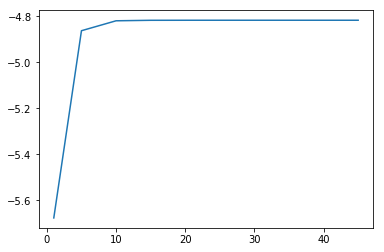

In [10]:
x = find_pass
y = find_perplexity
plt.plot(x, y)

# 결론 : perplexity는 낮을 수록 좋으므로, pass를 1로 설정하자.

# 6. LDA 최선의 하이퍼 파라미터 찾기 - Iteration

In [11]:
warnings.filterwarnings('ignore')

# 실험값 담을 곳
find_coherence=[]
find_perplexity=[]
find_Iteration=[]

for i in range(10): # 10회 실험
    t_Num_topic = 10 # 토픽 갯수
    
    # 실험에서 iteration은 10씩 커지게 설정
    if i==0:
        t_Iteration = 1
    else:
        t_Iteration=i*10
            
    # 실험
    find_lda = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=t_Num_topic, passes=1, iterations = t_Iteration) # t_Iteration 값에 따라 실험하기
    
    # 실험값 담기 - Iteration
    print('Iteration', t_Iteration)
    find_Iteration.append(t_Iteration)
    
    # 실험값 담기 - Coherence
    t_cm = CoherenceModel(model=find_lda, corpus=corpus, coherence='u_mass')
    t_coherence = t_cm.get_coherence()
    print('Coherence', t_coherence)
    find_coherence.append(t_coherence)
    
    # 실험값 담기 - Perplexity
    print('Perplexity', find_lda.log_perplexity(corpus),'\n')
    find_perplexity.append(find_lda.log_perplexity(corpus))

2019-10-29 00:37:37,518 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:37,523 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:37,525 : INFO : using serial LDA version on this node
2019-10-29 00:37:37,528 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:37:37,530 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:37,587 : INFO : -6.847 per-word bound, 115.1 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:37,589 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:37,596 : INFO : topic #1 (0.100): 0.093*"bar" + 0.033*"energy" + 0.030*"saturated" + 0.021*"fat" + 0.019*"sugar" + 0.018*"contain" + 0.017*"others" + 0.017

Iteration 1
Coherence 1.0000889005818406e-12
Perplexity -6.438348466828025 



2019-10-29 00:37:37,805 : INFO : -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:37,807 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:37,817 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:37,824 : INFO : using serial LDA version on this node
2019-10-29 00:37:37,840 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 10x with a convergence threshold of 0.001000
2019-10-29 00:37:37,848 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:37,919 : INFO : -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:37,923 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:37,956 : INFO : 

Iteration 10
Coherence 1.0000889005818406e-12
Perplexity -6.325154849058072 



2019-10-29 00:37:38,209 : INFO : -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:38,212 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:38,215 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:38,218 : INFO : using serial LDA version on this node
2019-10-29 00:37:38,220 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 20x with a convergence threshold of 0.001000
2019-10-29 00:37:38,223 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:38,363 : INFO : -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:38,366 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:38,393 : INFO : 

Iteration 20
Coherence 1.0000889005818406e-12
Perplexity

2019-10-29 00:37:38,686 : INFO : -6.175 per-word bound, 72.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:38,688 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:38,692 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:38,693 : INFO : using serial LDA version on this node
2019-10-29 00:37:38,696 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 30x with a convergence threshold of 0.001000
2019-10-29 00:37:38,697 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:38,802 : INFO : -6.821 per-word bound, 113.0 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:38,830 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:38,865 : INFO : 

 -6.173160414159651 

Iteration 30
Coherence 1.0000889005818406e-12



2019-10-29 00:37:39,221 : INFO : -5.706 per-word bound, 52.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:39,237 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:39,241 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:39,246 : INFO : using serial LDA version on this node
2019-10-29 00:37:39,250 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 40x with a convergence threshold of 0.001000
2019-10-29 00:37:39,254 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


Perplexity -5.705853722645686 



2019-10-29 00:37:39,378 : INFO : -6.824 per-word bound, 113.3 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:39,381 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:39,423 : INFO : topic #8 (0.100): 0.043*"bar" + 0.018*"saturated" + 0.018*"energy" + 0.017*"fat" + 0.016*"higher" + 0.016*"others" + 0.014*"nutrition" + 0.013*"contain" + 0.013*"protein" + 0.013*"syrup"
2019-10-29 00:37:39,427 : INFO : topic #7 (0.100): 0.084*"bar" + 0.033*"energy" + 0.027*"saturated" + 0.025*"gram" + 0.024*"fat" + 0.019*"others" + 0.019*"much" + 0.018*"sugar" + 0.018*"nutrition" + 0.017*"contain"
2019-10-29 00:37:39,450 : INFO : topic #1 (0.100): 0.102*"bar" + 0.040*"energy" + 0.034*"fat" + 0.025*"saturated" + 0.020*"sugar" + 0.019*"higher" + 0.018*"protein" + 0.018*"nutrition" + 0.017*"contain" + 0.016*"others"
2019-10-29 00:37:39,463 : INFO : topic #0 (0.100): 0.076*"bar" + 0.027*"saturated" + 0.026*"energy" + 0.022*"fat" + 0.021*"nutrition" + 0.

Iteration 40
Coherence 1.0000889005818406e-12
Perplexity -5.716131630733874 



2019-10-29 00:37:39,745 : INFO : -5.716 per-word bound, 52.5 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:39,748 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:39,750 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:39,753 : INFO : using serial LDA version on this node
2019-10-29 00:37:39,756 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 50x with a convergence threshold of 0.001000
2019-10-29 00:37:39,767 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:39,877 : INFO : -6.786 per-word bound, 110.3 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:39,879 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:39,928 : INFO : 

Iteration 50
Coherence 1.0000889005818406e-12
Perplexity -5.431444958681186 



2019-10-29 00:37:40,120 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:40,122 : INFO : using serial LDA version on this node
2019-10-29 00:37:40,124 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 60x with a convergence threshold of 0.001000
2019-10-29 00:37:40,129 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:40,210 : INFO : -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:40,212 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:40,251 : INFO : topic #5 (0.100): 0.010*"bar" + 0.009*"fat" + 0.009*"energy" + 0.009*"saturated" + 0.009*"others" + 0.009*"sugar" + 0.009*"protein" + 0.009*"much" + 0.009*"contain" + 0.009*"gram"
2019-10-29 00:37:40,

Iteration 60
Coherence 1.0000889005818406e-12
Perplexity -5.278545400870622 



2019-10-29 00:37:40,529 : INFO : -6.768 per-word bound, 109.0 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:40,532 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:40,586 : INFO : topic #9 (0.100): 0.022*"bar" + 0.014*"saturated" + 0.013*"energy" + 0.013*"fat" + 0.012*"higher" + 0.012*"contain" + 0.012*"protein" + 0.011*"nutrition" + 0.011*"sugar" + 0.011*"athlete"
2019-10-29 00:37:40,588 : INFO : topic #4 (0.100): 0.076*"bar" + 0.038*"energy" + 0.029*"saturated" + 0.028*"fat" + 0.028*"higher" + 0.020*"nutrition" + 0.017*"others" + 0.016*"gram" + 0.016*"protein" + 0.015*"contain"
2019-10-29 00:37:40,591 : INFO : topic #8 (0.100): 0.043*"bar" + 0.022*"energy" + 0.019*"saturated" + 0.016*"protein" + 0.016*"higher" + 0.015*"fat" + 0.014*"amount" + 0.013*"contain" + 0.013*"others" + 0.013*"sugar"
2019-10-29 00:37:40,592 : INFO : topic #1 (0.100): 0.065*"bar" + 0.033*"saturated" + 0.031*"energy" + 0.022*"fat" + 0.020*"contain" + 0.

Iteration 70
Coherence 1.0000889005818406e-12
Perplexity -5.157826068485982 



2019-10-29 00:37:40,835 : INFO : -6.754 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:40,837 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:40,902 : INFO : topic #0 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"fat" + 0.009*"energy" + 0.009*"much" + 0.009*"sugar" + 0.009*"gram" + 0.009*"nutrition" + 0.009*"contain" + 0.009*"protein"
2019-10-29 00:37:40,904 : INFO : topic #9 (0.100): 0.009*"bar" + 0.009*"saturated" + 0.009*"energy" + 0.009*"fat" + 0.009*"others" + 0.009*"much" + 0.009*"higher" + 0.009*"protein" + 0.009*"contain" + 0.009*"sugar"
2019-10-29 00:37:40,906 : INFO : topic #4 (0.100): 0.009*"bar" + 0.009*"energy" + 0.009*"saturated" + 0.009*"fat" + 0.009*"protein" + 0.009*"others" + 0.009*"nutrition" + 0.009*"sugar" + 0.009*"syrup" + 0.009*"much"
2019-10-29 00:37:40,907 : INFO : topic #1 (0.100): 0.057*"bar" + 0.021*"energy" + 0.020*"saturated" + 0.020*"fat" + 0.019*"others" + 0.017*"higher

Iteration 80
Coherence 1.0000889005818406e-12
Perplexity -5.296427826627472 



2019-10-29 00:37:41,134 : INFO : -5.296 per-word bound, 39.3 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:41,136 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:41,140 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:41,144 : INFO : using serial LDA version on this node
2019-10-29 00:37:41,147 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 90x with a convergence threshold of 0.001000
2019-10-29 00:37:41,149 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:41,270 : INFO : -6.784 per-word bound, 110.2 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:41,273 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:41,352 : INFO : 

Iteration 90
Coherence 1.0000889005818406e-12


2019-10-29 00:37:41,579 : INFO : -5.663 per-word bound, 50.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:41,693 : INFO : -5.662 per-word bound, 50.6 perplexity estimate based on a held-out corpus of 5 documents with 845 words


Perplexity -5.662517524470944 



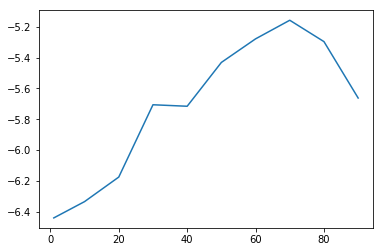

In [12]:
x = find_Iteration
y = find_perplexity
plt.plot(x, y)

# 결론 : perplexity는 낮을 수록 좋으므로, Iteration을 1로 설정하자.

# 7. LDA 하이퍼 파라미터 튜닝 & LDA 생성

In [13]:
# LDA 하이퍼 파라미터 튜닝
Num_topic = 10 # 가설 토픽 수
Pass = 1 # Epochs
Iteration = 1 # Loops

In [14]:
# LDA 생성
def lda_model(corpus, dictionary):
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                          num_topics=Num_topic, update_every=1, 
                                          chunksize=10000, passes=Pass,
                                          iterations = Iteration
                                         )
    return lda

lda = lda_model(corpus, dictionary)

2019-10-29 00:37:42,250 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:42,256 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:42,271 : INFO : using serial LDA version on this node
2019-10-29 00:37:42,276 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:37:42,279 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:42,350 : INFO : -6.842 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 5 documents with 845 words
2019-10-29 00:37:42,352 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:42,359 : INFO : topic #9 (0.100): 0.079*"bar" + 0.025*"saturated" + 0.024*"fat" + 0.023*"energy" + 0.023*"much" + 0.020*"sugar" + 0.018*"contain" + 0.018*"

In [15]:
# LDA 토픽, 확률 추출
def lda_topic_prob(lda):
    return lda.show_topic(1, 10)

In [16]:
# LDA 토픽 추출
def lda_topic(lda):
    return [word for word, prob in lda.show_topic(1, topn=10)]

# 8. LDA 이용

In [17]:
# LDA 이용
def LDA_modul(x):
    alltext = data_token(x)
    alltext = remove_once(alltext)
    dictionary = gensim_dict(alltext)
    corpus = corpus_text(dictionary, alltext)
    lda = lda_model(corpus, dictionary)
    result1 = lda_topic_prob(lda)
    result2 = lda_topic(lda)
    return result1, result2

In [18]:
LDA_modul(4) # data의 4번째 행 키워드 추출 실험

2019-10-29 00:37:42,961 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:42,967 : INFO : built Dictionary(69 unique tokens: ['ensure', 'fireball', 'relative', 'spread', 'come']...) from 5 documents (total 450 corpus positions)
2019-10-29 00:37:42,971 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:42,974 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:42,976 : INFO : using serial LDA version on this node
2019-10-29 00:37:42,981 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:37:42,983 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:43,023 : INFO : -6.723 per-word bound, 105.7 perplexity estimate based on a held-out corpus of 5 documen

([('incident', 0.043400817),
  ('said', 0.038928043),
  ('ghana', 0.03182353),
  ('addo', 0.024351856),
  ('ensure', 0.023543656),
  ('akufo', 0.023127707),
  ('killed', 0.021543942),
  ('tanker', 0.021284917),
  ('government', 0.021256097),
  ('explosion', 0.020926414)],
 ['incident',
  'said',
  'ghana',
  'addo',
  'ensure',
  'akufo',
  'killed',
  'tanker',
  'government',
  'explosion'])

In [19]:
data['KEYWORDS'][4] # data의 4번째 행 키워드 정답

"['akufoaddo', 'tanker', 'incidents', 'dozens', 'streetsgovernment', 'work', 'station', 'seven', 'explosion', 'gas', 'ghana', 'nana', 'injured', 'ensure', 'killed']"

# 9. LDA로 전체 데이터의 키워드 추출

In [20]:
data['PREDICT_KEYWORDS_PROB'] = 0
data['PREDICT_KEYWORDS'] = 0
data['HASHTAG'] = 0

In [21]:
for i in range(0, len(data)):
    result1, result2 = LDA_modul(i)
    data['PREDICT_KEYWORDS_PROB'][i] = result1
    data['PREDICT_KEYWORDS'][i] = result2
    data['HASHTAG'][i] = '#'+' #'.join(result2)

2019-10-29 00:37:43,387 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:43,400 : INFO : built Dictionary(111 unique tokens: ['replacement', 'energy', 'watch', 'come', 'satisfying']...) from 5 documents (total 845 corpus positions)
2019-10-29 00:37:43,403 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:43,405 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:43,406 : INFO : using serial LDA version on this node
2019-10-29 00:37:43,409 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:37:43,413 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:43,547 : INFO : -6.856 per-word bound, 115.8 perplexity estimate based on a held-out corpus of 5 do

2019-10-29 00:37:45,919 : INFO : topic #6 (0.100): 0.039*"harris" + 0.035*"scent" + 0.034*"perfumer" + 0.029*"art" + 0.028*"one" + 0.021*"client" + 0.020*"founded" + 0.020*"world" + 0.017*"made" + 0.017*"perfume"
2019-10-29 00:37:45,940 : INFO : topic #2 (0.100): 0.062*"harris" + 0.041*"scent" + 0.028*"art" + 0.024*"perfumer" + 0.020*"made" + 0.020*"one" + 0.019*"quite" + 0.018*"client" + 0.018*"perfume" + 0.017*"founded"
2019-10-29 00:37:45,945 : INFO : topic diff=0.702210, rho=1.000000
2019-10-29 00:37:46,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:46,580 : INFO : built Dictionary(69 unique tokens: ['ensure', 'fireball', 'relative', 'spread', 'come']...) from 5 documents (total 450 corpus positions)
2019-10-29 00:37:46,582 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:46,583 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:46,585 : INFO : using serial LDA version on this node
2019-10-29 00:37:46,587 : INFO : running online (single-

2019-10-29 00:37:48,712 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:48,724 : INFO : topic #2 (0.100): 0.023*"kellogg" + 0.018*"power" + 0.018*"said" + 0.017*"child" + 0.016*"air" + 0.013*"clean" + 0.010*"asthma" + 0.010*"health" + 0.009*"plan" + 0.009*"pollution"
2019-10-29 00:37:48,727 : INFO : topic #6 (0.100): 0.020*"child" + 0.016*"kellogg" + 0.016*"air" + 0.011*"power" + 0.011*"health" + 0.011*"asthma" + 0.011*"said" + 0.010*"clean" + 0.009*"plan" + 0.009*"pollution"
2019-10-29 00:37:48,731 : INFO : topic #4 (0.100): 0.017*"kellogg" + 0.016*"child" + 0.016*"said" + 0.015*"asthma" + 0.014*"power" + 0.014*"air" + 0.011*"health" + 0.011*"year" + 0.010*"clean" + 0.009*"administration"
2019-10-29 00:37:48,734 : INFO : topic #5 (0.100): 0.020*"kellogg" + 0.020*"child" + 0.017*"air" + 0.014*"power" + 0.012*"said" + 0.012*"health" + 0.012*"asthma" + 0.010*"lung" + 0.010*"clean" + 0.009*"obama"
2019-10-29 00:37:48,738 : INFO : topic #0 (0.100): 0.019*"kellogg" + 0.019*"sai

2019-10-29 00:37:51,996 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:52,004 : INFO : using serial LDA version on this node
2019-10-29 00:37:52,009 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:37:52,011 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:52,284 : INFO : -8.243 per-word bound, 302.9 perplexity estimate based on a held-out corpus of 5 documents with 6160 words
2019-10-29 00:37:52,286 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:52,298 : INFO : topic #2 (0.100): 0.023*"said" + 0.021*"parent" + 0.018*"burnout" + 0.014*"need" + 0.012*"time" + 0.011*"two" + 0.010*"mom" + 0.009*"kid" + 0.009*"mother" + 0.008*"everything"
2019-10-29 00:37:52,302 

2019-10-29 00:37:54,252 : INFO : topic #1 (0.100): 0.037*"trump" + 0.025*"ivanka" + 0.019*"immigration" + 0.019*"issue" + 0.018*"program" + 0.018*"arrival" + 0.017*"complicated" + 0.016*"woman" + 0.016*"monday" + 0.015*"act"
2019-10-29 00:37:54,254 : INFO : topic diff=0.716242, rho=1.000000
2019-10-29 00:37:54,705 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:54,708 : INFO : built Dictionary(124 unique tokens: ['fox', 'anxious', 'kerner', 'ian', 'focus']...) from 5 documents (total 895 corpus positions)
2019-10-29 00:37:54,712 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:54,719 : INFO : using symmetric eta at 0.1
2019-10-29 00:37:54,721 : INFO : using serial LDA version on this node
2019-10-29 00:37:54,725 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.

2019-10-29 00:37:56,641 : INFO : topic #6 (0.100): 0.041*"study" + 0.039*"kit" + 0.037*"test" + 0.036*"hiv" + 0.027*"grindr" + 0.017*"men" + 0.014*"self" + 0.013*"researcher" + 0.013*"getting" + 0.013*"app"
2019-10-29 00:37:56,648 : INFO : topic #4 (0.100): 0.041*"hiv" + 0.038*"test" + 0.031*"grindr" + 0.029*"kit" + 0.028*"study" + 0.020*"men" + 0.013*"way" + 0.013*"self" + 0.013*"user" + 0.013*"risk"
2019-10-29 00:37:56,656 : INFO : topic #9 (0.100): 0.050*"test" + 0.046*"study" + 0.042*"hiv" + 0.026*"kit" + 0.022*"grindr" + 0.016*"men" + 0.015*"self" + 0.014*"tested" + 0.014*"stigma" + 0.013*"gay"
2019-10-29 00:37:56,668 : INFO : topic diff=0.801690, rho=1.000000
2019-10-29 00:37:57,164 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:37:57,166 : INFO : built Dictionary(178 unique tokens: ['sorry', 'end', 'extent', 'u', 'new']...) from 5 documents (total 1255 corpus positions)
2019-10-29 00:37:57,169 : INFO : using symmetric alpha at 0.1
2019-10-29 00:37:5

2019-10-29 00:37:58,822 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:37:58,938 : INFO : -7.552 per-word bound, 187.6 perplexity estimate based on a held-out corpus of 5 documents with 1585 words
2019-10-29 00:37:58,940 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:37:58,948 : INFO : topic #3 (0.100): 0.029*"said" + 0.021*"company" + 0.017*"worrying" + 0.014*"paperless" + 0.014*"post" + 0.013*"people" + 0.013*"online" + 0.012*"hirschfeld" + 0.012*"really" + 0.011*"life"
2019-10-29 00:37:58,950 : INFO : topic #0 (0.100): 0.025*"said" + 0.017*"company" + 0.015*"people" + 0.015*"life" + 0.015*"worrying" + 0.013*"online" + 0.013*"face" + 0.012*"paperless" + 0.012*"founder" + 0.012*"post"
2019-10-29 00:37:58,951 : INFO : topic #2 (0.100): 0.025*"said" + 0.022*"company" + 0.018*"people" + 0.015*"online" + 0.014*"paperless" + 0.014*"worrying" + 0.013*"post" + 0.013*"technology" + 0

2019-10-29 00:38:01,109 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:01,116 : INFO : built Dictionary(319 unique tokens: ['harvested', 'story', 'cited', 'portion', 'campaign']...) from 5 documents (total 2925 corpus positions)
2019-10-29 00:38:01,121 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:01,123 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:01,126 : INFO : using serial LDA version on this node
2019-10-29 00:38:01,129 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:01,132 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:01,283 : INFO : -7.560 per-word bound, 188.7 perplexity estimate based on a held-out corpus of 5 doc

2019-10-29 00:38:03,384 : INFO : topic #6 (0.100): 0.031*"working" + 0.023*"class" + 0.020*"said" + 0.018*"white" + 0.013*"feel" + 0.011*"economy" + 0.009*"nation" + 0.008*"job" + 0.007*"american" + 0.007*"economic"
2019-10-29 00:38:03,387 : INFO : topic #3 (0.100): 0.031*"said" + 0.027*"working" + 0.023*"white" + 0.014*"economy" + 0.013*"class" + 0.013*"feel" + 0.011*"view" + 0.009*"cnn" + 0.008*"nation" + 0.008*"state"
2019-10-29 00:38:03,389 : INFO : topic #7 (0.100): 0.024*"white" + 0.024*"class" + 0.022*"working" + 0.018*"said" + 0.014*"feel" + 0.013*"economy" + 0.007*"view" + 0.007*"people" + 0.007*"cnn" + 0.007*"economic"
2019-10-29 00:38:03,392 : INFO : topic diff=0.856346, rho=1.000000
2019-10-29 00:38:03,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:03,901 : INFO : built Dictionary(185 unique tokens: ['josh', 'paradise', 'end', 'crest', 'subdivision']...) from 5 documents (total 2590 corpus positions)
2019-10-29 00:38:03,904 : INFO : usin

2019-10-29 00:38:05,962 : INFO : -7.903 per-word bound, 239.4 perplexity estimate based on a held-out corpus of 5 documents with 2570 words
2019-10-29 00:38:05,963 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:05,970 : INFO : topic #1 (0.100): 0.024*"eu" + 0.020*"uk" + 0.020*"brexit" + 0.017*"may" + 0.015*"minister" + 0.013*"brussels" + 0.013*"deal" + 0.011*"britain" + 0.009*"even" + 0.008*"also"
2019-10-29 00:38:05,972 : INFO : topic #8 (0.100): 0.026*"may" + 0.026*"eu" + 0.022*"deal" + 0.021*"brexit" + 0.018*"uk" + 0.015*"minister" + 0.012*"british" + 0.011*"britain" + 0.010*"even" + 0.010*"brussels"
2019-10-29 00:38:05,975 : INFO : topic #6 (0.100): 0.024*"eu" + 0.020*"minister" + 0.018*"may" + 0.016*"uk" + 0.016*"deal" + 0.015*"britain" + 0.015*"brexit" + 0.011*"want" + 0.011*"brussels" + 0.009*"theresa"
2019-10-29 00:38:05,978 : INFO : topic #9 (0.100): 0.029*"eu" + 0.023*"brexit" + 0.021*"may" + 0.016*"uk" + 0.016*"deal" + 0.014*"want" + 0.013*"minister" + 0.013*"b

2019-10-29 00:38:09,306 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:09,308 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:09,311 : INFO : using serial LDA version on this node
2019-10-29 00:38:09,314 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:09,316 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:09,557 : INFO : -8.211 per-word bound, 296.3 perplexity estimate based on a held-out corpus of 5 documents with 5200 words
2019-10-29 00:38:09,559 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:09,572 : INFO : topic #5 (0.100): 0.026*"mh370" + 0.017*"narendran" + 0.013*"passenger" + 0.013*"photo" + 0.012*"remembering" + 0.012*"hide" + 0.012*"capt

2019-10-29 00:38:12,137 : INFO : topic #1 (0.100): 0.019*"trump" + 0.016*"woman" + 0.014*"bill" + 0.011*"clinton" + 0.011*"said" + 0.011*"men" + 0.010*"allegation" + 0.010*"weinstein" + 0.010*"sexual" + 0.009*"bothered"
2019-10-29 00:38:12,142 : INFO : topic diff=0.822489, rho=1.000000
2019-10-29 00:38:12,704 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:12,706 : INFO : built Dictionary(7 unique tokens: ['help', 'cushion', 'joint', 'lubricates', 'keep']...) from 5 documents (total 35 corpus positions)
2019-10-29 00:38:12,711 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:12,713 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:12,715 : INFO : using serial LDA version on this node
2019-10-29 00:38:12,717 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.00

2019-10-29 00:38:15,068 : INFO : topic #6 (0.100): 0.036*"spain" + 0.035*"catalonia" + 0.021*"people" + 0.021*"catalan" + 0.016*"independence" + 0.013*"spanish" + 0.013*"said" + 0.009*"love" + 0.009*"referendum" + 0.009*"would"
2019-10-29 00:38:15,071 : INFO : topic #8 (0.100): 0.035*"catalonia" + 0.032*"catalan" + 0.024*"spain" + 0.021*"said" + 0.017*"independence" + 0.014*"people" + 0.012*"spanish" + 0.011*"referendum" + 0.009*"love" + 0.009*"need"
2019-10-29 00:38:15,073 : INFO : topic #9 (0.100): 0.029*"catalonia" + 0.029*"spain" + 0.022*"independence" + 0.020*"catalan" + 0.015*"people" + 0.012*"said" + 0.010*"spanish" + 0.010*"love" + 0.010*"referendum" + 0.009*"crisis"
2019-10-29 00:38:15,077 : INFO : topic diff=0.855393, rho=1.000000
2019-10-29 00:38:15,668 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:15,672 : INFO : built Dictionary(118 unique tokens: ['concern', 'could', 'positioned', 'size', 'nation']...) from 5 documents (total 770 corpus p

2019-10-29 00:38:18,015 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:18,152 : INFO : -7.488 per-word bound, 179.5 perplexity estimate based on a held-out corpus of 5 documents with 880 words
2019-10-29 00:38:18,156 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:18,166 : INFO : topic #6 (0.100): 0.043*"spielberg" + 0.020*"director" + 0.018*"movie" + 0.017*"film" + 0.017*"perhaps" + 0.013*"tv" + 0.013*"one" + 0.013*"best" + 0.012*"blockbuster" + 0.012*"portrait"
2019-10-29 00:38:18,171 : INFO : topic #9 (0.100): 0.045*"spielberg" + 0.022*"director" + 0.022*"movie" + 0.019*"perhaps" + 0.015*"making" + 0.013*"film" + 0.013*"one" + 0.013*"best" + 0.012*"half" + 0.012*"tv"
2019-10-29 00:38:18,174 : INFO : topic #8 (0.100): 0.047*"spielberg" + 0.019*"movie" + 0.017*"director" + 0.016*"one" + 0.015*"perhaps" + 0.015*"film" + 0.013*"making" + 0.012*"portrait" + 0.012*"helped" +

2019-10-29 00:38:20,682 : INFO : topic diff=0.636596, rho=1.000000
2019-10-29 00:38:21,310 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:21,319 : INFO : built Dictionary(488 unique tokens: ['energy', 'fossil', 'review', 'benjamin', 'expert']...) from 5 documents (total 5230 corpus positions)
2019-10-29 00:38:21,327 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:21,330 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:21,333 : INFO : using serial LDA version on this node
2019-10-29 00:38:21,337 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:21,341 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:21,527 : INFO : -7.786 per-word bou

2019-10-29 00:38:23,586 : INFO : topic #4 (0.100): 0.025*"trafficking" + 0.022*"sephak" + 0.020*"sex" + 0.018*"say" + 0.017*"mother" + 0.017*"money" + 0.015*"svay" + 0.015*"child" + 0.015*"girl" + 0.015*"police"
2019-10-29 00:38:23,588 : INFO : topic #9 (0.100): 0.028*"say" + 0.023*"sex" + 0.022*"trafficking" + 0.018*"police" + 0.017*"sephak" + 0.015*"daughter" + 0.014*"girl" + 0.014*"svay" + 0.014*"aim" + 0.013*"money"
2019-10-29 00:38:23,590 : INFO : topic #7 (0.100): 0.028*"trafficking" + 0.022*"sephak" + 0.022*"say" + 0.017*"mother" + 0.016*"money" + 0.014*"girl" + 0.014*"daughter" + 0.014*"pak" + 0.014*"work" + 0.014*"sex"
2019-10-29 00:38:23,595 : INFO : topic diff=0.869387, rho=1.000000
2019-10-29 00:38:23,982 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:23,984 : INFO : built Dictionary(79 unique tokens: ['nigeria', 'issue', 'something', 'death', 'game']...) from 5 documents (total 615 corpus positions)
2019-10-29 00:38:23,986 : INFO : using sy

2019-10-29 00:38:25,733 : INFO : -7.500 per-word bound, 181.1 perplexity estimate based on a held-out corpus of 5 documents with 2375 words
2019-10-29 00:38:25,734 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:25,742 : INFO : topic #0 (0.100): 0.032*"would" + 0.028*"obamacare" + 0.022*"bill" + 0.015*"year" + 0.014*"replacement" + 0.014*"senate" + 0.013*"million" + 0.013*"repeal" + 0.013*"law" + 0.012*"house"
2019-10-29 00:38:25,743 : INFO : topic #1 (0.100): 0.038*"would" + 0.026*"obamacare" + 0.025*"repeal" + 0.024*"bill" + 0.020*"senate" + 0.015*"year" + 0.012*"republican" + 0.012*"million" + 0.012*"people" + 0.011*"law"
2019-10-29 00:38:25,744 : INFO : topic #3 (0.100): 0.031*"would" + 0.024*"obamacare" + 0.021*"bill" + 0.019*"repeal" + 0.016*"year" + 0.013*"people" + 0.013*"lawmaker" + 0.012*"million" + 0.012*"replacement" + 0.011*"senate"
2019-10-29 00:38:25,746 : INFO : topic #5 (0.100): 0.055*"would" + 0.021*"obamacare" + 0.021*"repeal" + 0.021*"bill" + 0.017*"yea

2019-10-29 00:38:27,736 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:27,737 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:27,738 : INFO : using serial LDA version on this node
2019-10-29 00:38:27,742 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:27,745 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:27,894 : INFO : -8.002 per-word bound, 256.3 perplexity estimate based on a held-out corpus of 5 documents with 5060 words
2019-10-29 00:38:27,896 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:27,905 : INFO : topic #0 (0.100): 0.039*"sugar" + 0.017*"said" + 0.013*"day" + 0.012*"alpert" + 0.012*"week" + 0.011*"detox" + 0.009*"sweetener" + 0.009*"

2019-10-29 00:38:29,306 : INFO : topic #3 (0.100): 0.048*"change" + 0.048*"climate" + 0.042*"plan" + 0.036*"agency" + 0.030*"year" + 0.023*"epa" + 0.023*"four" + 0.021*"document" + 0.020*"strategic" + 0.018*"appear"
2019-10-29 00:38:29,311 : INFO : topic #2 (0.100): 0.053*"change" + 0.046*"climate" + 0.040*"plan" + 0.027*"four" + 0.026*"year" + 0.025*"strategic" + 0.024*"epa" + 0.024*"agency" + 0.022*"environmental" + 0.022*"priority"
2019-10-29 00:38:29,312 : INFO : topic diff=0.807846, rho=1.000000
2019-10-29 00:38:29,776 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:29,785 : INFO : built Dictionary(733 unique tokens: ['let', 'wave', 'velocity', 'blanket', 'frantically']...) from 5 documents (total 7220 corpus positions)
2019-10-29 00:38:29,794 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:29,795 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:29,797 : INFO : using serial LDA version on this node
2019-10-29 00:38:29,802 : INFO : running

2019-10-29 00:38:31,558 : INFO : topic #1 (0.100): 0.094*"isi" + 0.091*"u" + 0.091*"soldier" + 0.076*"taken" + 0.073*"killed" + 0.066*"report" + 0.061*"alive" + 0.053*"niger" + 0.052*"starr" + 0.049*"cnn"
2019-10-29 00:38:31,561 : INFO : topic #6 (0.100): 0.104*"killed" + 0.101*"alive" + 0.079*"taken" + 0.072*"soldier" + 0.070*"u" + 0.065*"isi" + 0.055*"first" + 0.054*"ambush" + 0.049*"one" + 0.049*"four"
2019-10-29 00:38:31,564 : INFO : topic #2 (0.100): 0.093*"isi" + 0.093*"taken" + 0.092*"killed" + 0.079*"u" + 0.063*"barbara" + 0.059*"soldier" + 0.059*"one" + 0.057*"alive" + 0.052*"cnn" + 0.049*"starr"
2019-10-29 00:38:31,567 : INFO : topic #4 (0.100): 0.099*"alive" + 0.094*"u" + 0.085*"killed" + 0.075*"soldier" + 0.072*"isi" + 0.068*"taken" + 0.055*"ambush" + 0.054*"niger" + 0.053*"one" + 0.051*"cnn"
2019-10-29 00:38:31,570 : INFO : topic #5 (0.100): 0.089*"taken" + 0.087*"alive" + 0.086*"u" + 0.083*"killed" + 0.083*"soldier" + 0.081*"isi" + 0.058*"four" + 0.053*"cnn" + 0.048*"poss

2019-10-29 00:38:33,627 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:33,629 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:33,723 : INFO : -7.889 per-word bound, 237.1 perplexity estimate based on a held-out corpus of 5 documents with 2245 words
2019-10-29 00:38:33,724 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:33,732 : INFO : topic #0 (0.100): 0.046*"park" + 0.025*"central" + 0.022*"new" + 0.021*"york" + 0.014*"ny" + 0.013*"museum" + 0.011*"city" + 0.010*"get" + 0.009*"green" + 0.007*"along"
2019-10-29 00:38:33,734 : INFO : topic #9 (0.100): 0.046*"park" + 0.022*"new" + 0.019*"york" + 0.018*"museum" + 0.017*"central" + 0.010*"ny" + 0.010*"city" + 0.01

2019-10-29 00:38:35,247 : INFO : topic diff=0.505645, rho=1.000000
2019-10-29 00:38:35,630 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:35,632 : INFO : built Dictionary(79 unique tokens: ['administration', 'administrator', 'week', 'regulation', 'focus']...) from 5 documents (total 565 corpus positions)
2019-10-29 00:38:35,634 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:35,635 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:35,636 : INFO : using serial LDA version on this node
2019-10-29 00:38:35,638 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:35,639 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:35,679 : INFO : -6.665 

2019-10-29 00:38:37,364 : INFO : topic #4 (0.100): 0.044*"museum" + 0.039*"seuss" + 0.038*"mural" + 0.024*"springfield" + 0.022*"dr" + 0.018*"said" + 0.015*"book" + 0.014*"letter" + 0.013*"author" + 0.013*"read"
2019-10-29 00:38:37,367 : INFO : topic #3 (0.100): 0.040*"mural" + 0.040*"museum" + 0.027*"seuss" + 0.024*"dr" + 0.018*"springfield" + 0.016*"said" + 0.016*"book" + 0.016*"author" + 0.013*"letter" + 0.012*"yee"
2019-10-29 00:38:37,370 : INFO : topic #7 (0.100): 0.036*"mural" + 0.033*"museum" + 0.023*"dr" + 0.022*"seuss" + 0.021*"author" + 0.020*"springfield" + 0.016*"said" + 0.014*"book" + 0.014*"child" + 0.013*"letter"
2019-10-29 00:38:37,373 : INFO : topic #6 (0.100): 0.041*"mural" + 0.038*"museum" + 0.025*"dr" + 0.024*"springfield" + 0.022*"seuss" + 0.017*"author" + 0.016*"book" + 0.014*"said" + 0.014*"three" + 0.013*"asian"
2019-10-29 00:38:37,376 : INFO : topic diff=0.922031, rho=1.000000
2019-10-29 00:38:37,851 : INFO : adding document #0 to Dictionary(0 unique tokens: []

2019-10-29 00:38:39,413 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:39,562 : INFO : -7.984 per-word bound, 253.2 perplexity estimate based on a held-out corpus of 5 documents with 4230 words
2019-10-29 00:38:39,564 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:39,572 : INFO : topic #9 (0.100): 0.029*"kim" + 0.027*"u" + 0.024*"north" + 0.021*"said" + 0.017*"korea" + 0.014*"lee" + 0.012*"regime" + 0.010*"korean" + 0.009*"military" + 0.009*"state"
2019-10-29 00:38:39,574 : INFO : topic #2 (0.100): 0.030*"kim" + 0.028*"north" + 0.024*"u" + 0.022*"said" + 0.022*"korea" + 0.019*"lee" + 0.011*"un" + 0.011*"nuclear" + 0.010*"korean" + 0.009*"state"
2019-10-29 00:38:39,576 : INFO : topic #1 (0.100): 0.028*"u" + 0.026*"kim" + 0.022*"said" + 0.021*"korea" + 0.017*"north" + 0.014*"lee" + 0.012*"regime" + 0.011*"state" + 0.010*"jong" + 0.009*"korean"
2019-10-29 00:38:39,578 : INF

2019-10-29 00:38:41,684 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:41,685 : INFO : built Dictionary(35 unique tokens: ['story', 'business', 'see', 'cnn', 'get']...) from 5 documents (total 220 corpus positions)
2019-10-29 00:38:41,687 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:41,688 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:41,690 : INFO : using serial LDA version on this node
2019-10-29 00:38:41,692 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:41,693 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:41,719 : INFO : -6.307 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 5 documents with 220

2019-10-29 00:38:43,337 : INFO : topic #9 (0.100): 0.056*"diet" + 0.039*"woman" + 0.038*"mediterranean" + 0.031*"study" + 0.028*"bone" + 0.026*"fracture" + 0.022*"hip" + 0.019*"health" + 0.014*"researcher" + 0.013*"le"
2019-10-29 00:38:43,340 : INFO : topic #7 (0.100): 0.086*"diet" + 0.032*"woman" + 0.030*"study" + 0.028*"mediterranean" + 0.028*"fracture" + 0.024*"health" + 0.022*"bone" + 0.019*"hip" + 0.017*"researcher" + 0.013*"healthy"
2019-10-29 00:38:43,342 : INFO : topic #6 (0.100): 0.058*"diet" + 0.034*"mediterranean" + 0.032*"woman" + 0.032*"study" + 0.028*"fracture" + 0.026*"hip" + 0.026*"health" + 0.019*"bone" + 0.015*"researcher" + 0.014*"case"
2019-10-29 00:38:43,344 : INFO : topic diff=0.858375, rho=1.000000
2019-10-29 00:38:43,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:43,801 : INFO : built Dictionary(298 unique tokens: ['violence', 'even', 'single', 'book', 'campaign']...) from 5 documents (total 1975 corpus positions)
2019-10-29 

2019-10-29 00:38:45,478 : INFO : -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 5 documents with 405 words
2019-10-29 00:38:45,479 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:45,485 : INFO : topic #4 (0.100): 0.098*"house" + 0.082*"white" + 0.054*"secretary" + 0.044*"press" + 0.039*"gidley" + 0.029*"former" + 0.027*"spicer" + 0.026*"joining" + 0.025*"cnn" + 0.024*"huckabee"
2019-10-29 00:38:45,486 : INFO : topic #1 (0.100): 0.101*"house" + 0.071*"white" + 0.046*"press" + 0.043*"gidley" + 0.040*"secretary" + 0.033*"former" + 0.030*"huckabee" + 0.026*"sander" + 0.025*"cnn" + 0.023*"spicer"
2019-10-29 00:38:45,492 : INFO : topic #3 (0.100): 0.115*"white" + 0.057*"secretary" + 0.056*"house" + 0.055*"press" + 0.043*"gidley" + 0.024*"joining" + 0.023*"former" + 0.023*"cnn" + 0.023*"director" + 0.023*"hogan"
2019-10-29 00:38:45,494 : INFO : topic #8 (0.100): 0.087*"white" + 0.074*"house" + 0.053*"gidley" + 0.045*"secretary" + 0.044*"press" + 0.0

2019-10-29 00:38:47,750 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:47,753 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:47,755 : INFO : using serial LDA version on this node
2019-10-29 00:38:47,757 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:47,758 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:47,786 : INFO : -6.578 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 5 documents with 335 words
2019-10-29 00:38:47,787 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:47,796 : INFO : topic #0 (0.100): 0.050*"puerto" + 0.040*"rico" + 0.037*"miranda" + 0.036*"praying" + 0.036*"song" + 0.030*"manuel" + 0.029*"like" + 0.027*"

2019-10-29 00:38:49,540 : INFO : topic #4 (0.100): 0.145*"transcript" + 0.079*"page" + 0.057*"segment" + 0.056*"check" + 0.050*"continually" + 0.050*"available" + 0.048*"october" + 0.047*"return" + 0.046*"find" + 0.046*"back"
2019-10-29 00:38:49,541 : INFO : topic diff=0.718285, rho=1.000000
2019-10-29 00:38:49,928 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:49,929 : INFO : built Dictionary(16 unique tokens: ['agree', 'privacy', 'policy', 'havana', 'continuing']...) from 5 documents (total 85 corpus positions)
2019-10-29 00:38:49,930 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:49,931 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:49,933 : INFO : using serial LDA version on this node
2019-10-29 00:38:49,935 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence thresh

2019-10-29 00:38:51,483 : INFO : topic #3 (0.100): 0.086*"first" + 0.066*"realized" + 0.059*"time" + 0.056*"black" + 0.036*"asked" + 0.033*"celebrity" + 0.033*"realizediwasblack" + 0.033*"color" + 0.032*"e" + 0.031*"du"
2019-10-29 00:38:51,484 : INFO : topic #6 (0.100): 0.074*"first" + 0.067*"realized" + 0.065*"black" + 0.044*"time" + 0.040*"anchor" + 0.034*"folk" + 0.033*"affected" + 0.032*"realizediwasblack" + 0.031*"others" + 0.031*"color"
2019-10-29 00:38:51,486 : INFO : topic #8 (0.100): 0.081*"realized" + 0.078*"first" + 0.069*"black" + 0.067*"time" + 0.033*"others" + 0.031*"reporter" + 0.031*"folk" + 0.030*"bois" + 0.030*"asked" + 0.030*"skin"
2019-10-29 00:38:51,488 : INFO : topic #9 (0.100): 0.082*"first" + 0.081*"black" + 0.078*"realized" + 0.038*"time" + 0.034*"cnn" + 0.033*"different" + 0.032*"people" + 0.032*"reporter" + 0.031*"celebrity" + 0.031*"tell"
2019-10-29 00:38:51,490 : INFO : topic diff=0.715157, rho=1.000000
2019-10-29 00:38:51,935 : INFO : adding document #0 to

2019-10-29 00:38:54,064 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:54,161 : INFO : -7.523 per-word bound, 183.9 perplexity estimate based on a held-out corpus of 5 documents with 2065 words
2019-10-29 00:38:54,163 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:38:54,170 : INFO : topic #9 (0.100): 0.042*"said" + 0.030*"loo" + 0.021*"baseball" + 0.016*"eye" + 0.013*"fan" + 0.013*"ball" + 0.013*"area" + 0.013*"lawsuit" + 0.011*"foul" + 0.011*"league"
2019-10-29 00:38:54,173 : INFO : topic #0 (0.100): 0.027*"said" + 0.024*"loo" + 0.021*"baseball" + 0.018*"major" + 0.017*"ball" + 0.016*"league" + 0.014*"eye" + 0.014*"game" + 0.013*"cub" + 0.012*"area"
2019-10-29 00:38:54,176 : INFO : topic #1 (0.100): 0.048*"said" + 0.027*"loo" + 0.018*"league" + 0.017*"baseball" + 0.015*"ball" + 0.012*"major" + 0.012*"foul" + 0.012*"fan" + 0.011*"game" + 0.011*"netting"
2019-10-29 00:38:54,

2019-10-29 00:38:56,491 : INFO : built Dictionary(79 unique tokens: ['every', 'sit', 'hayes', 'watch', 'relax']...) from 5 documents (total 500 corpus positions)
2019-10-29 00:38:56,493 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:56,494 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:56,496 : INFO : using serial LDA version on this node
2019-10-29 00:38:56,499 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:38:56,500 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:38:56,546 : INFO : -6.886 per-word bound, 118.3 perplexity estimate based on a held-out corpus of 5 documents with 500 words
2019-10-29 00:38:56,549 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29

2019-10-29 00:38:58,389 : INFO : topic #8 (0.100): 0.123*"unfolds" + 0.100*"messenger" + 0.100*"find" + 0.099*"facebook" + 0.095*"u" + 0.086*"happening" + 0.085*"chat" + 0.082*"world" + 0.079*"trump" + 0.077*"undercutting"
2019-10-29 00:38:58,392 : INFO : topic #9 (0.100): 0.106*"messenger" + 0.105*"find" + 0.101*"undercutting" + 0.097*"world" + 0.097*"u" + 0.093*"chat" + 0.091*"facebook" + 0.087*"tillerson" + 0.084*"unfolds" + 0.075*"trump"
2019-10-29 00:38:58,394 : INFO : topic diff=0.513185, rho=1.000000
2019-10-29 00:38:58,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:38:58,976 : INFO : built Dictionary(1012 unique tokens: ['let', 'wave', 'happy', 'focus', 'asleep']...) from 5 documents (total 11765 corpus positions)
2019-10-29 00:38:58,998 : INFO : using symmetric alpha at 0.1
2019-10-29 00:38:59,000 : INFO : using symmetric eta at 0.1
2019-10-29 00:38:59,004 : INFO : using serial LDA version on this node
2019-10-29 00:38:59,009 : INFO : running 

2019-10-29 00:39:01,684 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:01,701 : INFO : topic #9 (0.100): 0.018*"abuse" + 0.015*"facility" + 0.012*"nursing" + 0.012*"sexual" + 0.012*"home" + 0.011*"resident" + 0.011*"allegation" + 0.010*"state" + 0.010*"victim" + 0.009*"cnn"
2019-10-29 00:39:01,703 : INFO : topic #2 (0.100): 0.018*"abuse" + 0.017*"nursing" + 0.016*"facility" + 0.013*"cnn" + 0.013*"case" + 0.011*"victim" + 0.011*"resident" + 0.010*"said" + 0.010*"allegation" + 0.010*"sexual"
2019-10-29 00:39:01,705 : INFO : topic #0 (0.100): 0.024*"facility" + 0.017*"nursing" + 0.012*"cnn" + 0.012*"case" + 0.011*"abuse" + 0.011*"said" + 0.010*"state" + 0.010*"sexual" + 0.010*"allegation" + 0.010*"resident"
2019-10-29 00:39:01,707 : INFO : topic #8 (0.100): 0.020*"facility" + 0.017*"abuse" + 0.015*"nursing" + 0.014*"resident" + 0.014*"sexual" + 0.012*"home" + 0.011*"victim" + 0.010*"cnn" + 0.009*"report" + 0.009*"allegation"
2019-10-29 00:39:01,709 : INFO : topic #5 (0.100):

2019-10-29 00:39:03,856 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:03,857 : INFO : using serial LDA version on this node
2019-10-29 00:39:03,861 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:03,863 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:04,048 : INFO : -8.265 per-word bound, 307.7 perplexity estimate based on a held-out corpus of 5 documents with 6190 words
2019-10-29 00:39:04,050 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:04,061 : INFO : topic #9 (0.100): 0.046*"school" + 0.020*"student" + 0.014*"portfolio" + 0.012*"said" + 0.012*"child" + 0.011*"time" + 0.008*"hide" + 0.008*"photo" + 0.008*"learning" + 0.007*"classroom"
2019-10-29 00

2019-10-29 00:39:05,627 : INFO : topic #5 (0.100): 0.029*"runner" + 0.026*"blade" + 0.021*"westworld" + 0.017*"character" + 0.017*"original" + 0.014*"k" + 0.014*"even" + 0.013*"movie" + 0.011*"plot" + 0.011*"creation"
2019-10-29 00:39:05,629 : INFO : topic diff=0.642877, rho=1.000000
2019-10-29 00:39:06,019 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:06,021 : INFO : built Dictionary(47 unique tokens: ['creating', 'dating', 'comparing', 'time', 'focus']...) from 5 documents (total 310 corpus positions)
2019-10-29 00:39:06,023 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:06,024 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:06,026 : INFO : using serial LDA version on this node
2019-10-29 00:39:06,027 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.

2019-10-29 00:39:07,594 : INFO : topic #8 (0.100): 0.056*"john" + 0.046*"help" + 0.032*"homeless" + 0.030*"samuel" + 0.029*"group" + 0.029*"say" + 0.022*"member" + 0.022*"individual" + 0.019*"facebook" + 0.018*"family"
2019-10-29 00:39:07,596 : INFO : topic #4 (0.100): 0.045*"john" + 0.038*"homeless" + 0.035*"help" + 0.028*"samuel" + 0.026*"started" + 0.026*"facebook" + 0.025*"group" + 0.024*"individual" + 0.023*"say" + 0.020*"forget"
2019-10-29 00:39:07,599 : INFO : topic #6 (0.100): 0.041*"john" + 0.041*"homeless" + 0.034*"group" + 0.030*"help" + 0.028*"say" + 0.026*"samuel" + 0.024*"member" + 0.023*"alaska" + 0.022*"family" + 0.020*"forget"
2019-10-29 00:39:07,601 : INFO : topic #1 (0.100): 0.042*"help" + 0.039*"homeless" + 0.032*"group" + 0.031*"john" + 0.024*"say" + 0.022*"family" + 0.021*"anchorage" + 0.021*"started" + 0.021*"individual" + 0.020*"samuel"
2019-10-29 00:39:07,604 : INFO : topic diff=0.761790, rho=1.000000
2019-10-29 00:39:08,006 : INFO : adding document #0 to Dicti

2019-10-29 00:39:09,594 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:09,699 : INFO : -7.379 per-word bound, 166.4 perplexity estimate based on a held-out corpus of 5 documents with 1995 words
2019-10-29 00:39:09,701 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:09,708 : INFO : topic #3 (0.100): 0.037*"trump" + 0.027*"moss" + 0.023*"health" + 0.020*"said" + 0.020*"campaign" + 0.017*"bill" + 0.015*"treatment" + 0.015*"son" + 0.014*"last" + 0.012*"people"
2019-10-29 00:39:09,710 : INFO : topic #6 (0.100): 0.037*"trump" + 0.031*"moss" + 0.024*"health" + 0.017*"said" + 0.017*"campaign" + 0.017*"bill" + 0.015*"son" + 0.012*"year" + 0.012*"care" + 0.012*"treatment"
2019-10-29 00:39:09,713 : INFO : topic #0 (0.100): 0.049*"trump" + 0.039*"moss" + 0.021*"health" + 0.020*"campaign" + 0.017*"said" + 0.017*"bill" + 0.015*"treatment" + 0.014*"service" + 0.014*"last" + 0.011*"year"

2019-10-29 00:39:11,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:11,606 : INFO : built Dictionary(218 unique tokens: ['school', 'reinforce', 'book', 'happy', 'rather']...) from 5 documents (total 1595 corpus positions)
2019-10-29 00:39:11,611 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:11,615 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:11,619 : INFO : using serial LDA version on this node
2019-10-29 00:39:11,623 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:11,629 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:11,699 : INFO : -7.520 per-word bound, 183.5 perplexity estimate based on a held-out corpus of 5 documen

2019-10-29 00:39:13,382 : INFO : topic #4 (0.100): 0.043*"car" + 0.028*"emission" + 0.026*"said" + 0.026*"new" + 0.025*"electric" + 0.019*"vehicle" + 0.013*"automaker" + 0.013*"require" + 0.012*"target" + 0.011*"co2"
2019-10-29 00:39:13,385 : INFO : topic #3 (0.100): 0.033*"new" + 0.033*"emission" + 0.031*"car" + 0.031*"said" + 0.018*"electric" + 0.017*"require" + 0.016*"automaker" + 0.015*"vehicle" + 0.015*"target" + 0.013*"co2"
2019-10-29 00:39:13,388 : INFO : topic diff=0.839707, rho=1.000000
2019-10-29 00:39:13,777 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:13,781 : INFO : built Dictionary(104 unique tokens: ['school', 'significant', 'special', 'severely', 'regulation']...) from 5 documents (total 740 corpus positions)
2019-10-29 00:39:13,782 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:13,784 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:13,786 : INFO : using serial LDA version on this node
2019-10-29 00:39:13,788 : INFO : runn

2019-10-29 00:39:15,574 : INFO : -7.522 per-word bound, 183.8 perplexity estimate based on a held-out corpus of 5 documents with 2880 words
2019-10-29 00:39:15,576 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:15,583 : INFO : topic #6 (0.100): 0.034*"woman" + 0.032*"implant" + 0.031*"iud" + 0.026*"said" + 0.024*"method" + 0.014*"birth" + 0.014*"control" + 0.013*"pregnancy" + 0.012*"may" + 0.010*"health"
2019-10-29 00:39:15,586 : INFO : topic #9 (0.100): 0.042*"woman" + 0.040*"iud" + 0.029*"implant" + 0.026*"method" + 0.025*"said" + 0.014*"control" + 0.013*"effective" + 0.013*"birth" + 0.010*"may" + 0.010*"pregnancy"
2019-10-29 00:39:15,587 : INFO : topic #1 (0.100): 0.040*"iud" + 0.040*"woman" + 0.024*"said" + 0.021*"implant" + 0.016*"method" + 0.016*"birth" + 0.015*"effective" + 0.013*"pregnancy" + 0.012*"control" + 0.012*"may"
2019-10-29 00:39:15,589 : INFO : topic #2 (0.100): 0.036*"woman" + 0.035*"iud" + 0.035*"said" + 0.027*"method" + 0.021*"implant" + 0.014*"pregna

2019-10-29 00:39:18,002 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:18,003 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:18,004 : INFO : using serial LDA version on this node
2019-10-29 00:39:18,006 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:18,008 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:18,081 : INFO : -7.537 per-word bound, 185.7 perplexity estimate based on a held-out corpus of 5 documents with 1370 words
2019-10-29 00:39:18,083 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:18,092 : INFO : topic #2 (0.100): 0.026*"vega" + 0.024*"la" + 0.017*"shooting" + 0.016*"today" + 0.016*"friend" + 0.015*"love" + 0.015*"orlando" + 0.014*"

2019-10-29 00:39:19,738 : INFO : topic #4 (0.100): 0.026*"woman" + 0.020*"health" + 0.018*"birth" + 0.017*"religious" + 0.015*"control" + 0.015*"said" + 0.011*"rule" + 0.011*"new" + 0.010*"employer" + 0.009*"would"
2019-10-29 00:39:19,741 : INFO : topic #9 (0.100): 0.029*"woman" + 0.023*"health" + 0.021*"religious" + 0.019*"birth" + 0.019*"control" + 0.017*"said" + 0.013*"rule" + 0.011*"could" + 0.010*"contraceptive" + 0.010*"coverage"
2019-10-29 00:39:19,743 : INFO : topic diff=0.909206, rho=1.000000
2019-10-29 00:39:20,124 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:20,126 : INFO : built Dictionary(77 unique tokens: ['thanked', 'deadly', 'performing', 'visit', 'time']...) from 5 documents (total 525 corpus positions)
2019-10-29 00:39:20,128 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:20,130 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:20,131 : INFO : using serial LDA version on this node
2019-10-29 00:39:20,134 : INFO : running o

2019-10-29 00:39:21,744 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:21,750 : INFO : topic #7 (0.100): 0.023*"buy" + 0.023*"gun" + 0.015*"sudafed" + 0.013*"two" + 0.011*"nevada" + 0.011*"purchase" + 0.010*"law" + 0.010*"year" + 0.009*"medicine" + 0.009*"drug"
2019-10-29 00:39:21,752 : INFO : topic #4 (0.100): 0.028*"buy" + 0.020*"gun" + 0.015*"sudafed" + 0.012*"purchase" + 0.011*"nevada" + 0.011*"two" + 0.010*"state" + 0.010*"ammunition" + 0.010*"pseudoephedrine" + 0.010*"rifle"
2019-10-29 00:39:21,755 : INFO : topic #8 (0.100): 0.032*"buy" + 0.025*"gun" + 0.022*"sudafed" + 0.010*"day" + 0.010*"purchase" + 0.010*"firearm" + 0.010*"law" + 0.010*"medicine" + 0.010*"state" + 0.010*"nevada"
2019-10-29 00:39:21,757 : INFO : topic #1 (0.100): 0.027*"buy" + 0.026*"gun" + 0.012*"purchase" + 0.011*"year" + 0.011*"sudafed" + 0.011*"nevada" + 0.011*"two" + 0.010*"pse" + 0.010*"drug" + 0.009*"rifle"
2019-10-29 00:39:21,760 : INFO : topic #3 (0.100): 0.023*"gun" + 0.020*"sudafed" + 

2019-10-29 00:39:23,751 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:23,756 : INFO : using serial LDA version on this node
2019-10-29 00:39:23,760 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:23,762 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:23,904 : INFO : -7.915 per-word bound, 241.4 perplexity estimate based on a held-out corpus of 5 documents with 4695 words
2019-10-29 00:39:23,906 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:23,914 : INFO : topic #3 (0.100): 0.035*"heart" + 0.035*"sugar" + 0.027*"disease" + 0.016*"research" + 0.013*"industry" + 0.013*"said" + 0.012*"health" + 0.010*"new" + 0.010*"fat" + 0.010*"risk"
2019-10-29 00:39:23,9

2019-10-29 00:39:25,683 : INFO : topic #1 (0.100): 0.019*"nobel" + 0.018*"said" + 0.015*"development" + 0.015*"electron" + 0.014*"work" + 0.013*"prize" + 0.012*"biomolecules" + 0.011*"cryo" + 0.011*"chemistry" + 0.010*"awarded"
2019-10-29 00:39:25,685 : INFO : topic diff=0.808860, rho=1.000000
2019-10-29 00:39:26,146 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:26,156 : INFO : built Dictionary(711 unique tokens: ['scmuley', 'offend', 'astoria', 'anger', 'entitled']...) from 5 documents (total 7380 corpus positions)
2019-10-29 00:39:26,163 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:26,165 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:26,166 : INFO : using serial LDA version on this node
2019-10-29 00:39:26,171 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence th

2019-10-29 00:39:28,235 : INFO : topic #9 (0.100): 0.029*"axelrod" + 0.029*"national" + 0.027*"chief" + 0.026*"obama" + 0.025*"security" + 0.024*"gibbs" + 0.023*"council" + 0.023*"spicer" + 0.022*"adviser" + 0.021*"president"
2019-10-29 00:39:28,238 : INFO : topic #2 (0.100): 0.029*"obama" + 0.028*"president" + 0.027*"national" + 0.027*"security" + 0.025*"council" + 0.023*"axelrod" + 0.022*"spicer" + 0.021*"chief" + 0.021*"senior" + 0.020*"adviser"
2019-10-29 00:39:28,241 : INFO : topic #5 (0.100): 0.033*"national" + 0.029*"axelrod" + 0.029*"security" + 0.028*"president" + 0.028*"obama" + 0.025*"council" + 0.024*"adviser" + 0.020*"senior" + 0.020*"chief" + 0.018*"spicer"
2019-10-29 00:39:28,244 : INFO : topic #4 (0.100): 0.036*"council" + 0.026*"president" + 0.024*"obama" + 0.024*"security" + 0.023*"gibbs" + 0.023*"national" + 0.022*"axelrod" + 0.021*"spicer" + 0.020*"adviser" + 0.019*"chief"
2019-10-29 00:39:28,246 : INFO : topic diff=0.783717, rho=1.000000
2019-10-29 00:39:28,732 : I

2019-10-29 00:39:31,062 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:31,264 : INFO : -7.744 per-word bound, 214.4 perplexity estimate based on a held-out corpus of 5 documents with 2610 words
2019-10-29 00:39:31,266 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:31,277 : INFO : topic #7 (0.100): 0.027*"said" + 0.024*"paddock" + 0.015*"night" + 0.010*"asked" + 0.010*"casino" + 0.010*"prescribed" + 0.010*"time" + 0.009*"much" + 0.009*"vega" + 0.007*"day"
2019-10-29 00:39:31,280 : INFO : topic #4 (0.100): 0.029*"said" + 0.025*"paddock" + 0.012*"time" + 0.010*"asked" + 0.010*"la" + 0.009*"much" + 0.009*"prescribed" + 0.009*"room" + 0.008*"day" + 0.008*"night"
2019-10-29 00:39:31,283 : INFO : topic #1 (0.100): 0.028*"paddock" + 0.027*"said" + 0.014*"night" + 0.012*"asked" + 0.011*"time" + 0.011*"vega" + 0.009*"much" + 0.009*"prescribed" + 0.009*"would" + 0.009*"video"
2019-

2019-10-29 00:39:33,684 : INFO : built Dictionary(118 unique tokens: ['muscle', 'story', 'small', 'golden', 'life']...) from 5 documents (total 820 corpus positions)
2019-10-29 00:39:33,686 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:33,688 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:33,689 : INFO : using serial LDA version on this node
2019-10-29 00:39:33,691 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:33,692 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:33,747 : INFO : -7.055 per-word bound, 133.0 perplexity estimate based on a held-out corpus of 5 documents with 820 words
2019-10-29 00:39:33,751 : INFO : PROGRESS: pass 0, at document #5/5
2019-1

2019-10-29 00:39:35,486 : INFO : topic #5 (0.100): 0.037*"woman" + 0.034*"abortion" + 0.024*"mile" + 0.020*"state" + 0.016*"access" + 0.015*"distance" + 0.015*"said" + 0.015*"provider" + 0.010*"grossman" + 0.010*"clinic"
2019-10-29 00:39:35,488 : INFO : topic #8 (0.100): 0.057*"abortion" + 0.031*"woman" + 0.019*"state" + 0.018*"mile" + 0.016*"said" + 0.014*"access" + 0.012*"clinic" + 0.012*"distance" + 0.011*"provider" + 0.011*"travel"
2019-10-29 00:39:35,490 : INFO : topic #1 (0.100): 0.043*"abortion" + 0.029*"woman" + 0.026*"state" + 0.020*"distance" + 0.018*"mile" + 0.017*"said" + 0.016*"access" + 0.011*"provider" + 0.010*"area" + 0.010*"doctor"
2019-10-29 00:39:35,493 : INFO : topic diff=1.023948, rho=1.000000
2019-10-29 00:39:35,899 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:35,903 : INFO : built Dictionary(98 unique tokens: ['rage', 'degeneration', 'career', 'new', 'cognitive']...) from 5 documents (total 735 corpus positions)
2019-10-29 00:39

2019-10-29 00:39:37,459 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:37,641 : INFO : -7.898 per-word bound, 238.5 perplexity estimate based on a held-out corpus of 5 documents with 3950 words
2019-10-29 00:39:37,643 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:37,654 : INFO : topic #8 (0.100): 0.023*"iran" + 0.022*"said" + 0.020*"u" + 0.018*"deal" + 0.017*"agreement" + 0.011*"north" + 0.011*"state" + 0.011*"trump" + 0.010*"accord" + 0.008*"nuclear"
2019-10-29 00:39:37,656 : INFO : topic #5 (0.100): 0.023*"iran" + 0.022*"u" + 0.021*"deal" + 0.019*"said" + 0.017*"agreement" + 0.013*"trump" + 0.012*"state" + 0.012*"north" + 0.009*"korea" + 0.008*"nuclear"
2019-10-29 00:39:37,659 : INFO : topic #0 (0.100): 0.023*"iran" + 0.019*"said" + 0.017*"u" + 0.015*"deal" + 0.014*"trump" + 0.014*"agreement" + 0.011*"state" + 0.010*"north" + 0.010*"nuclear" + 0.009*"foreign"
2019-10-

2019-10-29 00:39:40,132 : INFO : -7.247 per-word bound, 151.9 perplexity estimate based on a held-out corpus of 5 documents with 940 words
2019-10-29 00:39:40,134 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:40,146 : INFO : topic #5 (0.100): 0.046*"design" + 0.032*"year" + 0.020*"one" + 0.018*"designer" + 0.018*"sight" + 0.017*"offsite" + 0.017*"bit" + 0.016*"singer" + 0.016*"new" + 0.015*"york"
2019-10-29 00:39:40,148 : INFO : topic #6 (0.100): 0.041*"design" + 0.026*"bit" + 0.026*"year" + 0.020*"one" + 0.018*"unseen" + 0.018*"offsite" + 0.018*"new" + 0.016*"khemsurov" + 0.015*"designer" + 0.015*"sight"
2019-10-29 00:39:40,151 : INFO : topic #9 (0.100): 0.027*"year" + 0.025*"design" + 0.021*"bit" + 0.021*"new" + 0.018*"designer" + 0.018*"one" + 0.017*"offsite" + 0.016*"york" + 0.016*"sight" + 0.016*"khemsurov"
2019-10-29 00:39:40,155 : INFO : topic #3 (0.100): 0.033*"design" + 0.027*"new" + 0.027*"year" + 0.023*"one" + 0.021*"designer" + 0.017*"bit" + 0.016*"york" + 0.

2019-10-29 00:39:42,337 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:42,338 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:42,340 : INFO : using serial LDA version on this node
2019-10-29 00:39:42,344 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:42,345 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:42,478 : INFO : -8.029 per-word bound, 261.2 perplexity estimate based on a held-out corpus of 5 documents with 3095 words
2019-10-29 00:39:42,481 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:42,490 : INFO : topic #2 (0.100): 0.032*"stress" + 0.011*"u" + 0.010*"early" + 0.010*"class" + 0.010*"social" + 0.010*"inequality" + 0.009*"increasing" + 

2019-10-29 00:39:44,219 : INFO : topic #5 (0.100): 0.046*"hiv" + 0.028*"bill" + 0.022*"law" + 0.021*"people" + 0.016*"california" + 0.013*"cnn" + 0.013*"infection" + 0.012*"stone" + 0.012*"state" + 0.011*"lower"
2019-10-29 00:39:44,225 : INFO : topic diff=0.873126, rho=1.000000
2019-10-29 00:39:44,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:44,696 : INFO : built Dictionary(384 unique tokens: ['although', 'real', 'francisco', 'coleman', 'brittany']...) from 5 documents (total 3190 corpus positions)
2019-10-29 00:39:44,701 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:44,702 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:44,704 : INFO : using serial LDA version on this node
2019-10-29 00:39:44,707 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.

2019-10-29 00:39:46,764 : INFO : topic #4 (0.100): 0.040*"trump" + 0.020*"tax" + 0.018*"republican" + 0.012*"reform" + 0.012*"corker" + 0.010*"bob" + 0.009*"chance" + 0.009*"could" + 0.008*"washington" + 0.008*"president"
2019-10-29 00:39:46,767 : INFO : topic #3 (0.100): 0.027*"trump" + 0.023*"tax" + 0.016*"corker" + 0.015*"republican" + 0.011*"chance" + 0.010*"washington" + 0.009*"president" + 0.009*"bob" + 0.008*"reform" + 0.007*"bill"
2019-10-29 00:39:46,769 : INFO : topic #2 (0.100): 0.037*"trump" + 0.018*"tax" + 0.016*"republican" + 0.012*"corker" + 0.010*"bob" + 0.009*"chance" + 0.009*"could" + 0.008*"reform" + 0.008*"plan" + 0.007*"may"
2019-10-29 00:39:46,772 : INFO : topic #6 (0.100): 0.025*"trump" + 0.023*"tax" + 0.018*"republican" + 0.012*"corker" + 0.011*"chance" + 0.009*"reform" + 0.009*"bob" + 0.008*"since" + 0.008*"washington" + 0.007*"could"
2019-10-29 00:39:46,774 : INFO : topic diff=0.810605, rho=1.000000
2019-10-29 00:39:47,208 : INFO : adding document #0 to Diction

2019-10-29 00:39:49,055 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:49,266 : INFO : -8.389 per-word bound, 335.1 perplexity estimate based on a held-out corpus of 5 documents with 4965 words
2019-10-29 00:39:49,268 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:49,277 : INFO : topic #9 (0.100): 0.039*"tyre" + 0.020*"city" + 0.013*"lebanon" + 0.013*"hezbollah" + 0.012*"one" + 0.010*"beach" + 0.010*"lebanese" + 0.009*"party" + 0.006*"cnn" + 0.005*"site"
2019-10-29 00:39:49,278 : INFO : topic #6 (0.100): 0.031*"tyre" + 0.026*"city" + 0.016*"lebanon" + 0.011*"beach" + 0.011*"lebanese" + 0.010*"one" + 0.009*"site" + 0.008*"hezbollah" + 0.007*"party" + 0.007*"tell"
2019-10-29 00:39:49,280 : INFO : topic #1 (0.100): 0.033*"tyre" + 0.021*"city" + 0.015*"lebanon" + 0.014*"hezbollah" + 0.012*"beach" + 0.010*"lebanese" + 0.009*"one" + 0.009*"party" + 0.006*"tabet" + 0.006*"say"


2019-10-29 00:39:51,553 : INFO : built Dictionary(281 unique tokens: ['scope', 'school', 'small', 'reach', 'happy']...) from 5 documents (total 2290 corpus positions)
2019-10-29 00:39:51,557 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:51,558 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:51,559 : INFO : using serial LDA version on this node
2019-10-29 00:39:51,562 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:51,563 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:51,676 : INFO : -7.594 per-word bound, 193.2 perplexity estimate based on a held-out corpus of 5 documents with 2290 words
2019-10-29 00:39:51,677 : INFO : PROGRESS: pass 0, at document #5/5
2019

2019-10-29 00:39:53,610 : INFO : topic #2 (0.100): 0.028*"holiday" + 0.028*"hotel" + 0.024*"inn" + 0.016*"sarajevo" + 0.010*"cnn" + 0.010*"bosnian" + 0.009*"war" + 0.009*"travel" + 0.008*"tell" + 0.007*"old"
2019-10-29 00:39:53,612 : INFO : topic #1 (0.100): 0.032*"hotel" + 0.026*"holiday" + 0.021*"inn" + 0.014*"sarajevo" + 0.010*"cnn" + 0.009*"bosnian" + 0.009*"war" + 0.009*"city" + 0.008*"travel" + 0.007*"yellow"
2019-10-29 00:39:53,613 : INFO : topic diff=0.821521, rho=1.000000
2019-10-29 00:39:54,036 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:39:54,039 : INFO : built Dictionary(126 unique tokens: ['clink', 'french', 'special', 'window', 'joined']...) from 5 documents (total 900 corpus positions)
2019-10-29 00:39:54,041 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:54,043 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:54,044 : INFO : using serial LDA version on this node
2019-10-29 00:39:54,047 : INFO : running online (single-pass) LD

2019-10-29 00:39:55,698 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:55,706 : INFO : topic #8 (0.100): 0.042*"sourceamerica" + 0.029*"cnn" + 0.025*"contract" + 0.022*"lopez" + 0.020*"company" + 0.019*"work" + 0.018*"bid" + 0.014*"recording" + 0.013*"robinson" + 0.013*"disabled"
2019-10-29 00:39:55,708 : INFO : topic #4 (0.100): 0.034*"sourceamerica" + 0.027*"contract" + 0.027*"cnn" + 0.024*"lopez" + 0.021*"company" + 0.016*"work" + 0.015*"program" + 0.015*"abilityone" + 0.014*"recording" + 0.014*"robinson"
2019-10-29 00:39:55,710 : INFO : topic #5 (0.100): 0.031*"contract" + 0.028*"sourceamerica" + 0.023*"company" + 0.021*"cnn" + 0.020*"program" + 0.017*"recording" + 0.016*"abilityone" + 0.016*"robinson" + 0.014*"work" + 0.014*"lopez"
2019-10-29 00:39:55,712 : INFO : topic #3 (0.100): 0.030*"sourceamerica" + 0.025*"lopez" + 0.021*"contract" + 0.021*"company" + 0.018*"cnn" + 0.016*"robinson" + 0.016*"program" + 0.013*"disabled" + 0.012*"work" + 0.011*"people"
2019-10-29 

2019-10-29 00:39:57,708 : INFO : using symmetric alpha at 0.1
2019-10-29 00:39:57,713 : INFO : using symmetric eta at 0.1
2019-10-29 00:39:57,716 : INFO : using serial LDA version on this node
2019-10-29 00:39:57,720 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:39:57,723 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:39:57,794 : INFO : -7.264 per-word bound, 153.7 perplexity estimate based on a held-out corpus of 5 documents with 1365 words
2019-10-29 00:39:57,796 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:39:57,802 : INFO : topic #6 (0.100): 0.054*"said" + 0.029*"airbnb" + 0.027*"starnes" + 0.022*"bourque" + 0.022*"natt" + 0.014*"police" + 0.011*"gave" + 0.011

2019-10-29 00:39:59,687 : INFO : topic #8 (0.100): 0.028*"working" + 0.027*"say" + 0.023*"class" + 0.022*"white" + 0.016*"country" + 0.013*"immigration" + 0.012*"kff" + 0.012*"government" + 0.012*"immigrant" + 0.011*"photo"
2019-10-29 00:39:59,690 : INFO : topic #5 (0.100): 0.030*"say" + 0.028*"class" + 0.023*"white" + 0.021*"working" + 0.017*"country" + 0.014*"immigrant" + 0.013*"immigration" + 0.013*"poll" + 0.012*"people" + 0.012*"cnn"
2019-10-29 00:39:59,692 : INFO : topic diff=1.001033, rho=1.000000
2019-10-29 00:40:00,110 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:00,114 : INFO : built Dictionary(298 unique tokens: ['staying', 'school', 'watch', 'hero', 'come']...) from 5 documents (total 2250 corpus positions)
2019-10-29 00:40:00,119 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:00,120 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:00,122 : INFO : using serial LDA version on this node
2019-10-29 00:40:00,125 : INFO : running on

2019-10-29 00:40:02,050 : INFO : topic #7 (0.100): 0.030*"lodge" + 0.029*"mashpi" + 0.019*"forest" + 0.016*"ribadeneira" + 0.013*"site" + 0.012*"guest" + 0.011*"jungle" + 0.009*"ecuador" + 0.008*"year" + 0.008*"glass"
2019-10-29 00:40:02,053 : INFO : topic #3 (0.100): 0.029*"lodge" + 0.026*"mashpi" + 0.017*"ribadeneira" + 0.015*"forest" + 0.013*"ecuador" + 0.013*"jungle" + 0.011*"guest" + 0.010*"site" + 0.009*"cnn" + 0.008*"property"
2019-10-29 00:40:02,056 : INFO : topic #9 (0.100): 0.030*"lodge" + 0.020*"mashpi" + 0.020*"ribadeneira" + 0.017*"forest" + 0.012*"guest" + 0.012*"jungle" + 0.012*"year" + 0.010*"site" + 0.009*"ecuador" + 0.009*"building"
2019-10-29 00:40:02,060 : INFO : topic #4 (0.100): 0.031*"mashpi" + 0.025*"lodge" + 0.018*"forest" + 0.017*"ribadeneira" + 0.014*"guest" + 0.012*"jungle" + 0.011*"hotel" + 0.011*"would" + 0.009*"ecuador" + 0.009*"site"
2019-10-29 00:40:02,063 : INFO : topic #1 (0.100): 0.026*"mashpi" + 0.021*"lodge" + 0.020*"ribadeneira" + 0.016*"forest" +

2019-10-29 00:40:04,422 : INFO : using serial LDA version on this node
2019-10-29 00:40:04,427 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:04,430 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:04,681 : INFO : -8.333 per-word bound, 322.5 perplexity estimate based on a held-out corpus of 5 documents with 7090 words
2019-10-29 00:40:04,683 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:04,693 : INFO : topic #3 (0.100): 0.038*"zika" + 0.020*"virus" + 0.012*"woman" + 0.011*"sexual" + 0.011*"state" + 0.010*"sexually" + 0.009*"disease" + 0.008*"among" + 0.008*"mosquito" + 0.008*"united"
2019-10-29 00:40:04,695 : INFO : topic #8 (0.100): 0.043*"zika" + 0.015*"vi

2019-10-29 00:40:06,654 : INFO : topic #6 (0.100): 0.061*"plastic" + 0.010*"ocean" + 0.009*"year" + 0.009*"u" + 0.009*"one" + 0.009*"piece" + 0.008*"midway" + 0.008*"island" + 0.008*"made" + 0.007*"much"
2019-10-29 00:40:06,657 : INFO : topic #0 (0.100): 0.057*"plastic" + 0.015*"ocean" + 0.012*"one" + 0.011*"piece" + 0.010*"midway" + 0.009*"human" + 0.009*"bird" + 0.009*"food" + 0.008*"u" + 0.008*"fish"
2019-10-29 00:40:06,662 : INFO : topic diff=0.888591, rho=1.000000
2019-10-29 00:40:07,084 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:07,088 : INFO : built Dictionary(320 unique tokens: ['freelance', 'let', 'trying', 'underneath', 'waning']...) from 5 documents (total 2460 corpus positions)
2019-10-29 00:40:07,093 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:07,095 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:07,102 : INFO : using serial LDA version on this node
2019-10-29 00:40:07,106 : INFO : running online (single-pass) LDA train

2019-10-29 00:40:08,848 : INFO : topic #0 (0.100): 0.043*"election" + 0.040*"odinga" + 0.039*"kenya" + 0.033*"kenyatta" + 0.028*"vote" + 0.028*"rerun" + 0.024*"electoral" + 0.021*"leader" + 0.021*"said" + 0.021*"incumbent"
2019-10-29 00:40:08,852 : INFO : topic #7 (0.100): 0.051*"odinga" + 0.041*"kenyatta" + 0.038*"election" + 0.033*"vote" + 0.030*"rerun" + 0.022*"court" + 0.020*"opposition" + 0.020*"kenya" + 0.020*"incumbent" + 0.019*"said"
2019-10-29 00:40:08,854 : INFO : topic #8 (0.100): 0.051*"kenyatta" + 0.047*"odinga" + 0.036*"kenya" + 0.036*"election" + 0.022*"claimed" + 0.021*"vote" + 0.021*"president" + 0.020*"rerun" + 0.020*"uhuru" + 0.020*"announced"
2019-10-29 00:40:08,856 : INFO : topic #5 (0.100): 0.044*"kenyatta" + 0.042*"odinga" + 0.042*"election" + 0.031*"kenya" + 0.028*"rerun" + 0.026*"vote" + 0.020*"said" + 0.020*"uhuru" + 0.019*"opposition" + 0.019*"incumbent"
2019-10-29 00:40:08,858 : INFO : topic #6 (0.100): 0.049*"odinga" + 0.046*"election" + 0.042*"kenyatta" + 

2019-10-29 00:40:11,450 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:11,453 : INFO : using serial LDA version on this node
2019-10-29 00:40:11,456 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:11,460 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:11,520 : INFO : -7.067 per-word bound, 134.1 perplexity estimate based on a held-out corpus of 5 documents with 1000 words
2019-10-29 00:40:11,522 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:11,528 : INFO : topic #3 (0.100): 0.049*"weinstein" + 0.036*"damon" + 0.025*"cnn" + 0.019*"story" + 0.019*"allegation" + 0.019*"tuesday" + 0.017*"interview" + 0.016*"time" + 0.015*"new" + 0.013*"report"
2019-10-29 00

2019-10-29 00:40:13,517 : INFO : topic #7 (0.100): 0.018*"say" + 0.017*"county" + 0.013*"people" + 0.009*"one" + 0.009*"obamacare" + 0.008*"hyannis" + 0.008*"year" + 0.007*"grant" + 0.007*"like" + 0.007*"care"
2019-10-29 00:40:13,519 : INFO : topic diff=0.959329, rho=1.000000
2019-10-29 00:40:13,939 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:13,943 : INFO : built Dictionary(206 unique tokens: ['school', 'come', 'consensus', 'electronic', 'trying']...) from 5 documents (total 1825 corpus positions)
2019-10-29 00:40:13,948 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:13,949 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:13,950 : INFO : using serial LDA version on this node
2019-10-29 00:40:13,956 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001

2019-10-29 00:40:15,735 : INFO : topic #2 (0.100): 0.073*"rohingya" + 0.049*"myanmar" + 0.043*"bangladesh" + 0.029*"muslim" + 0.029*"group" + 0.027*"refugee" + 0.027*"fleeing" + 0.027*"abdul" + 0.026*"august" + 0.026*"son"
2019-10-29 00:40:15,736 : INFO : topic #0 (0.100): 0.050*"myanmar" + 0.047*"rohingya" + 0.044*"bangladesh" + 0.030*"photo" + 0.028*"masood" + 0.028*"state" + 0.028*"nation" + 0.027*"people" + 0.027*"united" + 0.027*"right"
2019-10-29 00:40:15,738 : INFO : topic #1 (0.100): 0.068*"rohingya" + 0.042*"myanmar" + 0.039*"bangladesh" + 0.029*"fled" + 0.029*"united" + 0.028*"died" + 0.028*"recognized" + 0.027*"since" + 0.026*"world" + 0.025*"citizen"
2019-10-29 00:40:15,739 : INFO : topic #3 (0.100): 0.066*"rohingya" + 0.041*"bangladesh" + 0.039*"myanmar" + 0.028*"rakhine" + 0.028*"wednesday" + 0.027*"boat" + 0.026*"human" + 0.026*"citizen" + 0.026*"live" + 0.025*"august"
2019-10-29 00:40:15,740 : INFO : topic diff=0.610699, rho=1.000000
2019-10-29 00:40:16,187 : INFO : add

2019-10-29 00:40:17,830 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:17,927 : INFO : -7.498 per-word bound, 180.8 perplexity estimate based on a held-out corpus of 5 documents with 2380 words
2019-10-29 00:40:17,928 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:17,935 : INFO : topic #5 (0.100): 0.030*"year" + 0.027*"democrat" + 0.023*"democratic" + 0.022*"old" + 0.018*"leader" + 0.018*"average" + 0.016*"party" + 0.016*"republican" + 0.015*"house" + 0.011*"think"
2019-10-29 00:40:17,938 : INFO : topic #0 (0.100): 0.034*"democrat" + 0.024*"year" + 0.023*"democratic" + 0.022*"party" + 0.021*"old" + 0.018*"leader" + 0.017*"average" + 0.015*"house" + 0.011*"top" + 0.010*"voter"
2019-10-29 00:40:17,940 : INFO : topic #8 (0.100): 0.033*"democrat" + 0.028*"old" + 0.025*"year" + 0.022*"average" + 0.020*"democratic" + 0.020*"party" + 0.012*"leader" + 0.011*"top" + 0.011*"republ

2019-10-29 00:40:22,173 : INFO : topic #6 (0.100): 0.042*"home" + 0.036*"damage" + 0.033*"risk" + 0.027*"could" + 0.024*"fire" + 0.024*"billion" + 0.024*"say" + 0.023*"property" + 0.023*"california" + 0.022*"wildfire"
2019-10-29 00:40:22,180 : INFO : topic #9 (0.100): 0.043*"home" + 0.029*"california" + 0.028*"billion" + 0.027*"risk" + 0.024*"property" + 0.023*"damage" + 0.023*"say" + 0.023*"fire" + 0.022*"wildfire" + 0.021*"could"
2019-10-29 00:40:22,184 : INFO : topic #8 (0.100): 0.038*"home" + 0.037*"damage" + 0.030*"fire" + 0.029*"risk" + 0.028*"property" + 0.026*"california" + 0.024*"wildfire" + 0.024*"say" + 0.023*"corelogic" + 0.021*"billion"
2019-10-29 00:40:22,190 : INFO : topic #2 (0.100): 0.043*"home" + 0.036*"fire" + 0.036*"damage" + 0.031*"california" + 0.029*"risk" + 0.027*"say" + 0.023*"corelogic" + 0.023*"wildfire" + 0.023*"billion" + 0.022*"property"
2019-10-29 00:40:22,193 : INFO : topic diff=0.807547, rho=1.000000
2019-10-29 00:40:22,654 : INFO : adding document #0 t

2019-10-29 00:40:24,354 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:24,451 : INFO : -7.676 per-word bound, 204.5 perplexity estimate based on a held-out corpus of 5 documents with 2715 words
2019-10-29 00:40:24,452 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:24,460 : INFO : topic #5 (0.100): 0.021*"specie" + 0.018*"year" + 0.018*"extinction" + 0.012*"said" + 0.012*"population" + 0.012*"number" + 0.011*"going" + 0.010*"planet" + 0.010*"time" + 0.009*"stop"
2019-10-29 00:40:24,462 : INFO : topic #6 (0.100): 0.030*"specie" + 0.017*"extinction" + 0.016*"year" + 0.011*"told" + 0.011*"said" + 0.011*"population" + 0.010*"barnosky" + 0.010*"planet" + 0.009*"going" + 0.009*"time"
2019-10-29 00:40:24,464 : INFO : topic #3 (0.100): 0.020*"specie" + 0.017*"extinction" + 0.013*"told" + 0.013*"year" + 0.012*"said" + 0.012*"number" + 0.011*"planet" + 0.010*"population" + 0.010*"t

2019-10-29 00:40:26,372 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:26,376 : INFO : built Dictionary(103 unique tokens: ['fox', 'acceptable', 'retiring', 'trying', 'reserved']...) from 5 documents (total 675 corpus positions)
2019-10-29 00:40:26,380 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:26,382 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:26,383 : INFO : using serial LDA version on this node
2019-10-29 00:40:26,386 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:26,388 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:26,449 : INFO : -7.041 per-word bound, 131.7 perplexity estimate based on a held-out corpus of 5 doc

2019-10-29 00:40:28,475 : INFO : topic #9 (0.100): 0.031*"rail" + 0.023*"train" + 0.023*"high" + 0.021*"speed" + 0.017*"state" + 0.011*"line" + 0.010*"united" + 0.010*"service" + 0.010*"corridor" + 0.009*"fast"
2019-10-29 00:40:28,482 : INFO : topic #8 (0.100): 0.034*"rail" + 0.034*"speed" + 0.020*"train" + 0.020*"high" + 0.018*"state" + 0.010*"united" + 0.010*"service" + 0.009*"corridor" + 0.008*"city" + 0.008*"york"
2019-10-29 00:40:28,485 : INFO : topic #4 (0.100): 0.040*"rail" + 0.028*"high" + 0.024*"speed" + 0.017*"train" + 0.014*"state" + 0.013*"corridor" + 0.012*"united" + 0.009*"service" + 0.009*"line" + 0.009*"city"
2019-10-29 00:40:28,488 : INFO : topic diff=0.881733, rho=1.000000
2019-10-29 00:40:28,913 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:28,916 : INFO : built Dictionary(77 unique tokens: ['thanked', 'deadly', 'performing', 'visit', 'time']...) from 5 documents (total 525 corpus positions)
2019-10-29 00:40:28,920 : INFO : using sym

2019-10-29 00:40:30,559 : INFO : -7.620 per-word bound, 196.8 perplexity estimate based on a held-out corpus of 5 documents with 1235 words
2019-10-29 00:40:30,560 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:30,567 : INFO : topic #3 (0.100): 0.038*"semaan" + 0.017*"u" + 0.015*"collection" + 0.015*"travel" + 0.014*"fashion" + 0.013*"ban" + 0.013*"first" + 0.013*"slow" + 0.010*"year" + 0.009*"refugee"
2019-10-29 00:40:30,569 : INFO : topic #4 (0.100): 0.037*"semaan" + 0.016*"ban" + 0.016*"travel" + 0.015*"collection" + 0.013*"fashion" + 0.013*"year" + 0.013*"u" + 0.013*"slow" + 0.010*"factory" + 0.009*"country"
2019-10-29 00:40:30,570 : INFO : topic #6 (0.100): 0.039*"semaan" + 0.020*"collection" + 0.018*"travel" + 0.015*"slow" + 0.014*"u" + 0.012*"ban" + 0.012*"fashion" + 0.011*"trump" + 0.010*"constitution" + 0.009*"first"
2019-10-29 00:40:30,571 : INFO : topic #1 (0.100): 0.041*"semaan" + 0.018*"slow" + 0.018*"collection" + 0.016*"u" + 0.015*"ban" + 0.014*"travel" + 0

2019-10-29 00:40:32,883 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:32,886 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:32,889 : INFO : using serial LDA version on this node
2019-10-29 00:40:32,896 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:32,899 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:33,116 : INFO : -8.185 per-word bound, 291.0 perplexity estimate based on a held-out corpus of 5 documents with 6740 words
2019-10-29 00:40:33,117 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:33,127 : INFO : topic #1 (0.100): 0.035*"vinegar" + 0.018*"say" + 0.018*"apple" + 0.016*"cider" + 0.012*"use" + 0.011*"study" + 0.008*"people" + 0.007*"na

2019-10-29 00:40:34,830 : INFO : topic #5 (0.100): 0.030*"chocolate" + 0.023*"chocolonely" + 0.022*"tony" + 0.018*"cocoa" + 0.015*"company" + 0.015*"say" + 0.015*"product" + 0.014*"caption" + 0.013*"labor" + 0.011*"photo"
2019-10-29 00:40:34,832 : INFO : topic diff=0.937453, rho=1.000000
2019-10-29 00:40:35,264 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:35,268 : INFO : built Dictionary(249 unique tokens: ['enterprise', 'book', 'campaign', 'party', 'come']...) from 5 documents (total 1985 corpus positions)
2019-10-29 00:40:35,271 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:35,272 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:35,274 : INFO : using serial LDA version on this node
2019-10-29 00:40:35,278 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold 

2019-10-29 00:40:37,241 : INFO : topic #4 (0.100): 0.036*"school" + 0.027*"learning" + 0.024*"space" + 0.023*"environment" + 0.017*"really" + 0.016*"way" + 0.015*"design" + 0.012*"create" + 0.012*"color" + 0.011*"one"
2019-10-29 00:40:37,243 : INFO : topic #0 (0.100): 0.041*"school" + 0.039*"learning" + 0.020*"space" + 0.018*"design" + 0.016*"color" + 0.015*"really" + 0.015*"child" + 0.015*"way" + 0.014*"environment" + 0.014*"one"
2019-10-29 00:40:37,246 : INFO : topic #9 (0.100): 0.044*"school" + 0.026*"space" + 0.020*"learning" + 0.019*"environment" + 0.015*"really" + 0.015*"way" + 0.015*"design" + 0.014*"color" + 0.013*"child" + 0.012*"one"
2019-10-29 00:40:37,248 : INFO : topic #2 (0.100): 0.052*"school" + 0.027*"learning" + 0.026*"environment" + 0.020*"way" + 0.018*"space" + 0.015*"child" + 0.015*"really" + 0.014*"design" + 0.013*"designed" + 0.012*"color"
2019-10-29 00:40:37,251 : INFO : topic diff=0.870852, rho=1.000000
2019-10-29 00:40:37,682 : INFO : adding document #0 to Dict

2019-10-29 00:40:39,420 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:39,421 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:39,454 : INFO : -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 5 documents with 470 words
2019-10-29 00:40:39,455 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:39,462 : INFO : topic #3 (0.100): 0.044*"sivan" + 0.037*"said" + 0.028*"story" + 0.025*"anyone" + 0.023*"weinstein" + 0.023*"secret" + 0.022*"new" + 0.022*"accuser" + 0.022*"told" + 0.021*"camerota"
2019-10-29 00:40:39,465 : INFO : topic #2 (0.100): 0.063*"sivan" + 0.048*"said" + 0.029*"story" + 0.028*"weinstein" + 0.023*"accuser" + 0.022*"harvey

2019-10-29 00:40:41,540 : INFO : topic #3 (0.100): 0.011*"best" + 0.011*"food" + 0.010*"dish" + 0.009*"butter" + 0.007*"sauce" + 0.007*"taste" + 0.007*"one" + 0.007*"chicken" + 0.007*"delicious" + 0.006*"rice"
2019-10-29 00:40:41,543 : INFO : topic diff=0.895004, rho=1.000000
2019-10-29 00:40:41,980 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:41,983 : INFO : built Dictionary(213 unique tokens: ['trying', 'watch', 'bos', 'despite', 'staff']...) from 5 documents (total 1770 corpus positions)
2019-10-29 00:40:41,986 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:41,988 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:41,989 : INFO : using serial LDA version on this node
2019-10-29 00:40:41,992 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-

2019-10-29 00:40:46,996 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:46,997 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:47,036 : INFO : -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 5 documents with 575 words
2019-10-29 00:40:47,037 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:47,045 : INFO : topic #2 (0.100): 0.044*"police" + 0.043*"london" + 0.028*"man" + 0.028*"people" + 0.027*"injured" + 0.027*"car" + 0.026*"museum" + 0.026*"natural" + 0.022*"injury" + 0.021*"history"
2019-10-29 00:40:47,048 : INFO : topic #3 (0.100): 0.054*"london" + 0.035*"police" + 0.031*"car" + 0.026*"man" + 0.024*"people" + 0.023*"natural" + 0.

2019-10-29 00:40:49,031 : INFO : topic #6 (0.100): 0.028*"source" + 0.027*"abilityone" + 0.027*"contract" + 0.022*"disabled" + 0.017*"cnn" + 0.015*"sourceamerica" + 0.014*"work" + 0.013*"program" + 0.013*"severely" + 0.009*"said"
2019-10-29 00:40:49,034 : INFO : topic diff=0.993669, rho=1.000000
2019-10-29 00:40:49,456 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:49,460 : INFO : built Dictionary(246 unique tokens: ['product', 'significant', 'portion', 'campaign', 'nation']...) from 5 documents (total 1915 corpus positions)
2019-10-29 00:40:49,462 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:49,465 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:49,466 : INFO : using serial LDA version on this node
2019-10-29 00:40:49,468 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a conver

2019-10-29 00:40:51,244 : INFO : topic #3 (0.100): 0.031*"teen" + 0.015*"adulthood" + 0.013*"alcohol" + 0.012*"le" + 0.012*"child" + 0.012*"adult" + 0.011*"life" + 0.011*"sex" + 0.010*"time" + 0.009*"might"
2019-10-29 00:40:51,248 : INFO : topic #6 (0.100): 0.042*"teen" + 0.014*"child" + 0.014*"adulthood" + 0.013*"le" + 0.011*"life" + 0.011*"might" + 0.011*"adult" + 0.011*"parent" + 0.011*"time" + 0.010*"alcohol"
2019-10-29 00:40:51,251 : INFO : topic #5 (0.100): 0.034*"teen" + 0.013*"le" + 0.011*"adulthood" + 0.011*"child" + 0.010*"alcohol" + 0.010*"adult" + 0.010*"might" + 0.010*"time" + 0.009*"parent" + 0.009*"kid"
2019-10-29 00:40:51,254 : INFO : topic diff=0.889476, rho=1.000000
2019-10-29 00:40:51,701 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:51,705 : INFO : built Dictionary(307 unique tokens: ['darkest', 'energy', 'kidding', 'campaign', 'focus']...) from 5 documents (total 2195 corpus positions)
2019-10-29 00:40:51,709 : INFO : using symmetr

2019-10-29 00:40:53,384 : INFO : -6.992 per-word bound, 127.3 perplexity estimate based on a held-out corpus of 5 documents with 905 words
2019-10-29 00:40:53,388 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:53,395 : INFO : topic #1 (0.100): 0.043*"lombardo" + 0.041*"paddock" + 0.037*"sheriff" + 0.023*"said" + 0.018*"briefing" + 0.018*"vega" + 0.017*"prior" + 0.016*"mass" + 0.016*"la" + 0.016*"kvvu"
2019-10-29 00:40:53,398 : INFO : topic #9 (0.100): 0.049*"lombardo" + 0.028*"paddock" + 0.028*"sheriff" + 0.021*"vega" + 0.021*"said" + 0.019*"shooting" + 0.018*"la" + 0.016*"prior" + 0.015*"investigator" + 0.015*"timeline"
2019-10-29 00:40:53,401 : INFO : topic #5 (0.100): 0.039*"lombardo" + 0.032*"sheriff" + 0.028*"paddock" + 0.027*"vega" + 0.023*"shooting" + 0.020*"said" + 0.019*"la" + 0.018*"kvvu" + 0.018*"mass" + 0.015*"prior"
2019-10-29 00:40:53,404 : INFO : topic #4 (0.100): 0.048*"sheriff" + 0.044*"paddock" + 0.043*"lombardo" + 0.021*"shooting" + 0.021*"said" + 0.019

2019-10-29 00:40:55,563 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:55,565 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:55,566 : INFO : using serial LDA version on this node
2019-10-29 00:40:55,569 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:40:55,570 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:40:55,660 : INFO : -7.115 per-word bound, 138.6 perplexity estimate based on a held-out corpus of 5 documents with 1500 words
2019-10-29 00:40:55,661 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:55,673 : INFO : topic #1 (0.100): 0.042*"police" + 0.030*"payne" + 0.026*"officer" + 0.023*"said" + 0.022*"nurse" + 0.021*"blood" + 0.014*"city" + 0.013*"

2019-10-29 00:40:57,330 : INFO : topic #6 (0.100): 0.050*"sharif" + 0.028*"police" + 0.025*"terrorism" + 0.022*"five" + 0.022*"charge" + 0.021*"edmonton" + 0.020*"hasan" + 0.018*"suspect" + 0.018*"talbot" + 0.018*"said"
2019-10-29 00:40:57,334 : INFO : topic #7 (0.100): 0.044*"sharif" + 0.029*"police" + 0.026*"terrorism" + 0.026*"charge" + 0.024*"edmonton" + 0.020*"five" + 0.020*"injured" + 0.019*"incident" + 0.019*"cnn" + 0.018*"dangerous"
2019-10-29 00:40:57,337 : INFO : topic diff=0.724627, rho=1.000000
2019-10-29 00:40:57,798 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:40:57,803 : INFO : built Dictionary(403 unique tokens: ['valley', 'forecast', 'wave', 'deep', 'hazardous']...) from 5 documents (total 3015 corpus positions)
2019-10-29 00:40:57,808 : INFO : using symmetric alpha at 0.1
2019-10-29 00:40:57,809 : INFO : using symmetric eta at 0.1
2019-10-29 00:40:57,811 : INFO : using serial LDA version on this node
2019-10-29 00:40:57,816 : INFO : run

2019-10-29 00:40:59,553 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:40:59,562 : INFO : topic #2 (0.100): 0.060*"keeffe" + 0.027*"year" + 0.026*"work" + 0.022*"artist" + 0.021*"modern" + 0.020*"one" + 0.020*"collection" + 0.019*"modernism" + 0.018*"american" + 0.017*"painting"
2019-10-29 00:40:59,566 : INFO : topic #5 (0.100): 0.043*"keeffe" + 0.035*"american" + 0.031*"year" + 0.020*"flower" + 0.019*"work" + 0.019*"artist" + 0.018*"georgia" + 0.017*"modern" + 0.017*"painting" + 0.017*"exhibition"
2019-10-29 00:40:59,569 : INFO : topic #3 (0.100): 0.047*"keeffe" + 0.029*"year" + 0.029*"american" + 0.027*"work" + 0.026*"artist" + 0.023*"flower" + 0.019*"exhibition" + 0.017*"modernism" + 0.017*"one" + 0.016*"collection"
2019-10-29 00:40:59,572 : INFO : topic #1 (0.100): 0.050*"keeffe" + 0.025*"american" + 0.024*"work" + 0.023*"georgia" + 0.022*"year" + 0.021*"modernism" + 0.021*"female" + 0.020*"collection" + 0.019*"modern" + 0.018*"painting"
2019-10-29 00:40:59,575 : INFO : 

2019-10-29 00:41:01,810 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:01,812 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:01,813 : INFO : using serial LDA version on this node
2019-10-29 00:41:01,817 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:01,818 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:01,971 : INFO : -8.036 per-word bound, 262.5 perplexity estimate based on a held-out corpus of 5 documents with 2495 words
2019-10-29 00:41:01,974 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:01,982 : INFO : topic #4 (0.100): 0.027*"paddock" + 0.017*"brain" + 0.011*"behavior" + 0.011*"brother" + 0.010*"psychopathy" + 0.010*"people" + 0.010*"psy

2019-10-29 00:41:03,639 : INFO : topic #9 (0.100): 0.024*"woman" + 0.019*"said" + 0.017*"health" + 0.016*"birth" + 0.015*"control" + 0.014*"rule" + 0.013*"could" + 0.012*"religious" + 0.012*"contraceptive" + 0.010*"coverage"
2019-10-29 00:41:03,641 : INFO : topic #7 (0.100): 0.028*"woman" + 0.019*"said" + 0.016*"control" + 0.016*"religious" + 0.015*"birth" + 0.014*"health" + 0.012*"coverage" + 0.011*"contraceptive" + 0.011*"could" + 0.009*"would"
2019-10-29 00:41:03,643 : INFO : topic diff=0.900569, rho=1.000000
2019-10-29 00:41:04,061 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:04,064 : INFO : built Dictionary(205 unique tokens: ['extremely', 'perhaps', 'single', 'chilly', 'wade']...) from 5 documents (total 1460 corpus positions)
2019-10-29 00:41:04,067 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:04,069 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:04,070 : INFO : using serial LDA version on this node
2019-10-29 00:41:04,078 : INF

2019-10-29 00:41:05,946 : INFO : topic #3 (0.100): 0.029*"said" + 0.020*"winery" + 0.019*"wine" + 0.015*"krause" + 0.014*"grape" + 0.013*"vineyard" + 0.012*"going" + 0.012*"property" + 0.011*"smoke" + 0.011*"california"
2019-10-29 00:41:05,948 : INFO : topic #6 (0.100): 0.022*"said" + 0.017*"california" + 0.016*"wine" + 0.015*"grape" + 0.014*"winery" + 0.014*"going" + 0.012*"people" + 0.012*"smoke" + 0.011*"fire" + 0.010*"property"
2019-10-29 00:41:05,950 : INFO : topic #5 (0.100): 0.021*"said" + 0.018*"wine" + 0.018*"california" + 0.015*"grape" + 0.015*"already" + 0.014*"smoke" + 0.012*"fire" + 0.012*"going" + 0.012*"krause" + 0.012*"people"
2019-10-29 00:41:05,952 : INFO : topic #2 (0.100): 0.025*"said" + 0.015*"krause" + 0.015*"people" + 0.014*"winery" + 0.014*"grape" + 0.014*"wine" + 0.012*"california" + 0.012*"smoke" + 0.011*"property" + 0.011*"fire"
2019-10-29 00:41:05,955 : INFO : topic #8 (0.100): 0.021*"said" + 0.017*"grape" + 0.016*"winery" + 0.015*"california" + 0.015*"wine"

2019-10-29 00:41:08,193 : INFO : using serial LDA version on this node
2019-10-29 00:41:08,196 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:08,198 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:08,294 : INFO : -7.382 per-word bound, 166.8 perplexity estimate based on a held-out corpus of 5 documents with 2045 words
2019-10-29 00:41:08,296 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:08,303 : INFO : topic #6 (0.100): 0.034*"parent" + 0.026*"said" + 0.019*"child" + 0.018*"wrong" + 0.017*"say" + 0.014*"gold" + 0.014*"family" + 0.013*"daughter" + 0.013*"think" + 0.012*"right"
2019-10-29 00:41:08,305 : INFO : topic #1 (0.100): 0.030*"parent" + 0.026*"said" + 

2019-10-29 00:41:10,296 : INFO : topic diff=0.817584, rho=1.000000
2019-10-29 00:41:10,763 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:10,771 : INFO : built Dictionary(354 unique tokens: ['located', 'selection', 'bet', 'journey', 'sadly']...) from 5 documents (total 2755 corpus positions)
2019-10-29 00:41:10,778 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:10,779 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:10,780 : INFO : using serial LDA version on this node
2019-10-29 00:41:10,784 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:10,787 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:10,911 : INFO : -7.882 per-word boun

2019-10-29 00:41:12,539 : INFO : topic #5 (0.100): 0.029*"parent" + 0.024*"said" + 0.021*"say" + 0.017*"wrong" + 0.017*"simms" + 0.016*"child" + 0.015*"family" + 0.014*"daughter" + 0.013*"may" + 0.013*"ferrara"
2019-10-29 00:41:12,542 : INFO : topic #7 (0.100): 0.033*"said" + 0.031*"parent" + 0.020*"child" + 0.017*"right" + 0.016*"wrong" + 0.015*"say" + 0.014*"think" + 0.014*"family" + 0.012*"may" + 0.012*"ferrara"
2019-10-29 00:41:12,544 : INFO : topic #1 (0.100): 0.026*"parent" + 0.022*"said" + 0.021*"say" + 0.018*"family" + 0.016*"simms" + 0.015*"child" + 0.015*"wrong" + 0.013*"think" + 0.013*"daughter" + 0.013*"time"
2019-10-29 00:41:12,545 : INFO : topic diff=0.899314, rho=1.000000
2019-10-29 00:41:12,983 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:12,988 : INFO : built Dictionary(306 unique tokens: ['relation', 'duration', 'size', 'oversupply', 'expansion']...) from 5 documents (total 2505 corpus positions)
2019-10-29 00:41:12,991 : INFO : usin

2019-10-29 00:41:14,609 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:14,705 : INFO : -7.409 per-word bound, 170.0 perplexity estimate based on a held-out corpus of 5 documents with 2075 words
2019-10-29 00:41:14,707 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:14,714 : INFO : topic #0 (0.100): 0.055*"hiv" + 0.025*"bill" + 0.023*"law" + 0.019*"cnn" + 0.017*"california" + 0.016*"people" + 0.014*"said" + 0.013*"stone" + 0.013*"told" + 0.011*"state"
2019-10-29 00:41:14,716 : INFO : topic #5 (0.100): 0.041*"hiv" + 0.030*"bill" + 0.028*"law" + 0.023*"people" + 0.018*"california" + 0.015*"state" + 0.014*"cnn" + 0.013*"stone" + 0.012*"infection" + 0.012*"lower"
2019-10-29 00:41:14,718 : INFO : topic #1 (0.100): 0.052*"hiv" + 0.027*"bill" + 0.018*"people" + 0.018*"california" + 0.018*"law" + 0.012*"cnn" + 0.012*"infection" + 0.012*"said" + 0.011*"stone" + 0.011*"new"
2019-10-

2019-10-29 00:41:16,982 : INFO : built Dictionary(152 unique tokens: ['star', 'online', 'shared', 'disney', 'come']...) from 5 documents (total 1115 corpus positions)
2019-10-29 00:41:16,985 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:16,987 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:16,988 : INFO : using serial LDA version on this node
2019-10-29 00:41:16,991 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:16,993 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:17,057 : INFO : -7.184 per-word bound, 145.4 perplexity estimate based on a held-out corpus of 5 documents with 1115 words
2019-10-29 00:41:17,058 : INFO : PROGRESS: pass 0, at document #5/5
2019

2019-10-29 00:41:18,952 : INFO : topic #9 (0.100): 0.033*"girl" + 0.027*"school" + 0.023*"zimbabwe" + 0.018*"plan" + 0.016*"data" + 0.015*"say" + 0.014*"stay" + 0.014*"according" + 0.014*"home" + 0.013*"hide"
2019-10-29 00:41:18,956 : INFO : topic #4 (0.100): 0.036*"girl" + 0.030*"zimbabwe" + 0.024*"plan" + 0.020*"according" + 0.018*"school" + 0.016*"stay" + 0.016*"home" + 0.016*"child" + 0.014*"young" + 0.013*"hide"
2019-10-29 00:41:18,959 : INFO : topic diff=1.023381, rho=1.000000
2019-10-29 00:41:19,369 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:19,374 : INFO : built Dictionary(209 unique tokens: ['freelance', 'violence', 'school', 'danish', 'accompanied']...) from 5 documents (total 1745 corpus positions)
2019-10-29 00:41:19,377 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:19,379 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:19,381 : INFO : using serial LDA version on this node
2019-10-29 00:41:19,384 : INFO : running online (si

2019-10-29 00:41:21,595 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:21,606 : INFO : topic #4 (0.100): 0.021*"kim" + 0.020*"rubella" + 0.019*"family" + 0.009*"cooper" + 0.008*"baby" + 0.008*"time" + 0.008*"home" + 0.008*"child" + 0.008*"florence" + 0.007*"congenital"
2019-10-29 00:41:21,607 : INFO : topic #5 (0.100): 0.031*"kim" + 0.015*"family" + 0.015*"rubella" + 0.010*"home" + 0.009*"child" + 0.009*"like" + 0.008*"say" + 0.008*"cooper" + 0.007*"time" + 0.007*"congenital"
2019-10-29 00:41:21,609 : INFO : topic #6 (0.100): 0.030*"kim" + 0.017*"rubella" + 0.016*"family" + 0.010*"say" + 0.009*"cooper" + 0.009*"home" + 0.009*"child" + 0.008*"baby" + 0.008*"florence" + 0.007*"like"
2019-10-29 00:41:21,610 : INFO : topic #1 (0.100): 0.026*"kim" + 0.016*"rubella" + 0.013*"family" + 0.010*"child" + 0.009*"need" + 0.009*"home" + 0.008*"baby" + 0.008*"say" + 0.008*"florence" + 0.007*"time"
2019-10-29 00:41:21,611 : INFO : topic #0 (0.100): 0.029*"kim" + 0.018*"rubella" + 0.013*

2019-10-29 00:41:23,798 : INFO : using serial LDA version on this node
2019-10-29 00:41:23,802 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:23,803 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:23,928 : INFO : -7.909 per-word bound, 240.4 perplexity estimate based on a held-out corpus of 5 documents with 2905 words
2019-10-29 00:41:23,929 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:23,936 : INFO : topic #4 (0.100): 0.034*"marriage" + 0.016*"love" + 0.014*"year" + 0.014*"would" + 0.013*"married" + 0.011*"child" + 0.010*"think" + 0.009*"get" + 0.009*"sweden" + 0.008*"also"
2019-10-29 00:41:23,938 : INFO : topic #1 (0.100): 0.029*"marriage" + 0.014*"marrie

2019-10-29 00:41:25,397 : INFO : topic #8 (0.100): 0.173*"transcript" + 0.070*"page" + 0.053*"back" + 0.052*"return" + 0.051*"cnn" + 0.050*"updated" + 0.048*"become" + 0.048*"specific" + 0.045*"continually" + 0.045*"main"
2019-10-29 00:41:25,398 : INFO : topic diff=0.713337, rho=1.000000
2019-10-29 00:41:25,884 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:25,893 : INFO : built Dictionary(288 unique tokens: ['cortex', 'single', 'size', 'zurich', 'come']...) from 5 documents (total 2460 corpus positions)
2019-10-29 00:41:25,931 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:25,935 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:25,938 : INFO : using serial LDA version on this node
2019-10-29 00:41:25,942 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.

2019-10-29 00:41:27,752 : INFO : topic #3 (0.100): 0.087*"mustache" + 0.051*"men" + 0.039*"dalit" + 0.031*"caste" + 0.027*"worn" + 0.027*"sporting" + 0.026*"selfies" + 0.024*"upper" + 0.022*"traditionally" + 0.020*"beaten"
2019-10-29 00:41:27,757 : INFO : topic #0 (0.100): 0.056*"mustache" + 0.054*"men" + 0.041*"caste" + 0.039*"dalit" + 0.031*"sporting" + 0.031*"indian" + 0.028*"traditionally" + 0.024*"worn" + 0.024*"selfies" + 0.022*"india"
2019-10-29 00:41:27,758 : INFO : topic #9 (0.100): 0.059*"mustache" + 0.051*"men" + 0.041*"dalit" + 0.035*"caste" + 0.028*"selfies" + 0.028*"india" + 0.027*"upper" + 0.027*"indian" + 0.025*"worn" + 0.023*"traditionally"
2019-10-29 00:41:27,760 : INFO : topic #7 (0.100): 0.066*"mustache" + 0.060*"men" + 0.044*"dalit" + 0.035*"caste" + 0.030*"worn" + 0.027*"indian" + 0.026*"sporting" + 0.026*"upper" + 0.026*"traditionally" + 0.025*"selfies"
2019-10-29 00:41:27,761 : INFO : topic diff=0.864061, rho=1.000000
2019-10-29 00:41:28,225 : INFO : adding docu

2019-10-29 00:41:30,123 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:30,196 : INFO : -6.930 per-word bound, 122.0 perplexity estimate based on a held-out corpus of 5 documents with 1400 words
2019-10-29 00:41:30,198 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:30,204 : INFO : topic #7 (0.100): 0.041*"mnuchin" + 0.039*"treasury" + 0.026*"report" + 0.025*"new" + 0.022*"york" + 0.020*"said" + 0.020*"general" + 0.017*"commercial" + 0.017*"delmar" + 0.015*"inspector"
2019-10-29 00:41:30,207 : INFO : topic #5 (0.100): 0.037*"new" + 0.030*"treasury" + 0.027*"mnuchin" + 0.026*"york" + 0.025*"report" + 0.021*"inspector" + 0.021*"cnnmoney" + 0.021*"general" + 0.017*"flight" + 0.017*"commercial"
2019-10-29 00:41:30,212 : INFO : topic #3 (0.100): 0.050*"mnuchin" + 0.041*"treasury" + 0.030*"new" + 0.025*"york" + 0.023*"said" + 0.021*"report" + 0.018*"secretary" + 0.017*"general" 

2019-10-29 00:41:32,444 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:32,450 : INFO : built Dictionary(287 unique tokens: ['violence', 'acceptable', 'end', 'nation', 'come']...) from 5 documents (total 2200 corpus positions)
2019-10-29 00:41:32,453 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:32,455 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:32,456 : INFO : using serial LDA version on this node
2019-10-29 00:41:32,460 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:32,462 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:32,573 : INFO : -7.706 per-word bound, 208.8 perplexity estimate based on a held-out corpus of 5 docume

2019-10-29 00:41:34,211 : INFO : topic #4 (0.100): 0.141*"transcript" + 0.071*"page" + 0.054*"new" + 0.053*"note" + 0.051*"later" + 0.050*"back" + 0.049*"cnn" + 0.048*"check" + 0.048*"october" + 0.047*"main"
2019-10-29 00:41:34,212 : INFO : topic #6 (0.100): 0.179*"transcript" + 0.091*"page" + 0.050*"cannot" + 0.049*"find" + 0.048*"main" + 0.048*"check" + 0.046*"specific" + 0.045*"cnn" + 0.044*"october" + 0.042*"return"
2019-10-29 00:41:34,213 : INFO : topic diff=0.718474, rho=1.000000
2019-10-29 00:41:34,606 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:34,607 : INFO : built Dictionary(57 unique tokens: ['b', 'night', 'single', 'kendrick', 'home']...) from 5 documents (total 400 corpus positions)
2019-10-29 00:41:34,609 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:34,610 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:34,611 : INFO : using serial LDA version on this node
2019-10-29 00:41:34,613 : INFO : running online (single-pass) LDA 

2019-10-29 00:41:36,525 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:36,533 : INFO : topic #9 (0.100): 0.024*"extinction" + 0.012*"world" + 0.012*"climate" + 0.011*"population" + 0.010*"must" + 0.009*"said" + 0.009*"fuel" + 0.009*"watch" + 0.008*"change" + 0.008*"billion"
2019-10-29 00:41:36,536 : INFO : topic #5 (0.100): 0.021*"extinction" + 0.012*"world" + 0.011*"year" + 0.009*"must" + 0.009*"like" + 0.009*"watch" + 0.009*"change" + 0.008*"nature" + 0.008*"billion" + 0.008*"stop"
2019-10-29 00:41:36,537 : INFO : topic #1 (0.100): 0.016*"extinction" + 0.011*"climate" + 0.010*"population" + 0.010*"world" + 0.010*"must" + 0.009*"said" + 0.009*"year" + 0.008*"need" + 0.008*"billion" + 0.008*"fuel"
2019-10-29 00:41:36,539 : INFO : topic #3 (0.100): 0.025*"extinction" + 0.012*"billion" + 0.011*"world" + 0.010*"video" + 0.010*"climate" + 0.010*"fuel" + 0.010*"watch" + 0.009*"must" + 0.009*"stanford" + 0.008*"ocean"
2019-10-29 00:41:36,540 : INFO : topic #8 (0.100): 0.022*"ex

2019-10-29 00:41:39,137 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:39,139 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:39,229 : INFO : -7.590 per-word bound, 192.7 perplexity estimate based on a held-out corpus of 5 documents with 2365 words
2019-10-29 00:41:39,230 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:39,237 : INFO : topic #0 (0.100): 0.029*"manzi" + 0.018*"surf" + 0.016*"veteran" + 0.015*"cnn" + 0.014*"beach" + 0.014*"go" + 0.013*"life" + 0.012*"family" + 0.011*"day" + 0.010*"really"
2019-10-29 00:41:39,239 : INFO : topic #7 (0.100): 0.027*"manzi" + 0.024*"veteran" + 0.020*"surf" + 0.015*"life" + 0.014*"beach" + 0.014*"cnn" + 0.012*"warrior"

2019-10-29 00:41:41,153 : INFO : topic diff=0.885961, rho=1.000000
2019-10-29 00:41:41,591 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:41,600 : INFO : built Dictionary(639 unique tokens: ['located', 'rumor', 'bone', 'deep', 'relax']...) from 5 documents (total 4835 corpus positions)
2019-10-29 00:41:41,608 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:41,609 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:41,610 : INFO : using serial LDA version on this node
2019-10-29 00:41:41,614 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:41,616 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:41,819 : INFO : -8.489 per-word bound, 359

2019-10-29 00:41:43,670 : INFO : topic #2 (0.100): 0.029*"kulangsu" + 0.025*"island" + 0.012*"piano" + 0.012*"china" + 0.009*"goldstein" + 0.009*"fresh" + 0.009*"music" + 0.008*"museum" + 0.007*"xiamen" + 0.007*"one"
2019-10-29 00:41:43,673 : INFO : topic #0 (0.100): 0.027*"island" + 0.023*"kulangsu" + 0.012*"piano" + 0.010*"china" + 0.009*"xiamen" + 0.009*"beach" + 0.008*"one" + 0.007*"music" + 0.007*"fresh" + 0.006*"goldstein"
2019-10-29 00:41:43,674 : INFO : topic #9 (0.100): 0.025*"kulangsu" + 0.023*"island" + 0.013*"piano" + 0.011*"china" + 0.010*"xiamen" + 0.008*"beach" + 0.008*"garden" + 0.008*"goldstein" + 0.008*"fresh" + 0.007*"music"
2019-10-29 00:41:43,676 : INFO : topic diff=0.851363, rho=1.000000
2019-10-29 00:41:44,074 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:44,076 : INFO : built Dictionary(9 unique tokens: ['chat', 'world', 'unfolds', 'facebook', 'messenger']...) from 5 documents (total 45 corpus positions)
2019-10-29 00:41:44,077 

2019-10-29 00:41:45,704 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:45,710 : INFO : topic #3 (0.100): 0.036*"xu" + 0.026*"art" + 0.020*"company" + 0.015*"madein" + 0.015*"work" + 0.014*"zhen" + 0.013*"artist" + 0.011*"year" + 0.009*"said" + 0.009*"china"
2019-10-29 00:41:45,713 : INFO : topic #2 (0.100): 0.038*"xu" + 0.032*"art" + 0.021*"work" + 0.021*"company" + 0.019*"madein" + 0.015*"zhen" + 0.014*"artist" + 0.011*"year" + 0.011*"said" + 0.009*"china"
2019-10-29 00:41:45,714 : INFO : topic #8 (0.100): 0.028*"xu" + 0.027*"art" + 0.020*"madein" + 0.018*"work" + 0.018*"company" + 0.012*"china" + 0.012*"artist" + 0.010*"year" + 0.010*"one" + 0.010*"think"
2019-10-29 00:41:45,716 : INFO : topic #6 (0.100): 0.042*"xu" + 0.024*"company" + 0.023*"work" + 0.021*"art" + 0.020*"madein" + 0.013*"artist" + 0.012*"year" + 0.012*"zhen" + 0.010*"china" + 0.010*"said"
2019-10-29 00:41:45,717 : INFO : topic #9 (0.100): 0.036*"xu" + 0.027*"madein" + 0.025*"art" + 0.020*"company" + 0.0

2019-10-29 00:41:47,888 : INFO : using serial LDA version on this node
2019-10-29 00:41:47,893 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:47,896 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:48,018 : INFO : -7.575 per-word bound, 190.6 perplexity estimate based on a held-out corpus of 5 documents with 2540 words
2019-10-29 00:41:48,020 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:48,029 : INFO : topic #4 (0.100): 0.045*"kaepernick" + 0.027*"colin" + 0.016*"like" + 0.012*"eminem" + 0.011*"rapper" + 0.010*"would" + 0.010*"stand" + 0.009*"hip" + 0.009*"song" + 0.009*"lyric"
2019-10-29 00:41:48,032 : INFO : topic #8 (0.100): 0.058*"kaepernick" + 0.018*"co

2019-10-29 00:41:50,121 : INFO : topic diff=0.901091, rho=1.000000
2019-10-29 00:41:50,596 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:50,605 : INFO : built Dictionary(687 unique tokens: ['earned', 'wave', 'congressman', 'energy', 'recalled']...) from 5 documents (total 6680 corpus positions)
2019-10-29 00:41:50,612 : INFO : using symmetric alpha at 0.1
2019-10-29 00:41:50,613 : INFO : using symmetric eta at 0.1
2019-10-29 00:41:50,616 : INFO : using serial LDA version on this node
2019-10-29 00:41:50,620 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:41:50,622 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:41:50,829 : INFO : -8.232 per-word 

2019-10-29 00:41:52,797 : INFO : topic #7 (0.100): 0.018*"katrina" + 0.016*"hurricane" + 0.015*"government" + 0.013*"people" + 0.012*"response" + 0.010*"shelter" + 0.009*"recovery" + 0.009*"plan" + 0.008*"disaster" + 0.007*"volunteer"
2019-10-29 00:41:52,798 : INFO : topic #1 (0.100): 0.017*"hurricane" + 0.014*"people" + 0.012*"response" + 0.010*"recovery" + 0.010*"local" + 0.009*"federal" + 0.009*"need" + 0.008*"katrina" + 0.008*"government" + 0.008*"part"
2019-10-29 00:41:52,800 : INFO : topic #9 (0.100): 0.018*"hurricane" + 0.013*"people" + 0.011*"katrina" + 0.010*"government" + 0.009*"recovery" + 0.009*"response" + 0.009*"shelter" + 0.009*"local" + 0.009*"volunteer" + 0.008*"federal"
2019-10-29 00:41:52,801 : INFO : topic diff=0.867099, rho=1.000000
2019-10-29 00:41:53,220 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:41:53,224 : INFO : built Dictionary(244 unique tokens: ['let', 'school', 'septic', 'portion', 'stop']...) from 5 documents (total 1830 

2019-10-29 00:41:55,974 : INFO : -6.262 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 5 documents with 450 words
2019-10-29 00:41:55,976 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:41:55,980 : INFO : topic #8 (0.100): 0.076*"music" + 0.056*"rogers" + 0.049*"walk" + 0.048*"kenny" + 0.047*"fame" + 0.038*"star" + 0.032*"one" + 0.031*"city" + 0.030*"nashville" + 0.023*"said"
2019-10-29 00:41:55,982 : INFO : topic #1 (0.100): 0.066*"rogers" + 0.064*"music" + 0.059*"walk" + 0.050*"city" + 0.046*"fame" + 0.045*"star" + 0.043*"kenny" + 0.035*"one" + 0.020*"said" + 0.018*"nashville"
2019-10-29 00:41:55,984 : INFO : topic #5 (0.100): 0.091*"music" + 0.056*"rogers" + 0.053*"fame" + 0.045*"walk" + 0.041*"star" + 0.041*"city" + 0.033*"one" + 0.030*"kenny" + 0.021*"said" + 0.020*"nashville"
2019-10-29 00:41:55,987 : INFO : topic #2 (0.100): 0.064*"music" + 0.057*"fame" + 0.052*"rogers" + 0.050*"city" + 0.045*"kenny" + 0.043*"walk" + 0.040*"star" + 0.036*"one" +

2019-10-29 00:41:58,017 : INFO : topic #1 (0.100): 0.035*"hall" + 0.032*"induction" + 0.027*"nominee" + 0.027*"fame" + 0.025*"fan" + 0.025*"broadcast" + 0.025*"year" + 0.021*"roll" + 0.020*"inductee" + 0.020*"ballot"
2019-10-29 00:41:58,018 : INFO : topic #3 (0.100): 0.029*"induction" + 0.029*"announced" + 0.028*"hall" + 0.024*"year" + 0.024*"nominee" + 0.023*"rock" + 0.023*"fame" + 0.021*"roll" + 0.019*"fan" + 0.019*"first"
2019-10-29 00:41:58,020 : INFO : topic #8 (0.100): 0.033*"hall" + 0.030*"induction" + 0.028*"fame" + 0.027*"rock" + 0.024*"fan" + 0.023*"announced" + 0.021*"nominee" + 0.021*"year" + 0.019*"vote" + 0.019*"ballot"
2019-10-29 00:41:58,022 : INFO : topic #9 (0.100): 0.038*"fame" + 0.032*"induction" + 0.029*"hall" + 0.028*"nominee" + 0.024*"broadcast" + 0.023*"rock" + 0.023*"announced" + 0.022*"roll" + 0.021*"ballot" + 0.019*"fan"
2019-10-29 00:41:58,024 : INFO : topic #5 (0.100): 0.037*"fame" + 0.028*"year" + 0.028*"nominee" + 0.027*"rock" + 0.027*"hall" + 0.023*"indu

2019-10-29 00:42:01,091 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:01,094 : INFO : using serial LDA version on this node
2019-10-29 00:42:01,099 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:01,101 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:01,227 : INFO : -8.108 per-word bound, 275.9 perplexity estimate based on a held-out corpus of 5 documents with 2710 words
2019-10-29 00:42:01,228 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:01,235 : INFO : topic #1 (0.100): 0.019*"refugee" + 0.017*"crisis" + 0.014*"world" + 0.014*"syria" + 0.013*"conflict" + 0.012*"state" + 0.012*"people" + 0.011*"war" + 0.011*"zone" + 0.011*"safe"
2019-10-29 00:42:01,2

2019-10-29 00:42:03,204 : INFO : topic #8 (0.100): 0.026*"state" + 0.022*"daca" + 0.014*"myth" + 0.014*"country" + 0.013*"dreamer" + 0.011*"student" + 0.011*"program" + 0.010*"tax" + 0.010*"recipient" + 0.009*"said"
2019-10-29 00:42:03,206 : INFO : topic diff=0.854623, rho=1.000000
2019-10-29 00:42:03,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:03,701 : INFO : built Dictionary(989 unique tokens: ['although', 'ulwaluko', 'archaeologist', 'golden', 'mounting']...) from 5 documents (total 8405 corpus positions)
2019-10-29 00:42:03,711 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:03,714 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:03,719 : INFO : using serial LDA version on this node
2019-10-29 00:42:03,727 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence thre

2019-10-29 00:42:05,795 : INFO : topic #9 (0.100): 0.031*"injustice" + 0.021*"portrait" + 0.020*"caption" + 0.020*"great" + 0.019*"photo" + 0.018*"hide" + 0.016*"u" + 0.009*"remembrance" + 0.008*"day" + 0.007*"people"
2019-10-29 00:42:05,798 : INFO : topic #2 (0.100): 0.029*"photo" + 0.026*"hide" + 0.024*"great" + 0.023*"portrait" + 0.023*"caption" + 0.022*"injustice" + 0.016*"u" + 0.008*"day" + 0.008*"camp" + 0.008*"life"
2019-10-29 00:42:05,802 : INFO : topic #0 (0.100): 0.032*"injustice" + 0.028*"portrait" + 0.027*"photo" + 0.027*"great" + 0.023*"hide" + 0.021*"caption" + 0.012*"u" + 0.012*"day" + 0.008*"people" + 0.007*"would"
2019-10-29 00:42:05,805 : INFO : topic #4 (0.100): 0.029*"caption" + 0.027*"great" + 0.026*"portrait" + 0.023*"injustice" + 0.018*"hide" + 0.018*"photo" + 0.017*"u" + 0.009*"day" + 0.008*"year" + 0.008*"would"
2019-10-29 00:42:05,808 : INFO : topic diff=0.839633, rho=1.000000
2019-10-29 00:42:06,290 : INFO : adding document #0 to Dictionary(0 unique tokens: [

2019-10-29 00:42:08,137 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:08,197 : INFO : -7.078 per-word bound, 135.1 perplexity estimate based on a held-out corpus of 5 documents with 1205 words
2019-10-29 00:42:08,199 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:08,208 : INFO : topic #8 (0.100): 0.036*"eye" + 0.028*"ball" + 0.027*"foul" + 0.023*"loo" + 0.020*"cub" + 0.018*"said" + 0.018*"hit" + 0.016*"netting" + 0.015*"face" + 0.015*"every"
2019-10-29 00:42:08,210 : INFO : topic #2 (0.100): 0.030*"ball" + 0.028*"cub" + 0.027*"foul" + 0.024*"eye" + 0.022*"loo" + 0.019*"face" + 0.018*"said" + 0.018*"netting" + 0.018*"hit" + 0.016*"girl"
2019-10-29 00:42:08,212 : INFO : topic #6 (0.100): 0.035*"loo" + 0.032*"foul" + 0.026*"ball" + 0.023*"said" + 0.021*"eye" + 0.020*"hit" + 0.019*"cub" + 0.019*"netting" + 0.018*"fan" + 0.014*"face"
2019-10-29 00:42:08,215 : INFO : topic #7

2019-10-29 00:42:10,169 : INFO : built Dictionary(405 unique tokens: ['let', 'stadium', 'hero', 'francisco', 'dad']...) from 5 documents (total 3245 corpus positions)
2019-10-29 00:42:10,174 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:10,174 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:10,176 : INFO : using serial LDA version on this node
2019-10-29 00:42:10,179 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:10,181 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:10,358 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 5 documents with 3245 words
2019-10-29 00:42:10,360 : INFO : PROGRESS: pass 0, at document #5/5
2019

2019-10-29 00:42:12,272 : INFO : topic #9 (0.100): 0.035*"transformation" + 0.031*"photo" + 0.031*"celebrity" + 0.030*"hide" + 0.027*"caption" + 0.013*"pound" + 0.012*"lost" + 0.009*"weight" + 0.009*"left" + 0.008*"said"
2019-10-29 00:42:12,274 : INFO : topic #6 (0.100): 0.037*"transformation" + 0.035*"hide" + 0.030*"caption" + 0.030*"celebrity" + 0.029*"photo" + 0.013*"weight" + 0.012*"pound" + 0.009*"left" + 0.009*"said" + 0.009*"star"
2019-10-29 00:42:12,277 : INFO : topic diff=0.900272, rho=1.000000
2019-10-29 00:42:12,784 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:12,797 : INFO : built Dictionary(522 unique tokens: ['let', 'assignment', 'size', 'focus', 'asked']...) from 5 documents (total 5520 corpus positions)
2019-10-29 00:42:12,807 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:12,810 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:12,813 : INFO : using serial LDA version on this node
2019-10-29 00:42:12,817 : INFO : running on

2019-10-29 00:42:15,022 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:15,028 : INFO : topic #1 (0.100): 0.123*"hurricane" + 0.058*"another" + 0.054*"gas" + 0.052*"irma" + 0.050*"brace" + 0.048*"small" + 0.046*"food" + 0.045*"still" + 0.044*"st" + 0.044*"island"
2019-10-29 00:42:15,031 : INFO : topic #8 (0.100): 0.112*"hurricane" + 0.054*"battered" + 0.053*"st" + 0.052*"week" + 0.050*"still" + 0.050*"food" + 0.050*"martin" + 0.049*"power" + 0.048*"irma" + 0.044*"without"
2019-10-29 00:42:15,038 : INFO : topic #3 (0.100): 0.102*"hurricane" + 0.053*"food" + 0.052*"preparing" + 0.052*"without" + 0.051*"cnn" + 0.051*"still" + 0.049*"week" + 0.048*"st" + 0.047*"small" + 0.047*"irma"
2019-10-29 00:42:15,041 : INFO : topic #4 (0.100): 0.115*"hurricane" + 0.054*"power" + 0.052*"cnn" + 0.051*"still" + 0.051*"island" + 0.050*"gas" + 0.049*"last" + 0.048*"resident" + 0.047*"small" + 0.047*"without"
2019-10-29 00:42:15,042 : INFO : topic #0 (0.100): 0.114*"hurricane" + 0.055*"week" +

2019-10-29 00:42:17,368 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:17,369 : INFO : using serial LDA version on this node
2019-10-29 00:42:17,373 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:17,374 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:17,486 : INFO : -7.618 per-word bound, 196.5 perplexity estimate based on a held-out corpus of 5 documents with 2680 words
2019-10-29 00:42:17,487 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:17,494 : INFO : topic #9 (0.100): 0.028*"puigdemont" + 0.020*"catalan" + 0.019*"said" + 0.016*"rajoy" + 0.016*"government" + 0.016*"catalonia" + 0.015*"talk" + 0.015*"independence" + 0.012*"declaration" + 0.011*"span

2019-10-29 00:42:19,141 : INFO : topic #8 (0.100): 0.022*"mountain" + 0.020*"elba" + 0.016*"winslet" + 0.016*"ben" + 0.015*"idris" + 0.014*"come" + 0.014*"u" + 0.013*"people" + 0.013*"alex" + 0.012*"based"
2019-10-29 00:42:19,145 : INFO : topic diff=0.659264, rho=1.000000
2019-10-29 00:42:19,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:19,601 : INFO : built Dictionary(469 unique tokens: ['although', 'prime', 'phase', 'squeezed', 'dictator']...) from 5 documents (total 3905 corpus positions)
2019-10-29 00:42:19,606 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:19,608 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:19,609 : INFO : using serial LDA version on this node
2019-10-29 00:42:19,613 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2

2019-10-29 00:42:21,680 : INFO : topic #2 (0.100): 0.050*"spielberg" + 0.019*"director" + 0.019*"movie" + 0.017*"film" + 0.016*"perhaps" + 0.015*"one" + 0.012*"half" + 0.011*"tv" + 0.011*"documentary" + 0.011*"best"
2019-10-29 00:42:21,682 : INFO : topic #8 (0.100): 0.053*"spielberg" + 0.020*"movie" + 0.015*"director" + 0.015*"perhaps" + 0.015*"one" + 0.014*"film" + 0.013*"best" + 0.013*"coppola" + 0.012*"tv" + 0.012*"documentary"
2019-10-29 00:42:21,685 : INFO : topic #4 (0.100): 0.048*"spielberg" + 0.026*"director" + 0.023*"movie" + 0.020*"perhaps" + 0.016*"film" + 0.015*"one" + 0.013*"half" + 0.012*"best" + 0.011*"coppola" + 0.010*"early"
2019-10-29 00:42:21,688 : INFO : topic #5 (0.100): 0.048*"spielberg" + 0.026*"director" + 0.022*"movie" + 0.017*"one" + 0.017*"perhaps" + 0.013*"film" + 0.012*"portrait" + 0.011*"making" + 0.011*"early" + 0.011*"helped"
2019-10-29 00:42:21,690 : INFO : topic diff=0.700162, rho=1.000000
2019-10-29 00:42:22,146 : INFO : adding document #0 to Dictiona

2019-10-29 00:42:23,933 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:24,042 : INFO : -7.703 per-word bound, 208.4 perplexity estimate based on a held-out corpus of 5 documents with 2550 words
2019-10-29 00:42:24,044 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:24,051 : INFO : topic #5 (0.100): 0.039*"transgender" + 0.027*"fashion" + 0.018*"think" + 0.016*"people" + 0.015*"model" + 0.014*"come" + 0.013*"trans" + 0.013*"like" + 0.012*"quinlivan" + 0.010*"show"
2019-10-29 00:42:24,054 : INFO : topic #9 (0.100): 0.029*"transgender" + 0.021*"fashion" + 0.018*"people" + 0.017*"quinlivan" + 0.016*"model" + 0.014*"said" + 0.014*"trans" + 0.013*"come" + 0.013*"new" + 0.013*"like"
2019-10-29 00:42:24,056 : INFO : topic #6 (0.100): 0.034*"transgender" + 0.025*"fashion" + 0.022*"quinlivan" + 0.016*"trans" + 0.016*"model" + 0.014*"said" + 0.014*"people" + 0.012*"think" + 0.012*"w

2019-10-29 00:42:26,023 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:26,028 : INFO : built Dictionary(273 unique tokens: ['let', 'school', 'teen', 'end', 'come']...) from 5 documents (total 2235 corpus positions)
2019-10-29 00:42:26,032 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:26,033 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:26,034 : INFO : using serial LDA version on this node
2019-10-29 00:42:26,038 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:26,039 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:26,153 : INFO : -7.553 per-word bound, 187.8 perplexity estimate based on a held-out corpus of 5 documents with 22

2019-10-29 00:42:29,979 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:30,100 : INFO : -7.604 per-word bound, 194.6 perplexity estimate based on a held-out corpus of 5 documents with 2305 words
2019-10-29 00:42:30,102 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:30,111 : INFO : topic #7 (0.100): 0.034*"dominique" + 0.017*"surgery" + 0.013*"family" + 0.013*"swabb" + 0.013*"twin" + 0.012*"child" + 0.012*"parasitic" + 0.012*"back" + 0.011*"life" + 0.011*"medical"
2019-10-29 00:42:30,113 : INFO : topic #9 (0.100): 0.043*"dominique" + 0.023*"surgery" + 0.019*"family" + 0.012*"care" + 0.012*"twin" + 0.011*"swabb" + 0.011*"life" + 0.011*"parasitic" + 0.010*"see" + 0.010*"child"
2019-10-29 00:42:30,115 : INFO : topic #3 (0.100): 0.050*"dominique" + 0.016*"surgery" + 0.014*"life" + 0.013*"family" + 0.012*"child" + 0.011*"swabb" + 0.011*"twin" + 0.011*"see" + 0.010*"doctor" + 0.

2019-10-29 00:42:32,274 : INFO : built Dictionary(142 unique tokens: ['school', 'part', 'biodiversity', 'endangered', 'series']...) from 5 documents (total 975 corpus positions)
2019-10-29 00:42:32,278 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:32,281 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:32,284 : INFO : using serial LDA version on this node
2019-10-29 00:42:32,288 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:32,291 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:32,354 : INFO : -7.236 per-word bound, 150.7 perplexity estimate based on a held-out corpus of 5 documents with 975 words
2019-10-29 00:42:32,355 : INFO : PROGRESS: pass 0, at document

2019-10-29 00:42:34,002 : INFO : topic #6 (0.100): 0.039*"brandless" + 0.029*"brand" + 0.026*"product" + 0.020*"sharkey" + 0.020*"big" + 0.015*"item" + 0.015*"buying" + 0.014*"name" + 0.012*"cost" + 0.011*"price"
2019-10-29 00:42:34,005 : INFO : topic #0 (0.100): 0.041*"brandless" + 0.038*"brand" + 0.023*"big" + 0.023*"sharkey" + 0.019*"product" + 0.016*"item" + 0.014*"buying" + 0.012*"saving" + 0.012*"store" + 0.011*"term"
2019-10-29 00:42:34,007 : INFO : topic diff=0.761666, rho=1.000000
2019-10-29 00:42:34,454 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:34,460 : INFO : built Dictionary(440 unique tokens: ['let', 'real', 'happy', 'hero', 'advantage']...) from 5 documents (total 4740 corpus positions)
2019-10-29 00:42:34,466 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:34,467 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:34,468 : INFO : using serial LDA version on this node
2019-10-29 00:42:34,472 : INFO : running online (single-pas

2019-10-29 00:42:36,412 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:36,419 : INFO : topic #6 (0.100): 0.024*"marijuana" + 0.017*"legalization" + 0.015*"cannabis" + 0.015*"south" + 0.012*"lesotho" + 0.011*"year" + 0.010*"african" + 0.010*"legal" + 0.010*"according" + 0.009*"continent"
2019-10-29 00:42:36,422 : INFO : topic #3 (0.100): 0.021*"marijuana" + 0.014*"south" + 0.013*"according" + 0.012*"cannabis" + 0.012*"legalization" + 0.011*"africa" + 0.011*"year" + 0.010*"legal" + 0.010*"government" + 0.009*"medical"
2019-10-29 00:42:36,424 : INFO : topic #5 (0.100): 0.026*"marijuana" + 0.014*"south" + 0.013*"legalization" + 0.013*"according" + 0.011*"cannabis" + 0.011*"africa" + 0.010*"year" + 0.010*"legal" + 0.009*"malawi" + 0.009*"continent"
2019-10-29 00:42:36,427 : INFO : topic #8 (0.100): 0.028*"marijuana" + 0.015*"cannabis" + 0.013*"south" + 0.012*"africa" + 0.011*"according" + 0.011*"year" + 0.010*"legalization" + 0.010*"could" + 0.010*"african" + 0.009*"malawi"
20

2019-10-29 00:42:38,464 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:38,468 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:38,470 : INFO : using serial LDA version on this node
2019-10-29 00:42:38,474 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:38,477 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:38,537 : INFO : -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 5 documents with 690 words
2019-10-29 00:42:38,540 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:38,551 : INFO : topic #2 (0.100): 0.034*"trump" + 0.025*"ivanka" + 0.024*"woman" + 0.023*"program" + 0.018*"issue" + 0.017*"month" + 0.017*"complicated" + 

2019-10-29 00:42:40,352 : INFO : topic #6 (0.100): 0.046*"hurricane" + 0.041*"caption" + 0.040*"maria" + 0.039*"slam" + 0.034*"caribbean" + 0.031*"hide" + 0.031*"photo" + 0.027*"september" + 0.020*"puerto" + 0.018*"rico"
2019-10-29 00:42:40,354 : INFO : topic #9 (0.100): 0.044*"caribbean" + 0.043*"hurricane" + 0.041*"caption" + 0.034*"hide" + 0.034*"maria" + 0.031*"slam" + 0.030*"september" + 0.030*"photo" + 0.020*"rico" + 0.020*"puerto"
2019-10-29 00:42:40,357 : INFO : topic diff=1.108174, rho=1.000000
2019-10-29 00:42:40,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:40,742 : INFO : built Dictionary(13 unique tokens: ['happening', 'unfolds', 'facebook', 'conway', 'double']...) from 5 documents (total 65 corpus positions)
2019-10-29 00:42:40,743 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:40,744 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:40,745 : INFO : using serial LDA version on this node
2019-10-29 00:42:40,747 : INFO : runn

2019-10-29 00:42:42,612 : INFO : topic #5 (0.100): 0.043*"fire" + 0.036*"said" + 0.025*"home" + 0.021*"flame" + 0.019*"california" + 0.018*"devastation" + 0.018*"one" + 0.014*"wine" + 0.013*"mobile" + 0.013*"went"
2019-10-29 00:42:42,614 : INFO : topic #8 (0.100): 0.044*"fire" + 0.029*"said" + 0.024*"home" + 0.021*"california" + 0.020*"flame" + 0.018*"country" + 0.017*"wine" + 0.016*"one" + 0.013*"image" + 0.013*"fast"
2019-10-29 00:42:42,617 : INFO : topic #9 (0.100): 0.041*"fire" + 0.029*"home" + 0.027*"said" + 0.021*"california" + 0.020*"flame" + 0.017*"wine" + 0.013*"country" + 0.012*"devastation" + 0.012*"firestorm" + 0.012*"rosa"
2019-10-29 00:42:42,620 : INFO : topic #1 (0.100): 0.046*"fire" + 0.031*"said" + 0.023*"california" + 0.023*"home" + 0.019*"devastation" + 0.018*"flame" + 0.018*"wine" + 0.015*"country" + 0.014*"one" + 0.012*"rosa"
2019-10-29 00:42:42,623 : INFO : topic #0 (0.100): 0.036*"fire" + 0.028*"said" + 0.028*"home" + 0.021*"california" + 0.019*"one" + 0.018*"dev

2019-10-29 00:42:44,959 : INFO : using serial LDA version on this node
2019-10-29 00:42:44,961 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:44,963 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:44,973 : INFO : -6.045 per-word bound, 66.0 perplexity estimate based on a held-out corpus of 5 documents with 115 words
2019-10-29 00:42:44,975 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:44,979 : INFO : topic #9 (0.100): 0.156*"transcript" + 0.076*"page" + 0.061*"available" + 0.053*"find" + 0.052*"new" + 0.052*"back" + 0.052*"return" + 0.050*"segment" + 0.046*"later" + 0.045*"note"
2019-10-29 00:42:44,982 : INFO : topic #1 (0.100): 0.172*"transcript" + 0.078*"p

2019-10-29 00:42:46,800 : INFO : topic #4 (0.100): 0.031*"hirono" + 0.028*"health" + 0.026*"cancer" + 0.025*"late" + 0.024*"sen" + 0.023*"vote" + 0.022*"stage" + 0.020*"kidney" + 0.019*"plan" + 0.018*"care"
2019-10-29 00:42:46,803 : INFO : topic diff=0.784215, rho=1.000000
2019-10-29 00:42:47,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:47,247 : INFO : built Dictionary(406 unique tokens: ['deep', 'remained', 'game', 'cull', 'discharging']...) from 5 documents (total 3180 corpus positions)
2019-10-29 00:42:47,254 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:47,256 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:47,257 : INFO : using serial LDA version on this node
2019-10-29 00:42:47,261 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
201

2019-10-29 00:42:49,261 : INFO : topic #1 (0.100): 0.023*"tweet" + 0.021*"hill" + 0.016*"cowboy" + 0.014*"espn" + 0.012*"jemele" + 0.012*"advertiser" + 0.010*"feel" + 0.010*"october" + 0.009*"jones" + 0.009*"watch"
2019-10-29 00:42:49,264 : INFO : topic #6 (0.100): 0.023*"hill" + 0.019*"jemele" + 0.019*"espn" + 0.016*"tweet" + 0.015*"advertiser" + 0.014*"cowboy" + 0.010*"jones" + 0.010*"fear" + 0.009*"step" + 0.009*"http"
2019-10-29 00:42:49,267 : INFO : topic #8 (0.100): 0.026*"hill" + 0.021*"tweet" + 0.018*"espn" + 0.018*"jemele" + 0.016*"advertiser" + 0.012*"jones" + 0.011*"cowboy" + 0.009*"make" + 0.008*"step" + 0.008*"fear"
2019-10-29 00:42:49,270 : INFO : topic #2 (0.100): 0.020*"hill" + 0.018*"jemele" + 0.017*"espn" + 0.014*"tweet" + 0.014*"cowboy" + 0.012*"advertiser" + 0.010*"make" + 0.009*"co" + 0.009*"october" + 0.009*"jones"
2019-10-29 00:42:49,273 : INFO : topic diff=0.826193, rho=1.000000
2019-10-29 00:42:49,729 : INFO : adding document #0 to Dictionary(0 unique tokens: [

2019-10-29 00:42:51,523 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:51,651 : INFO : -7.814 per-word bound, 225.0 perplexity estimate based on a held-out corpus of 5 documents with 3345 words
2019-10-29 00:42:51,654 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:51,663 : INFO : topic #1 (0.100): 0.036*"schmitt" + 0.016*"said" + 0.013*"swimming" + 0.012*"game" + 0.012*"depression" + 0.011*"olympic" + 0.010*"help" + 0.010*"bauerle" + 0.010*"sport" + 0.010*"athlete"
2019-10-29 00:42:51,665 : INFO : topic #8 (0.100): 0.032*"schmitt" + 0.019*"game" + 0.017*"said" + 0.013*"bauerle" + 0.013*"swimming" + 0.012*"athlete" + 0.012*"olympic" + 0.011*"help" + 0.011*"depression" + 0.010*"sport"
2019-10-29 00:42:51,669 : INFO : topic #7 (0.100): 0.034*"schmitt" + 0.020*"said" + 0.017*"swimming" + 0.015*"game" + 0.011*"olympic" + 0.011*"athlete" + 0.010*"bauerle" + 0.010*"sport" + 0.0

2019-10-29 00:42:53,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:53,796 : INFO : built Dictionary(22 unique tokens: ['manhattan', 'unexpected', 'see', 'cnn', 'extreme']...) from 5 documents (total 120 corpus positions)
2019-10-29 00:42:53,797 : INFO : using symmetric alpha at 0.1
2019-10-29 00:42:53,799 : INFO : using symmetric eta at 0.1
2019-10-29 00:42:53,800 : INFO : using serial LDA version on this node
2019-10-29 00:42:53,801 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:42:53,803 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:42:53,823 : INFO : -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 5 document

2019-10-29 00:42:55,505 : INFO : topic #2 (0.100): 0.017*"show" + 0.013*"artist" + 0.011*"op" + 0.011*"released" + 0.011*"top" + 0.011*"yet" + 0.010*"next" + 0.010*"news" + 0.010*"avery" + 0.009*"anniversary"
2019-10-29 00:42:55,506 : INFO : topic #8 (0.100): 0.012*"top" + 0.012*"next" + 0.012*"people" + 0.011*"ed" + 0.011*"show" + 0.010*"silicon" + 0.010*"world" + 0.010*"avery" + 0.010*"released" + 0.009*"anniversary"
2019-10-29 00:42:55,508 : INFO : topic #3 (0.100): 0.019*"show" + 0.011*"make" + 0.010*"next" + 0.010*"valley" + 0.010*"avery" + 0.010*"news" + 0.009*"top" + 0.009*"doctor" + 0.009*"artist" + 0.009*"op"
2019-10-29 00:42:55,509 : INFO : topic diff=0.617691, rho=1.000000
2019-10-29 00:42:56,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:42:56,034 : INFO : built Dictionary(87 unique tokens: ['offered', 'inquiry', 'open', 'detailed', 'adviser']...) from 5 documents (total 595 corpus positions)
2019-10-29 00:42:56,037 : INFO : using symmetric

2019-10-29 00:42:57,898 : INFO : -8.195 per-word bound, 293.0 perplexity estimate based on a held-out corpus of 5 documents with 7005 words
2019-10-29 00:42:57,900 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:42:57,912 : INFO : topic #1 (0.100): 0.050*"woman" + 0.016*"war" + 0.013*"code" + 0.012*"would" + 0.011*"book" + 0.010*"mundy" + 0.010*"breaking" + 0.009*"american" + 0.009*"story" + 0.008*"really"
2019-10-29 00:42:57,914 : INFO : topic #3 (0.100): 0.053*"woman" + 0.021*"code" + 0.014*"war" + 0.013*"would" + 0.013*"work" + 0.010*"breaking" + 0.009*"really" + 0.009*"american" + 0.008*"mundy" + 0.008*"book"
2019-10-29 00:42:57,916 : INFO : topic #6 (0.100): 0.045*"woman" + 0.023*"code" + 0.016*"war" + 0.012*"mundy" + 0.011*"book" + 0.010*"breaking" + 0.009*"american" + 0.009*"would" + 0.007*"story" + 0.007*"really"
2019-10-29 00:42:57,919 : INFO : topic #0 (0.100): 0.041*"woman" + 0.020*"code" + 0.015*"would" + 0.015*"war" + 0.011*"story" + 0.011*"book" + 0.010*"work" +

2019-10-29 00:43:00,066 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:00,067 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:00,071 : INFO : using serial LDA version on this node
2019-10-29 00:43:00,076 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:00,079 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:00,222 : INFO : -7.602 per-word bound, 194.3 perplexity estimate based on a held-out corpus of 5 documents with 3315 words
2019-10-29 00:43:00,224 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:00,232 : INFO : topic #0 (0.100): 0.052*"insurance" + 0.020*"company" + 0.016*"survivor" + 0.015*"health" + 0.015*"would" + 0.015*"said" + 0.015*"law" + 0

2019-10-29 00:43:01,997 : INFO : topic #3 (0.100): 0.031*"trump" + 0.023*"tax" + 0.015*"republican" + 0.014*"chance" + 0.013*"corker" + 0.011*"reform" + 0.011*"bob" + 0.008*"may" + 0.008*"first" + 0.007*"year"
2019-10-29 00:43:02,000 : INFO : topic diff=0.809935, rho=1.000000
2019-10-29 00:43:02,383 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:02,385 : INFO : built Dictionary(75 unique tokens: ['civilian', 'operation', 'defeat', 'ii', 'campaign']...) from 5 documents (total 485 corpus positions)
2019-10-29 00:43:02,387 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:02,388 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:02,390 : INFO : using serial LDA version on this node
2019-10-29 00:43:02,393 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000


2019-10-29 00:43:03,904 : INFO : topic diff=0.629316, rho=1.000000
2019-10-29 00:43:04,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:04,481 : INFO : built Dictionary(902 unique tokens: ['located', 'dusty', 'focus', 'phonetics', 'loss']...) from 5 documents (total 8270 corpus positions)
2019-10-29 00:43:04,495 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:04,497 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:04,502 : INFO : using serial LDA version on this node
2019-10-29 00:43:04,508 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:04,512 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:04,772 : INFO : -8.562 per-word bound

2019-10-29 00:43:06,344 : INFO : topic #5 (0.100): 0.044*"child" + 0.034*"mashale" + 0.017*"cnn" + 0.016*"care" + 0.012*"aid" + 0.011*"program" + 0.011*"parent" + 0.011*"rosie" + 0.010*"work" + 0.010*"center"
2019-10-29 00:43:06,347 : INFO : topic #3 (0.100): 0.048*"child" + 0.034*"mashale" + 0.020*"cnn" + 0.015*"rosie" + 0.014*"care" + 0.013*"parent" + 0.011*"kid" + 0.011*"aid" + 0.010*"community" + 0.010*"organization"
2019-10-29 00:43:06,349 : INFO : topic #2 (0.100): 0.049*"child" + 0.027*"mashale" + 0.019*"cnn" + 0.015*"rosie" + 0.015*"care" + 0.011*"home" + 0.011*"program" + 0.010*"aid" + 0.010*"organization" + 0.009*"africa"
2019-10-29 00:43:06,352 : INFO : topic diff=0.878930, rho=1.000000
2019-10-29 00:43:06,770 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:06,776 : INFO : built Dictionary(372 unique tokens: ['valuable', 'energy', 'phase', 'revealed', 'relax']...) from 5 documents (total 3305 corpus positions)
2019-10-29 00:43:06,781 : INFO : 

2019-10-29 00:43:08,847 : INFO : -7.763 per-word bound, 217.2 perplexity estimate based on a held-out corpus of 5 documents with 2250 words
2019-10-29 00:43:08,849 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:08,858 : INFO : topic #0 (0.100): 0.045*"patel" + 0.030*"amputee" + 0.014*"cnn" + 0.012*"help" + 0.011*"foot" + 0.010*"amputation" + 0.009*"leg" + 0.009*"antonio" + 0.009*"work" + 0.009*"going"
2019-10-29 00:43:08,860 : INFO : topic #7 (0.100): 0.038*"amputee" + 0.036*"patel" + 0.017*"help" + 0.012*"cnn" + 0.011*"foot" + 0.010*"support" + 0.009*"san" + 0.009*"work" + 0.009*"group" + 0.008*"member"
2019-10-29 00:43:08,863 : INFO : topic #5 (0.100): 0.040*"amputee" + 0.034*"patel" + 0.015*"cnn" + 0.011*"help" + 0.010*"san" + 0.010*"foot" + 0.009*"said" + 0.008*"member" + 0.008*"work" + 0.008*"leg"
2019-10-29 00:43:08,866 : INFO : topic #6 (0.100): 0.033*"amputee" + 0.027*"patel" + 0.016*"cnn" + 0.016*"help" + 0.010*"antonio" + 0.010*"leg" + 0.010*"group" + 0.010*"yea

2019-10-29 00:43:10,807 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:10,809 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:10,810 : INFO : using serial LDA version on this node
2019-10-29 00:43:10,813 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:10,815 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:10,866 : INFO : -7.109 per-word bound, 138.0 perplexity estimate based on a held-out corpus of 5 documents with 590 words
2019-10-29 00:43:10,868 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:10,876 : INFO : topic #8 (0.100): 0.034*"walk" + 0.033*"president" + 0.031*"widodo" + 0.024*"traffic" + 0.021*"kilometer" + 0.018*"stuck" + 0.018*"indonesi

2019-10-29 00:43:12,757 : INFO : topic #2 (0.100): 0.027*"polst" + 0.019*"form" + 0.018*"said" + 0.016*"oregon" + 0.015*"patient" + 0.015*"access" + 0.014*"care" + 0.014*"health" + 0.012*"medical" + 0.012*"life"
2019-10-29 00:43:12,759 : INFO : topic diff=0.885838, rho=1.000000
2019-10-29 00:43:13,175 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:13,181 : INFO : built Dictionary(323 unique tokens: ['thumper', 'person', 'book', 'universe', 'come']...) from 5 documents (total 2570 corpus positions)
2019-10-29 00:43:13,186 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:13,187 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:13,188 : INFO : using serial LDA version on this node
2019-10-29 00:43:13,191 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000


2019-10-29 00:43:15,337 : INFO : topic #1 (0.100): 0.033*"love" + 0.022*"one" + 0.020*"said" + 0.015*"relationship" + 0.011*"think" + 0.011*"college" + 0.010*"school" + 0.010*"student" + 0.009*"way" + 0.009*"collier"
2019-10-29 00:43:15,339 : INFO : topic #6 (0.100): 0.034*"love" + 0.021*"relationship" + 0.021*"one" + 0.019*"said" + 0.014*"student" + 0.011*"think" + 0.010*"people" + 0.009*"collier" + 0.009*"foundation" + 0.009*"abuse"
2019-10-29 00:43:15,342 : INFO : topic #8 (0.100): 0.028*"love" + 0.025*"said" + 0.024*"relationship" + 0.020*"one" + 0.010*"college" + 0.010*"think" + 0.010*"way" + 0.009*"collier" + 0.008*"student" + 0.008*"people"
2019-10-29 00:43:15,345 : INFO : topic #7 (0.100): 0.028*"love" + 0.026*"one" + 0.022*"relationship" + 0.020*"said" + 0.011*"student" + 0.010*"college" + 0.010*"people" + 0.010*"think" + 0.010*"school" + 0.009*"collier"
2019-10-29 00:43:15,349 : INFO : topic diff=0.949597, rho=1.000000
2019-10-29 00:43:15,790 : INFO : adding document #0 to Di

2019-10-29 00:43:17,390 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:17,502 : INFO : -7.366 per-word bound, 165.0 perplexity estimate based on a held-out corpus of 5 documents with 2190 words
2019-10-29 00:43:17,504 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:17,512 : INFO : topic #5 (0.100): 0.037*"attack" + 0.036*"may" + 0.028*"asthma" + 0.023*"severe" + 0.020*"trigger" + 0.019*"sign" + 0.015*"need" + 0.014*"even" + 0.014*"rescue" + 0.013*"symptom"
2019-10-29 00:43:17,515 : INFO : topic #7 (0.100): 0.038*"asthma" + 0.036*"attack" + 0.035*"may" + 0.020*"severe" + 0.017*"sign" + 0.017*"trigger" + 0.016*"rescue" + 0.014*"symptom" + 0.012*"treatment" + 0.011*"inhaler"
2019-10-29 00:43:17,517 : INFO : topic #1 (0.100): 0.046*"asthma" + 0.034*"may" + 0.026*"attack" + 0.021*"severe" + 0.016*"trigger" + 0.014*"inhaler" + 0.013*"even" + 0.012*"sign" + 0.012*"need" + 0.011*

2019-10-29 00:43:19,883 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:19,898 : INFO : built Dictionary(314 unique tokens: ['let', 'acceptable', 'small', 'end', 'offered']...) from 5 documents (total 2795 corpus positions)
2019-10-29 00:43:19,905 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:19,907 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:19,908 : INFO : using serial LDA version on this node
2019-10-29 00:43:19,912 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:19,915 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:20,050 : INFO : -7.576 per-word bound, 190.8 perplexity estimate based on a held-out corpus of 5 documents

2019-10-29 00:43:22,033 : INFO : topic #8 (0.100): 0.099*"wildfire" + 0.069*"california" + 0.051*"october" + 0.051*"photo" + 0.050*"blaze" + 0.044*"hide" + 0.042*"caption" + 0.023*"rosa" + 0.021*"santa" + 0.017*"napa"
2019-10-29 00:43:22,036 : INFO : topic #9 (0.100): 0.068*"photo" + 0.066*"caption" + 0.054*"blaze" + 0.054*"california" + 0.052*"october" + 0.049*"wildfire" + 0.049*"hide" + 0.025*"santa" + 0.024*"rosa" + 0.022*"home"
2019-10-29 00:43:22,039 : INFO : topic diff=1.251619, rho=1.000000
2019-10-29 00:43:22,424 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:22,426 : INFO : built Dictionary(12 unique tokens: ['fire', 'happening', 'facebook', 'messenger', 'find']...) from 5 documents (total 65 corpus positions)
2019-10-29 00:43:22,427 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:22,429 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:22,430 : INFO : using serial LDA version on this node
2019-10-29 00:43:22,432 : INFO : running onli

2019-10-29 00:43:24,350 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:24,362 : INFO : topic #9 (0.100): 0.030*"climate" + 0.023*"world" + 0.022*"degree" + 0.020*"change" + 0.009*"affect" + 0.009*"caption" + 0.008*"like" + 0.008*"temperature" + 0.008*"photo" + 0.007*"expected"
2019-10-29 00:43:24,364 : INFO : topic #7 (0.100): 0.032*"degree" + 0.029*"climate" + 0.022*"change" + 0.017*"world" + 0.011*"photo" + 0.009*"affect" + 0.008*"hide" + 0.008*"way" + 0.008*"caption" + 0.007*"temperature"
2019-10-29 00:43:24,367 : INFO : topic #4 (0.100): 0.025*"climate" + 0.025*"degree" + 0.022*"change" + 0.016*"world" + 0.013*"photo" + 0.011*"affect" + 0.008*"way" + 0.008*"hide" + 0.008*"temperature" + 0.007*"like"
2019-10-29 00:43:24,370 : INFO : topic #5 (0.100): 0.033*"climate" + 0.022*"degree" + 0.021*"change" + 0.020*"world" + 0.013*"way" + 0.010*"photo" + 0.009*"affect" + 0.009*"hide" + 0.008*"temperature" + 0.008*"caption"
2019-10-29 00:43:24,373 : INFO : topic #8 (0.100): 0.0

2019-10-29 00:43:26,394 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:26,398 : INFO : using serial LDA version on this node
2019-10-29 00:43:26,402 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:26,406 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:26,503 : INFO : -7.628 per-word bound, 197.8 perplexity estimate based on a held-out corpus of 5 documents with 2250 words
2019-10-29 00:43:26,505 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:26,512 : INFO : topic #0 (0.100): 0.024*"cnn" + 0.022*"youth" + 0.021*"foster" + 0.020*"smith" + 0.020*"home" + 0.015*"get" + 0.012*"community" + 0.011*"georgie" + 0.010*"system" + 0.009*"young"
2019-10-29 00:43:26,5

2019-10-29 00:43:28,297 : INFO : topic #4 (0.100): 0.024*"salmon" + 0.017*"said" + 0.017*"bay" + 0.015*"would" + 0.014*"mine" + 0.013*"bristol" + 0.009*"year" + 0.009*"could" + 0.009*"epa" + 0.009*"water"
2019-10-29 00:43:28,299 : INFO : topic diff=0.914682, rho=1.000000
2019-10-29 00:43:28,707 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:28,709 : INFO : built Dictionary(121 unique tokens: ['could', 'animal', 'option', 'game', 'get']...) from 5 documents (total 730 corpus positions)
2019-10-29 00:43:28,711 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:28,713 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:28,714 : INFO : using serial LDA version on this node
2019-10-29 00:43:28,717 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00

2019-10-29 00:43:30,822 : INFO : topic #3 (0.100): 0.032*"crime" + 0.024*"hate" + 0.013*"often" + 0.012*"offender" + 0.011*"attack" + 0.010*"victim" + 0.009*"group" + 0.009*"people" + 0.008*"example" + 0.008*"mission"
2019-10-29 00:43:30,824 : INFO : topic #9 (0.100): 0.041*"hate" + 0.038*"crime" + 0.013*"victim" + 0.013*"often" + 0.012*"people" + 0.009*"attack" + 0.009*"thrill" + 0.008*"offender" + 0.008*"neighborhood" + 0.007*"mission"
2019-10-29 00:43:30,825 : INFO : topic #7 (0.100): 0.030*"hate" + 0.023*"crime" + 0.014*"often" + 0.012*"people" + 0.011*"offender" + 0.009*"attack" + 0.008*"victim" + 0.008*"mcdevitt" + 0.007*"mission" + 0.007*"example"
2019-10-29 00:43:30,827 : INFO : topic #8 (0.100): 0.033*"hate" + 0.028*"crime" + 0.010*"mcdevitt" + 0.010*"victim" + 0.010*"attack" + 0.010*"group" + 0.009*"people" + 0.009*"often" + 0.008*"community" + 0.008*"say"
2019-10-29 00:43:30,828 : INFO : topic diff=0.900978, rho=1.000000
2019-10-29 00:43:31,239 : INFO : adding document #0 to

2019-10-29 00:43:32,950 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:33,115 : INFO : -7.106 per-word bound, 137.7 perplexity estimate based on a held-out corpus of 5 documents with 1165 words
2019-10-29 00:43:33,117 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:33,124 : INFO : topic #6 (0.100): 0.048*"park" + 0.033*"kakadu" + 0.025*"national" + 0.023*"territory" + 0.021*"australia" + 0.019*"northern" + 0.019*"tourism" + 0.018*"video" + 0.016*"drone" + 0.016*"land"
2019-10-29 00:43:33,127 : INFO : topic #3 (0.100): 0.034*"park" + 0.033*"australia" + 0.028*"kakadu" + 0.024*"territory" + 0.021*"national" + 0.020*"tourism" + 0.019*"drone" + 0.017*"land" + 0.016*"nt" + 0.016*"video"
2019-10-29 00:43:33,130 : INFO : topic #5 (0.100): 0.035*"park" + 0.027*"australia" + 0.027*"kakadu" + 0.020*"national" + 0.019*"northern" + 0.019*"nt" + 0.018*"tourism" + 0.017*"video" + 0.016

2019-10-29 00:43:35,540 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:35,545 : INFO : built Dictionary(312 unique tokens: ['maternal', 'duration', 'take', 'crest', 'may']...) from 5 documents (total 2710 corpus positions)
2019-10-29 00:43:35,550 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:35,551 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:35,552 : INFO : using serial LDA version on this node
2019-10-29 00:43:35,555 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:35,557 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:35,670 : INFO : -7.604 per-word bound, 194.5 perplexity estimate based on a held-out corpus of 5 documents

2019-10-29 00:43:37,418 : INFO : topic #8 (0.100): 0.041*"boomer" + 0.019*"generation" + 0.015*"government" + 0.013*"care" + 0.012*"created" + 0.011*"people" + 0.011*"problem" + 0.011*"long" + 0.010*"baby" + 0.009*"debt"
2019-10-29 00:43:37,421 : INFO : topic #0 (0.100): 0.028*"boomer" + 0.026*"generation" + 0.012*"people" + 0.011*"government" + 0.011*"long" + 0.011*"care" + 0.010*"problem" + 0.009*"debt" + 0.009*"plan" + 0.008*"health"
2019-10-29 00:43:37,424 : INFO : topic #2 (0.100): 0.033*"boomer" + 0.028*"generation" + 0.015*"people" + 0.011*"government" + 0.011*"problem" + 0.010*"baby" + 0.010*"long" + 0.009*"company" + 0.009*"debt" + 0.008*"created"
2019-10-29 00:43:37,427 : INFO : topic diff=0.825224, rho=1.000000
2019-10-29 00:43:37,827 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:37,830 : INFO : built Dictionary(167 unique tokens: ['bombshell', 'forward', 'story', 'shared', 'weinstein']...) from 5 documents (total 1405 corpus positions)
2019

2019-10-29 00:43:39,714 : INFO : -7.664 per-word bound, 202.9 perplexity estimate based on a held-out corpus of 5 documents with 2420 words
2019-10-29 00:43:39,715 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:39,722 : INFO : topic #1 (0.100): 0.042*"israel" + 0.026*"state" + 0.024*"support" + 0.022*"kurdish" + 0.020*"kurd" + 0.014*"iraqi" + 0.013*"iraq" + 0.013*"kurdistan" + 0.012*"independence" + 0.011*"referendum"
2019-10-29 00:43:39,724 : INFO : topic #2 (0.100): 0.046*"israel" + 0.030*"support" + 0.024*"kurd" + 0.018*"kurdish" + 0.017*"iraq" + 0.014*"state" + 0.013*"iraqi" + 0.013*"kurdistan" + 0.011*"referendum" + 0.011*"independence"
2019-10-29 00:43:39,727 : INFO : topic #3 (0.100): 0.048*"israel" + 0.023*"support" + 0.021*"state" + 0.020*"iraq" + 0.018*"kurdish" + 0.017*"referendum" + 0.016*"kurd" + 0.012*"independence" + 0.011*"iraqi" + 0.011*"israeli"
2019-10-29 00:43:39,729 : INFO : topic #4 (0.100): 0.048*"israel" + 0.026*"kurd" + 0.022*"support" + 0.022*"st

2019-10-29 00:43:41,794 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:41,796 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:41,797 : INFO : using serial LDA version on this node
2019-10-29 00:43:41,799 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:41,800 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:41,866 : INFO : -7.234 per-word bound, 150.5 perplexity estimate based on a held-out corpus of 5 documents with 1160 words
2019-10-29 00:43:41,867 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:41,874 : INFO : topic #6 (0.100): 0.032*"security" + 0.029*"right" + 0.026*"human" + 0.020*"boy" + 0.020*"violation" + 0.018*"united" + 0.017*"nation" + 0

2019-10-29 00:43:43,588 : INFO : topic #0 (0.100): 0.063*"taste" + 0.027*"study" + 0.017*"glucose" + 0.016*"sweet" + 0.015*"said" + 0.012*"participant" + 0.012*"human" + 0.012*"sixth" + 0.012*"detect" + 0.010*"starch"
2019-10-29 00:43:43,590 : INFO : topic #4 (0.100): 0.062*"taste" + 0.021*"said" + 0.021*"study" + 0.016*"sweet" + 0.013*"sixth" + 0.012*"glucose" + 0.012*"participant" + 0.011*"five" + 0.010*"detect" + 0.010*"fatty"
2019-10-29 00:43:43,593 : INFO : topic diff=0.892214, rho=1.000000
2019-10-29 00:43:44,019 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:44,024 : INFO : built Dictionary(293 unique tokens: ['anniversary', 'school', 'watch', 'nation', 'come']...) from 5 documents (total 2630 corpus positions)
2019-10-29 00:43:44,027 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:44,030 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:44,034 : INFO : using serial LDA version on this node
2019-10-29 00:43:44,039 : INFO : running onlin

2019-10-29 00:43:46,046 : INFO : topic #5 (0.100): 0.046*"cup" + 0.041*"world" + 0.033*"russia" + 0.027*"hide" + 0.026*"photo" + 0.024*"qualifier" + 0.023*"caption" + 0.016*"goal" + 0.013*"qualifying" + 0.013*"group"
2019-10-29 00:43:46,047 : INFO : topic #8 (0.100): 0.046*"cup" + 0.043*"world" + 0.029*"qualifier" + 0.028*"caption" + 0.028*"russia" + 0.024*"hide" + 0.018*"photo" + 0.016*"goal" + 0.012*"qualifying" + 0.011*"group"
2019-10-29 00:43:46,051 : INFO : topic #1 (0.100): 0.044*"cup" + 0.039*"world" + 0.028*"caption" + 0.027*"russia" + 0.024*"photo" + 0.022*"hide" + 0.021*"qualifier" + 0.012*"qualifying" + 0.012*"goal" + 0.012*"first"
2019-10-29 00:43:46,054 : INFO : topic #4 (0.100): 0.038*"cup" + 0.038*"world" + 0.036*"russia" + 0.029*"hide" + 0.026*"photo" + 0.023*"qualifier" + 0.021*"caption" + 0.013*"goal" + 0.013*"group" + 0.010*"first"
2019-10-29 00:43:46,057 : INFO : topic diff=1.055655, rho=1.000000
2019-10-29 00:43:46,606 : INFO : adding document #0 to Dictionary(0 un

2019-10-29 00:43:48,664 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:48,786 : INFO : -7.936 per-word bound, 244.9 perplexity estimate based on a held-out corpus of 5 documents with 3015 words
2019-10-29 00:43:48,788 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:48,795 : INFO : topic #8 (0.100): 0.041*"dubai" + 0.022*"runner" + 0.018*"race" + 0.015*"strider" + 0.015*"club" + 0.014*"run" + 0.014*"marathon" + 0.012*"drr" + 0.012*"running" + 0.009*"two"
2019-10-29 00:43:48,797 : INFO : topic #9 (0.100): 0.038*"dubai" + 0.023*"runner" + 0.018*"club" + 0.017*"race" + 0.015*"marathon" + 0.015*"run" + 0.014*"strider" + 0.013*"running" + 0.008*"drr" + 0.007*"al"
2019-10-29 00:43:48,799 : INFO : topic #5 (0.100): 0.038*"dubai" + 0.018*"race" + 0.016*"runner" + 0.015*"run" + 0.015*"marathon" + 0.013*"club" + 0.011*"running" + 0.010*"drr" + 0.010*"two" + 0.009*"one"
2019-10-29 00

2019-10-29 00:43:50,305 : INFO : topic diff=0.508238, rho=1.000000
2019-10-29 00:43:50,703 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:50,705 : INFO : built Dictionary(128 unique tokens: ['aviation', 'paris', 'journey', 'aircraft', 'game']...) from 5 documents (total 920 corpus positions)
2019-10-29 00:43:50,707 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:50,708 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:50,710 : INFO : using serial LDA version on this node
2019-10-29 00:43:50,712 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:50,714 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:50,794 : INFO : -7.064 per-word boun

2019-10-29 00:43:52,448 : INFO : topic #2 (0.100): 0.072*"beer" + 0.033*"label" + 0.026*"said" + 0.022*"institute" + 0.021*"brewer" + 0.017*"company" + 0.016*"calorie" + 0.016*"information" + 0.014*"initiative" + 0.013*"get"
2019-10-29 00:43:52,451 : INFO : topic #9 (0.100): 0.054*"beer" + 0.033*"label" + 0.024*"brewer" + 0.021*"calorie" + 0.017*"said" + 0.016*"institute" + 0.014*"nutritional" + 0.014*"company" + 0.013*"ingredient" + 0.013*"volume"
2019-10-29 00:43:52,454 : INFO : topic #1 (0.100): 0.051*"beer" + 0.028*"label" + 0.021*"institute" + 0.019*"brewer" + 0.019*"information" + 0.018*"said" + 0.017*"company" + 0.015*"calorie" + 0.013*"provide" + 0.013*"statement"
2019-10-29 00:43:52,456 : INFO : topic diff=0.767668, rho=1.000000
2019-10-29 00:43:52,876 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:52,882 : INFO : built Dictionary(290 unique tokens: ['relation', 'end', 'party', 'come', 'recent']...) from 5 documents (total 1940 corpus positions

2019-10-29 00:43:54,674 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:54,707 : INFO : -6.619 per-word bound, 98.3 perplexity estimate based on a held-out corpus of 5 documents with 505 words
2019-10-29 00:43:54,709 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:54,715 : INFO : topic #6 (0.100): 0.063*"solar" + 0.050*"africa" + 0.035*"largest" + 0.034*"south" + 0.031*"plant" + 0.029*"power" + 0.029*"de" + 0.028*"aar" + 0.022*"grid" + 0.019*"southern"
2019-10-29 00:43:54,717 : INFO : topic #9 (0.100): 0.049*"africa" + 0.043*"solar" + 0.029*"largest" + 0.029*"plant" + 0.029*"aar" + 0.028*"grid" + 0.027*"south" + 0.022*"power" + 0.022*"de" + 0.020*"capital"
2019-10-29 00:43:54,722 : INFO : topic #7 (0.100): 0.052*"africa" + 0.050*"solar" + 0.037*"plant" + 0.035*"grid" + 0.033*"power" + 0.031*"largest" + 0.031*"aar" + 0.027*"south" + 0.023*"de" + 0.021*"national"
2019-10-29 

2019-10-29 00:43:56,915 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:56,917 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:56,919 : INFO : using serial LDA version on this node
2019-10-29 00:43:56,920 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:43:56,921 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:43:56,934 : INFO : -6.076 per-word bound, 67.5 perplexity estimate based on a held-out corpus of 5 documents with 135 words
2019-10-29 00:43:56,936 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:43:56,941 : INFO : topic #4 (0.100): 0.080*"tribute" + 0.076*"jason" + 0.065*"vega" + 0.061*"open" + 0.060*"aldean" + 0.050*"singer" + 0.045*"performing" + 0.0

2019-10-29 00:43:58,797 : INFO : topic #1 (0.100): 0.027*"ross" + 0.027*"girl" + 0.016*"photo" + 0.014*"said" + 0.014*"story" + 0.012*"one" + 0.011*"child" + 0.011*"detention" + 0.010*"system" + 0.010*"say"
2019-10-29 00:43:58,800 : INFO : topic diff=0.807718, rho=1.000000
2019-10-29 00:43:59,234 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:43:59,241 : INFO : built Dictionary(520 unique tokens: ['dating', 'deep', 'entitled', 'remained', 'place']...) from 5 documents (total 4350 corpus positions)
2019-10-29 00:43:59,246 : INFO : using symmetric alpha at 0.1
2019-10-29 00:43:59,247 : INFO : using symmetric eta at 0.1
2019-10-29 00:43:59,248 : INFO : using serial LDA version on this node
2019-10-29 00:43:59,253 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
201

2019-10-29 00:44:01,461 : INFO : topic #6 (0.100): 0.093*"california" + 0.092*"number" + 0.087*"wildfire" + 0.069*"scorching" + 0.055*"northern" + 0.055*"cnn" + 0.053*"humidity" + 0.053*"wind" + 0.052*"dozen" + 0.048*"high"
2019-10-29 00:44:01,463 : INFO : topic #1 (0.100): 0.100*"california" + 0.089*"number" + 0.086*"wildfire" + 0.058*"scope" + 0.056*"popping" + 0.056*"high" + 0.055*"aided" + 0.053*"eye" + 0.050*"staggering" + 0.049*"low"
2019-10-29 00:44:01,466 : INFO : topic #0 (0.100): 0.112*"number" + 0.081*"california" + 0.080*"wildfire" + 0.063*"wind" + 0.057*"scope" + 0.053*"eye" + 0.052*"tragedy" + 0.050*"cnn" + 0.049*"staggering" + 0.048*"scorching"
2019-10-29 00:44:01,468 : INFO : topic #2 (0.100): 0.116*"wildfire" + 0.076*"number" + 0.069*"california" + 0.065*"low" + 0.057*"tell" + 0.055*"dozen" + 0.054*"northern" + 0.053*"cnn" + 0.049*"humidity" + 0.048*"staggering"
2019-10-29 00:44:01,470 : INFO : topic diff=0.626205, rho=1.000000
2019-10-29 00:44:01,950 : INFO : adding d

2019-10-29 00:44:03,457 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:03,460 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:03,511 : INFO : -7.211 per-word bound, 148.2 perplexity estimate based on a held-out corpus of 5 documents with 735 words
2019-10-29 00:44:03,516 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:03,526 : INFO : topic #4 (0.100): 0.040*"engine" + 0.036*"greenland" + 0.035*"part" + 0.024*"flight" + 0.022*"spotted" + 0.018*"air" + 0.017*"french" + 0.016*"september" + 0.014*"emergency" + 0.013*"said"
2019-10-29 00:44:03,528 : INFO : topic #5 (0.100): 0.048*"engine" + 0.035*"flight" + 0.033*"part" + 0.030*"greenland" + 0.021*"air" + 0.020*"sp

2019-10-29 00:44:05,517 : INFO : topic #1 (0.100): 0.022*"said" + 0.015*"hospital" + 0.012*"people" + 0.012*"victim" + 0.012*"patient" + 0.009*"one" + 0.007*"padgett" + 0.006*"truck" + 0.006*"blood" + 0.006*"trauma"
2019-10-29 00:44:05,519 : INFO : topic diff=0.932452, rho=1.000000
2019-10-29 00:44:05,930 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:05,934 : INFO : built Dictionary(277 unique tokens: ['product', 'bone', 'end', 'industry', 'manually']...) from 5 documents (total 2175 corpus positions)
2019-10-29 00:44:05,938 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:05,939 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:05,941 : INFO : using serial LDA version on this node
2019-10-29 00:44:05,944 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.00

2019-10-29 00:44:07,812 : INFO : topic #4 (0.100): 0.053*"espn" + 0.029*"hill" + 0.025*"tanked" + 0.024*"jemele" + 0.015*"cable" + 0.014*"trump" + 0.014*"rating" + 0.014*"million" + 0.014*"streaming" + 0.013*"talk"
2019-10-29 00:44:07,815 : INFO : topic #9 (0.100): 0.051*"espn" + 0.029*"hill" + 0.026*"jemele" + 0.022*"tanked" + 0.020*"trump" + 0.016*"million" + 0.015*"player" + 0.015*"streaming" + 0.013*"suspended" + 0.013*"talk"
2019-10-29 00:44:07,817 : INFO : topic #3 (0.100): 0.053*"espn" + 0.030*"hill" + 0.027*"tanked" + 0.023*"jemele" + 0.018*"cable" + 0.015*"million" + 0.013*"streaming" + 0.013*"trump" + 0.012*"talk" + 0.012*"rating"
2019-10-29 00:44:07,819 : INFO : topic #7 (0.100): 0.059*"espn" + 0.026*"hill" + 0.023*"jemele" + 0.021*"tanked" + 0.020*"trump" + 0.015*"streaming" + 0.014*"player" + 0.014*"rating" + 0.013*"talk" + 0.013*"million"
2019-10-29 00:44:07,821 : INFO : topic diff=0.787666, rho=1.000000
2019-10-29 00:44:08,267 : INFO : adding document #0 to Dictionary(0 

2019-10-29 00:44:10,094 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:10,130 : INFO : -6.664 per-word bound, 101.4 perplexity estimate based on a held-out corpus of 5 documents with 640 words
2019-10-29 00:44:10,132 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:10,140 : INFO : topic #5 (0.100): 0.045*"died" + 0.031*"nursing" + 0.029*"resident" + 0.027*"facility" + 0.027*"home" + 0.023*"following" + 0.022*"franco" + 0.022*"family" + 0.020*"year" + 0.019*"lawsuit"
2019-10-29 00:44:10,143 : INFO : topic #8 (0.100): 0.047*"died" + 0.029*"franco" + 0.028*"home" + 0.028*"resident" + 0.025*"year" + 0.024*"facility" + 0.024*"nursing" + 0.023*"week" + 0.022*"family" + 0.021*"old"
2019-10-29 00:44:10,146 : INFO : topic #3 (0.100): 0.048*"died" + 0.033*"nursing" + 0.028*"franco" + 0.027*"resident" + 0.026*"home" + 0.026*"week" + 0.024*"following" + 0.022*"year" + 0.022*"old" + 0.

2019-10-29 00:44:12,823 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:12,825 : INFO : built Dictionary(57 unique tokens: ['b', 'night', 'single', 'kendrick', 'home']...) from 5 documents (total 400 corpus positions)
2019-10-29 00:44:12,828 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:12,830 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:12,833 : INFO : using serial LDA version on this node
2019-10-29 00:44:12,835 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:12,837 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:12,861 : INFO : -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 5 documents with 4

2019-10-29 00:44:14,871 : INFO : topic #4 (0.100): 0.045*"lismore" + 0.032*"short" + 0.025*"style" + 0.025*"daniel" + 0.019*"point" + 0.019*"armor" + 0.018*"day" + 0.018*"even" + 0.018*"eye" + 0.018*"layer"
2019-10-29 00:44:14,875 : INFO : topic #0 (0.100): 0.034*"short" + 0.033*"lismore" + 0.027*"style" + 0.023*"daniel" + 0.019*"ornament" + 0.019*"statement" + 0.019*"eye" + 0.019*"blending" + 0.018*"version" + 0.018*"helped"
2019-10-29 00:44:14,879 : INFO : topic diff=0.602630, rho=1.000000
2019-10-29 00:44:15,294 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:15,297 : INFO : built Dictionary(112 unique tokens: ['violence', 'concern', 'school', 'book', 'end']...) from 5 documents (total 830 corpus positions)
2019-10-29 00:44:15,299 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:15,301 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:15,302 : INFO : using serial LDA version on this node
2019-10-29 00:44:15,305 : INFO : running online (single

2019-10-29 00:44:17,122 : INFO : topic #2 (0.100): 0.024*"wine" + 0.022*"help" + 0.021*"sonoma" + 0.017*"rosa" + 0.016*"country" + 0.016*"pet" + 0.016*"spca" + 0.015*"fire" + 0.015*"food" + 0.015*"also"
2019-10-29 00:44:17,124 : INFO : topic #5 (0.100): 0.028*"country" + 0.024*"help" + 0.022*"sonoma" + 0.020*"wine" + 0.018*"fire" + 0.017*"shelter" + 0.016*"place" + 0.016*"school" + 0.016*"food" + 0.015*"center"
2019-10-29 00:44:17,127 : INFO : topic #3 (0.100): 0.036*"help" + 0.020*"country" + 0.020*"wine" + 0.018*"evacuated" + 0.017*"drop" + 0.016*"shelter" + 0.016*"santa" + 0.016*"county" + 0.015*"wildfire" + 0.014*"sonoma"
2019-10-29 00:44:17,132 : INFO : topic #9 (0.100): 0.028*"help" + 0.025*"wine" + 0.018*"country" + 0.018*"sonoma" + 0.018*"evacuated" + 0.018*"rosa" + 0.017*"place" + 0.017*"santa" + 0.016*"center" + 0.015*"food"
2019-10-29 00:44:17,135 : INFO : topic #0 (0.100): 0.035*"help" + 0.022*"wine" + 0.020*"country" + 0.019*"sonoma" + 0.017*"also" + 0.017*"relief" + 0.016

2019-10-29 00:44:19,006 : INFO : using serial LDA version on this node
2019-10-29 00:44:19,010 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:19,013 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:19,088 : INFO : -7.195 per-word bound, 146.5 perplexity estimate based on a held-out corpus of 5 documents with 1120 words
2019-10-29 00:44:19,090 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:19,098 : INFO : topic #8 (0.100): 0.060*"weinstein" + 0.028*"bafta" + 0.020*"said" + 0.020*"british" + 0.017*"woman" + 0.016*"membership" + 0.016*"film" + 0.015*"academy" + 0.015*"harvey" + 0.014*"industry"
2019-10-29 00:44:19,104 : INFO : topic #1 (0.100): 0.040*"weinstein" 

2019-10-29 00:44:20,897 : INFO : topic diff=0.851085, rho=1.000000
2019-10-29 00:44:21,314 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:21,318 : INFO : built Dictionary(350 unique tokens: ['let', 'camp', 'trying', 'one', 'self']...) from 5 documents (total 2490 corpus positions)
2019-10-29 00:44:21,322 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:21,325 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:21,327 : INFO : using serial LDA version on this node
2019-10-29 00:44:21,331 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:21,332 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:21,463 : INFO : -8.005 per-word bound, 256.8 pe

2019-10-29 00:44:23,239 : INFO : topic #4 (0.100): 0.010*"new" + 0.010*"body" + 0.009*"people" + 0.008*"turn" + 0.008*"would" + 0.007*"person" + 0.007*"u" + 0.007*"nearly" + 0.007*"get" + 0.007*"foot"
2019-10-29 00:44:23,242 : INFO : topic #2 (0.100): 0.010*"one" + 0.009*"new" + 0.009*"people" + 0.009*"turn" + 0.008*"start" + 0.008*"city" + 0.007*"u" + 0.007*"sidewalk" + 0.007*"body" + 0.007*"dead"
2019-10-29 00:44:23,245 : INFO : topic #7 (0.100): 0.013*"new" + 0.012*"one" + 0.009*"would" + 0.009*"death" + 0.008*"body" + 0.007*"foot" + 0.007*"watch" + 0.007*"people" + 0.007*"city" + 0.007*"way"
2019-10-29 00:44:23,248 : INFO : topic diff=0.736925, rho=1.000000
2019-10-29 00:44:23,742 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:23,747 : INFO : built Dictionary(197 unique tokens: ['con', 'campaign', 'advantage', 'game', 'theft']...) from 5 documents (total 1500 corpus positions)
2019-10-29 00:44:23,751 : INFO : using symmetric alpha at 0.1
2019-10-29 

2019-10-29 00:44:25,802 : INFO : -6.550 per-word bound, 93.7 perplexity estimate based on a held-out corpus of 5 documents with 495 words
2019-10-29 00:44:25,805 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:25,811 : INFO : topic #4 (0.100): 0.066*"officer" + 0.050*"u" + 0.037*"ship" + 0.024*"said" + 0.022*"statement" + 0.021*"collision" + 0.021*"accident" + 0.021*"commanding" + 0.021*"exercised" + 0.020*"duty"
2019-10-29 00:44:25,813 : INFO : topic #1 (0.100): 0.064*"officer" + 0.051*"u" + 0.030*"ship" + 0.027*"statement" + 0.024*"mccain" + 0.023*"poor" + 0.023*"duty" + 0.023*"destroyer" + 0.023*"relieved" + 0.021*"accident"
2019-10-29 00:44:25,816 : INFO : topic #5 (0.100): 0.077*"officer" + 0.067*"u" + 0.036*"ship" + 0.034*"statement" + 0.021*"duty" + 0.021*"said" + 0.020*"accident" + 0.019*"mccain" + 0.018*"navy" + 0.018*"japan"
2019-10-29 00:44:25,819 : INFO : topic #9 (0.100): 0.063*"officer" + 0.033*"u" + 0.031*"ship" + 0.025*"accident" + 0.024*"collision" + 0.023

2019-10-29 00:44:28,225 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:28,227 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:28,231 : INFO : using serial LDA version on this node
2019-10-29 00:44:28,235 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:28,238 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:28,413 : INFO : -7.914 per-word bound, 241.1 perplexity estimate based on a held-out corpus of 5 documents with 4695 words
2019-10-29 00:44:28,414 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:28,423 : INFO : topic #6 (0.100): 0.042*"sugar" + 0.030*"heart" + 0.022*"research" + 0.022*"disease" + 0.018*"said" + 0.015*"industry" + 0.010*"new" + 0.0

2019-10-29 00:44:30,312 : INFO : topic #4 (0.100): 0.065*"coffee" + 0.026*"study" + 0.018*"risk" + 0.018*"headline" + 0.013*"cup" + 0.012*"found" + 0.011*"day" + 0.010*"heart" + 0.009*"meta" + 0.008*"analysis"
2019-10-29 00:44:30,315 : INFO : topic diff=0.929709, rho=1.000000
2019-10-29 00:44:30,724 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:30,727 : INFO : built Dictionary(199 unique tokens: ['deep', 'drinking', 'soul', 'might', 'west']...) from 5 documents (total 1355 corpus positions)
2019-10-29 00:44:30,730 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:30,732 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:30,734 : INFO : using serial LDA version on this node
2019-10-29 00:44:30,737 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-1

2019-10-29 00:44:32,369 : INFO : topic #5 (0.100): 0.039*"karan" + 0.034*"woman" + 0.021*"weinstein" + 0.020*"said" + 0.018*"donna" + 0.016*"asking" + 0.013*"comment" + 0.013*"statement" + 0.012*"sexual" + 0.010*"harassment"
2019-10-29 00:44:32,372 : INFO : topic #1 (0.100): 0.049*"karan" + 0.025*"woman" + 0.018*"said" + 0.018*"donna" + 0.017*"weinstein" + 0.017*"comment" + 0.013*"asking" + 0.012*"statement" + 0.012*"time" + 0.011*"october"
2019-10-29 00:44:32,375 : INFO : topic #7 (0.100): 0.058*"karan" + 0.022*"woman" + 0.020*"donna" + 0.020*"said" + 0.019*"weinstein" + 0.017*"comment" + 0.014*"harvey" + 0.013*"october" + 0.012*"statement" + 0.010*"asking"
2019-10-29 00:44:32,377 : INFO : topic #3 (0.100): 0.047*"karan" + 0.022*"weinstein" + 0.021*"woman" + 0.021*"said" + 0.020*"comment" + 0.020*"donna" + 0.015*"statement" + 0.012*"asking" + 0.012*"harassment" + 0.010*"october"
2019-10-29 00:44:32,379 : INFO : topic diff=0.829552, rho=1.000000
2019-10-29 00:44:32,819 : INFO : adding 

2019-10-29 00:44:34,397 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:34,452 : INFO : -6.883 per-word bound, 118.0 perplexity estimate based on a held-out corpus of 5 documents with 575 words
2019-10-29 00:44:34,454 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:34,461 : INFO : topic #5 (0.100): 0.038*"putin" + 0.028*"navalny" + 0.024*"russian" + 0.022*"march" + 0.020*"time" + 0.019*"presidential" + 0.019*"public" + 0.019*"birthday" + 0.019*"anti" + 0.018*"rally"
2019-10-29 00:44:34,464 : INFO : topic #0 (0.100): 0.045*"putin" + 0.033*"navalny" + 0.026*"march" + 0.023*"russian" + 0.022*"russia" + 0.020*"conviction" + 0.019*"term" + 0.019*"presidential" + 0.018*"saturday" + 0.018*"unauthorized"
2019-10-29 00:44:34,468 : INFO : topic #3 (0.100): 0.041*"putin" + 0.032*"russian" + 0.029*"navalny" + 0.026*"march" + 0.021*"organizing" + 0.020*"rally" + 0.020*"alexei" + 0.018*

2019-10-29 00:44:36,127 : INFO : topic diff=0.823865, rho=1.000000
2019-10-29 00:44:36,546 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:36,551 : INFO : built Dictionary(147 unique tokens: ['let', 'sorry', 'tax', 'end', 'nation']...) from 5 documents (total 1590 corpus positions)
2019-10-29 00:44:36,554 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:36,555 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:36,557 : INFO : using serial LDA version on this node
2019-10-29 00:44:36,560 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:36,562 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:36,627 : INFO : -6.627 per-word bound, 98.9 per

2019-10-29 00:44:38,304 : INFO : topic #5 (0.100): 0.027*"blade" + 0.024*"runner" + 0.021*"movie" + 0.016*"ford" + 0.015*"much" + 0.014*"possible" + 0.013*"glitch" + 0.013*"drawn" + 0.013*"gosling" + 0.011*"year"
2019-10-29 00:44:38,308 : INFO : topic #8 (0.100): 0.025*"blade" + 0.024*"runner" + 0.016*"movie" + 0.015*"drawn" + 0.015*"much" + 0.014*"gosling" + 0.012*"feeling" + 0.012*"possible" + 0.012*"ford" + 0.009*"glitch"
2019-10-29 00:44:38,311 : INFO : topic #0 (0.100): 0.026*"runner" + 0.022*"blade" + 0.020*"much" + 0.018*"movie" + 0.016*"year" + 0.016*"ford" + 0.015*"glitch" + 0.013*"possible" + 0.013*"drawn" + 0.011*"gosling"
2019-10-29 00:44:38,313 : INFO : topic diff=0.643833, rho=1.000000
2019-10-29 00:44:38,711 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:38,713 : INFO : built Dictionary(88 unique tokens: ['concern', 'nation', 'josh', 'something', 'option']...) from 5 documents (total 535 corpus positions)
2019-10-29 00:44:38,716 : INFO : 

2019-10-29 00:44:40,357 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:40,517 : INFO : -7.846 per-word bound, 230.1 perplexity estimate based on a held-out corpus of 5 documents with 3060 words
2019-10-29 00:44:40,518 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:40,527 : INFO : topic #1 (0.100): 0.024*"feinstein" + 0.019*"california" + 0.009*"race" + 0.008*"term" + 0.008*"liberal" + 0.007*"one" + 0.007*"democrat" + 0.007*"senate" + 0.007*"long" + 0.007*"challenge"
2019-10-29 00:44:40,530 : INFO : topic #0 (0.100): 0.026*"feinstein" + 0.015*"california" + 0.010*"race" + 0.009*"term" + 0.008*"one" + 0.008*"senate" + 0.008*"state" + 0.007*"challenge" + 0.007*"liberal" + 0.007*"run"
2019-10-29 00:44:40,534 : INFO : topic #9 (0.100): 0.024*"feinstein" + 0.017*"california" + 0.011*"would" + 0.010*"race" + 0.010*"term" + 0.008*"liberal" + 0.007*"run" + 0.007*"challenge" + 0.0

2019-10-29 00:44:42,562 : INFO : topic diff=1.239763, rho=1.000000
2019-10-29 00:44:42,983 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:42,987 : INFO : built Dictionary(106 unique tokens: ['anniversary', 'directly', 'thoughtful', 'special', 'hero']...) from 5 documents (total 950 corpus positions)
2019-10-29 00:44:42,991 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:42,994 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:42,997 : INFO : using serial LDA version on this node
2019-10-29 00:44:43,000 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:43,003 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:43,064 : INFO : -6.565 per-w

2019-10-29 00:44:44,902 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:44,904 : INFO : built Dictionary(111 unique tokens: ['decide', 'take', 'fate', 'required', 'stop']...) from 5 documents (total 765 corpus positions)
2019-10-29 00:44:44,907 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:44,910 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:44,916 : INFO : using serial LDA version on this node
2019-10-29 00:44:44,920 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:44,921 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:44,991 : INFO : -7.014 per-word bound, 129.3 perplexity estimate based on a held-out corpus of 5 documents wi

2019-10-29 00:44:46,709 : INFO : topic #1 (0.100): 0.037*"budget" + 0.020*"would" + 0.019*"health" + 0.016*"said" + 0.013*"medical" + 0.013*"science" + 0.012*"american" + 0.012*"research" + 0.011*"also" + 0.009*"funding"
2019-10-29 00:44:46,710 : INFO : topic #0 (0.100): 0.036*"budget" + 0.021*"would" + 0.017*"health" + 0.016*"research" + 0.014*"said" + 0.013*"american" + 0.011*"medical" + 0.011*"science" + 0.011*"program" + 0.010*"state"
2019-10-29 00:44:46,712 : INFO : topic #3 (0.100): 0.020*"health" + 0.020*"budget" + 0.018*"would" + 0.015*"research" + 0.012*"medical" + 0.012*"proposal" + 0.012*"said" + 0.011*"american" + 0.010*"effort" + 0.010*"science"
2019-10-29 00:44:46,714 : INFO : topic diff=0.926987, rho=1.000000
2019-10-29 00:44:47,124 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:47,129 : INFO : built Dictionary(313 unique tokens: ['previously', 'shell', 'perhaps', 'tax', 'campaign']...) from 5 documents (total 2445 corpus positions)
2019-

2019-10-29 00:44:48,808 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:48,884 : INFO : -7.534 per-word bound, 185.4 perplexity estimate based on a held-out corpus of 5 documents with 1455 words
2019-10-29 00:44:48,885 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:48,893 : INFO : topic #4 (0.100): 0.050*"pandya" + 0.043*"huaorani" + 0.021*"said" + 0.015*"think" + 0.012*"change" + 0.012*"community" + 0.010*"native" + 0.010*"portrait" + 0.010*"decision" + 0.008*"human"
2019-10-29 00:44:48,895 : INFO : topic #9 (0.100): 0.040*"huaorani" + 0.030*"pandya" + 0.022*"said" + 0.016*"change" + 0.013*"portrait" + 0.012*"think" + 0.011*"year" + 0.011*"human" + 0.010*"community" + 0.010*"language"
2019-10-29 00:44:48,897 : INFO : topic #2 (0.100): 0.044*"huaorani" + 0.032*"pandya" + 0.026*"said" + 0.015*"change" + 0.012*"native" + 0.011*"year" + 0.011*"think" + 0.010*"portrait" + 0.0

2019-10-29 00:44:51,242 : INFO : built Dictionary(548 unique tokens: ['phase', 'grew', 'allergic', 'recommendation', 'orphan']...) from 5 documents (total 4910 corpus positions)
2019-10-29 00:44:51,251 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:51,254 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:51,257 : INFO : using serial LDA version on this node
2019-10-29 00:44:51,262 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:51,263 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:51,503 : INFO : -8.099 per-word bound, 274.2 perplexity estimate based on a held-out corpus of 5 documents with 4910 words
2019-10-29 00:44:51,504 : INFO : PROGRESS: pass 0, at documen

2019-10-29 00:44:53,196 : INFO : topic #6 (0.100): 0.019*"animal" + 0.017*"work" + 0.016*"art" + 0.014*"artist" + 0.012*"guggenheim" + 0.011*"artwork" + 0.009*"museum" + 0.009*"right" + 0.008*"credit" + 0.008*"chinese"
2019-10-29 00:44:53,200 : INFO : topic #7 (0.100): 0.020*"animal" + 0.018*"art" + 0.016*"work" + 0.015*"guggenheim" + 0.012*"artist" + 0.011*"museum" + 0.010*"artwork" + 0.009*"right" + 0.007*"dog" + 0.007*"critic"
2019-10-29 00:44:53,203 : INFO : topic diff=0.867838, rho=1.000000
2019-10-29 00:44:53,665 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:44:53,674 : INFO : built Dictionary(696 unique tokens: ['let', 'wave', 'happy', 'younger', 'hatred']...) from 5 documents (total 5805 corpus positions)
2019-10-29 00:44:53,683 : INFO : using symmetric alpha at 0.1
2019-10-29 00:44:53,684 : INFO : using symmetric eta at 0.1
2019-10-29 00:44:53,685 : INFO : using serial LDA version on this node
2019-10-29 00:44:53,690 : INFO : running online (sing

2019-10-29 00:44:55,646 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:55,649 : INFO : topic #9 (0.100): 0.093*"find" + 0.086*"chat" + 0.085*"midshipman" + 0.084*"world" + 0.082*"ban" + 0.081*"messenger" + 0.076*"transgender" + 0.076*"unfolds" + 0.072*"happening" + 0.071*"facebook"
2019-10-29 00:44:55,650 : INFO : topic #0 (0.100): 0.092*"u" + 0.091*"world" + 0.090*"trump" + 0.089*"happening" + 0.079*"chat" + 0.076*"ban" + 0.075*"facebook" + 0.075*"transgender" + 0.074*"midshipman" + 0.070*"find"
2019-10-29 00:44:55,652 : INFO : topic #2 (0.100): 0.088*"u" + 0.087*"transgender" + 0.086*"fight" + 0.084*"facebook" + 0.082*"messenger" + 0.082*"trump" + 0.080*"unfolds" + 0.078*"chat" + 0.073*"world" + 0.071*"midshipman"
2019-10-29 00:44:55,653 : INFO : topic #3 (0.100): 0.101*"happening" + 0.088*"transgender" + 0.087*"messenger" + 0.087*"facebook" + 0.080*"ban" + 0.079*"chat" + 0.075*"world" + 0.074*"fight" + 0.074*"u" + 0.070*"trump"
2019-10-29 00:44:55,654 : INFO : topic #7

2019-10-29 00:44:58,890 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:44:58,892 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:44:59,008 : INFO : -7.911 per-word bound, 240.7 perplexity estimate based on a held-out corpus of 5 documents with 3125 words
2019-10-29 00:44:59,009 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:44:59,018 : INFO : topic #6 (0.100): 0.026*"palestinian" + 0.019*"hamas" + 0.017*"reconciliation" + 0.015*"gaza" + 0.010*"israel" + 0.010*"step" + 0.009*"fatah" + 0.009*"people" + 0.009*"said" + 0.009*"faction"
2019-10-29 00:44:59,019 : INFO : topic #4 (0.100): 0.024*"hamas" + 0.020*"palestinian" + 0.014*"gaza" + 0.014*"israel" + 0.012*"reconciliat

2019-10-29 00:45:00,677 : INFO : topic #9 (0.100): 0.026*"said" + 0.021*"facebook" + 0.019*"twitter" + 0.017*"would" + 0.016*"company" + 0.016*"speech" + 0.015*"hate" + 0.015*"law" + 0.015*"britain" + 0.013*"social"
2019-10-29 00:45:00,680 : INFO : topic diff=0.814873, rho=1.000000
2019-10-29 00:45:01,196 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:01,204 : INFO : built Dictionary(354 unique tokens: ['acceptable', 'portion', 'doc', 'cycle', 'stop']...) from 5 documents (total 2925 corpus positions)
2019-10-29 00:45:01,210 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:01,212 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:01,214 : INFO : using serial LDA version on this node
2019-10-29 00:45:01,218 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001

2019-10-29 00:45:02,888 : INFO : topic #8 (0.100): 0.036*"trump" + 0.020*"began" + 0.016*"time" + 0.012*"espn" + 0.012*"first" + 0.012*"le" + 0.012*"mike" + 0.012*"morning" + 0.011*"night" + 0.011*"minute"
2019-10-29 00:45:02,893 : INFO : topic #5 (0.100): 0.038*"trump" + 0.018*"began" + 0.016*"tweet" + 0.016*"mike" + 0.014*"time" + 0.014*"minute" + 0.013*"le" + 0.011*"donald" + 0.011*"espn" + 0.011*"night"
2019-10-29 00:45:02,899 : INFO : topic #4 (0.100): 0.037*"trump" + 0.015*"time" + 0.014*"night" + 0.014*"began" + 0.013*"good" + 0.013*"mike" + 0.013*"hill" + 0.012*"espn" + 0.012*"morning" + 0.012*"tweet"
2019-10-29 00:45:02,901 : INFO : topic #7 (0.100): 0.031*"trump" + 0.019*"time" + 0.018*"began" + 0.012*"first" + 0.012*"good" + 0.012*"le" + 0.012*"morning" + 0.012*"donald" + 0.011*"hill" + 0.010*"mike"
2019-10-29 00:45:02,906 : INFO : topic diff=0.655444, rho=1.000000
2019-10-29 00:45:03,299 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:03,300 

2019-10-29 00:45:05,297 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:05,424 : INFO : -7.621 per-word bound, 196.9 perplexity estimate based on a held-out corpus of 5 documents with 3200 words
2019-10-29 00:45:05,426 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:05,433 : INFO : topic #1 (0.100): 0.035*"bar" + 0.021*"ginza" + 0.020*"tokyo" + 0.015*"beer" + 0.015*"ueno" + 0.013*"japan" + 0.012*"like" + 0.011*"little" + 0.010*"called" + 0.010*"place"
2019-10-29 00:45:05,436 : INFO : topic #8 (0.100): 0.034*"bar" + 0.025*"ginza" + 0.023*"tokyo" + 0.016*"like" + 0.016*"japan" + 0.011*"ueno" + 0.011*"place" + 0.011*"sushi" + 0.011*"beer" + 0.010*"called"
2019-10-29 00:45:05,438 : INFO : topic #3 (0.100): 0.039*"bar" + 0.024*"ginza" + 0.021*"tokyo" + 0.018*"japan" + 0.016*"like" + 0.014*"ueno" + 0.011*"sushi" + 0.011*"called" + 0.011*"little" + 0.010*"beer"
2019-10-29 00:45:0

2019-10-29 00:45:07,495 : INFO : built Dictionary(18 unique tokens: ['scope', 'aided', 'tragedy', 'number', 'cnn']...) from 5 documents (total 105 corpus positions)
2019-10-29 00:45:07,496 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:07,498 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:07,499 : INFO : using serial LDA version on this node
2019-10-29 00:45:07,501 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:07,502 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:07,514 : INFO : -6.108 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 5 documents with 105 words
2019-10-29 00:45:07,516 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-

2019-10-29 00:45:09,142 : INFO : topic #4 (0.100): 0.031*"vega" + 0.029*"victim" + 0.027*"knight" + 0.027*"golden" + 0.023*"honor" + 0.023*"team" + 0.021*"responder" + 0.018*"opener" + 0.017*"markazi" + 0.016*"puck"
2019-10-29 00:45:09,146 : INFO : topic #3 (0.100): 0.038*"vega" + 0.028*"golden" + 0.027*"knight" + 0.026*"victim" + 0.026*"opener" + 0.022*"team" + 0.019*"responder" + 0.018*"honor" + 0.018*"sharing" + 0.017*"arena"
2019-10-29 00:45:09,149 : INFO : topic diff=0.756656, rho=1.000000
2019-10-29 00:45:09,597 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:09,600 : INFO : built Dictionary(167 unique tokens: ['op', 'clientele', 'downsized', 'hong', 'life']...) from 5 documents (total 1300 corpus positions)
2019-10-29 00:45:09,603 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:09,605 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:09,606 : INFO : using serial LDA version on this node
2019-10-29 00:45:09,609 : INFO : running online (si

2019-10-29 00:45:11,432 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:11,441 : INFO : topic #7 (0.100): 0.017*"tomb" + 0.013*"ancient" + 0.011*"al" + 0.011*"egyptian" + 0.010*"coffin" + 0.009*"egypt" + 0.009*"gaftawi" + 0.008*"time" + 0.007*"bce" + 0.006*"lived"
2019-10-29 00:45:11,443 : INFO : topic #3 (0.100): 0.015*"tomb" + 0.015*"ancient" + 0.015*"egyptian" + 0.012*"al" + 0.012*"coffin" + 0.010*"egypt" + 0.010*"time" + 0.007*"woman" + 0.007*"back" + 0.007*"gaftawi"
2019-10-29 00:45:11,444 : INFO : topic #6 (0.100): 0.018*"ancient" + 0.016*"tomb" + 0.014*"egyptian" + 0.010*"al" + 0.010*"gaftawi" + 0.009*"time" + 0.009*"coffin" + 0.008*"found" + 0.008*"egypt" + 0.006*"shirt"
2019-10-29 00:45:11,446 : INFO : topic #9 (0.100): 0.019*"tomb" + 0.014*"egyptian" + 0.013*"ancient" + 0.013*"al" + 0.012*"time" + 0.010*"coffin" + 0.008*"egypt" + 0.008*"gaftawi" + 0.008*"found" + 0.008*"woman"
2019-10-29 00:45:11,448 : INFO : topic #4 (0.100): 0.014*"tomb" + 0.013*"al" + 0.013*"a

2019-10-29 00:45:13,708 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:13,714 : INFO : using serial LDA version on this node
2019-10-29 00:45:13,718 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:13,721 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:13,838 : INFO : -7.992 per-word bound, 254.6 perplexity estimate based on a held-out corpus of 5 documents with 2765 words
2019-10-29 00:45:13,839 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:13,847 : INFO : topic #7 (0.100): 0.024*"fragrance" + 0.021*"scent" + 0.013*"five" + 0.013*"experience" + 0.012*"jorgensen" + 0.010*"zodiac" + 0.010*"airline" + 0.008*"aroma" + 0.008*"smell" + 0.008*"cabin"
2019-10-2

2019-10-29 00:45:15,761 : INFO : topic #0 (0.100): 0.047*"old" + 0.042*"year" + 0.038*"norah" + 0.032*"wood" + 0.028*"month" + 0.025*"man" + 0.025*"cnn" + 0.024*"mother" + 0.021*"lonely" + 0.021*"girl"
2019-10-29 00:45:15,764 : INFO : topic diff=0.694386, rho=1.000000
2019-10-29 00:45:16,176 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:16,180 : INFO : built Dictionary(65 unique tokens: ['way', 'punish', 'rozier', 'know', 'trainer']...) from 5 documents (total 415 corpus positions)
2019-10-29 00:45:16,183 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:16,186 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:16,187 : INFO : using serial LDA version on this node
2019-10-29 00:45:16,190 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:4

2019-10-29 00:45:18,133 : INFO : topic #5 (0.100): 0.018*"ranch" + 0.017*"say" + 0.015*"labor" + 0.013*"cattle" + 0.013*"brazil" + 0.012*"luiz" + 0.011*"one" + 0.009*"year" + 0.009*"seu" + 0.008*"slavery"
2019-10-29 00:45:18,135 : INFO : topic #1 (0.100): 0.025*"ranch" + 0.017*"say" + 0.011*"brazil" + 0.011*"slavery" + 0.011*"worker" + 0.010*"luiz" + 0.009*"cattle" + 0.008*"mobile" + 0.008*"family" + 0.008*"year"
2019-10-29 00:45:18,137 : INFO : topic #3 (0.100): 0.017*"say" + 0.016*"ranch" + 0.013*"luiz" + 0.013*"brazil" + 0.011*"worker" + 0.011*"mobile" + 0.010*"cattle" + 0.010*"labor" + 0.009*"slavery" + 0.009*"one"
2019-10-29 00:45:18,139 : INFO : topic #2 (0.100): 0.023*"say" + 0.017*"ranch" + 0.011*"slavery" + 0.011*"one" + 0.011*"brazil" + 0.011*"labor" + 0.010*"worker" + 0.009*"luiz" + 0.009*"family" + 0.009*"seu"
2019-10-29 00:45:18,141 : INFO : topic diff=0.866998, rho=1.000000
2019-10-29 00:45:18,570 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 0

2019-10-29 00:45:20,212 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:20,312 : INFO : -6.888 per-word bound, 118.5 perplexity estimate based on a held-out corpus of 5 documents with 3635 words
2019-10-29 00:45:20,314 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:20,320 : INFO : topic #5 (0.100): 0.090*"rohingya" + 0.084*"refugee" + 0.054*"flee" + 0.048*"myanmar" + 0.045*"caption" + 0.039*"hide" + 0.032*"photo" + 0.028*"september" + 0.023*"bangladesh" + 0.012*"camp"
2019-10-29 00:45:20,322 : INFO : topic #7 (0.100): 0.079*"rohingya" + 0.077*"refugee" + 0.074*"myanmar" + 0.047*"photo" + 0.039*"hide" + 0.034*"flee" + 0.028*"caption" + 0.027*"september" + 0.024*"bangladesh" + 0.014*"camp"
2019-10-29 00:45:20,325 : INFO : topic #8 (0.100): 0.085*"refugee" + 0.072*"rohingya" + 0.062*"myanmar" + 0.041*"hide" + 0.037*"photo" + 0.032*"september" + 0.031*"bangladesh" + 0.027*"fl

2019-10-29 00:45:22,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:22,643 : INFO : built Dictionary(350 unique tokens: ['let', 'camp', 'trying', 'one', 'self']...) from 5 documents (total 2490 corpus positions)
2019-10-29 00:45:22,649 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:22,650 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:22,652 : INFO : using serial LDA version on this node
2019-10-29 00:45:22,658 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:22,661 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:22,816 : INFO : -8.010 per-word bound, 257.8 perplexity estimate based on a held-out corpus of 5 documents with 24

2019-10-29 00:45:24,685 : INFO : topic #5 (0.100): 0.068*"sea" + 0.057*"turtle" + 0.032*"critically" + 0.030*"endangered" + 0.024*"kiponda" + 0.021*"watamu" + 0.021*"project" + 0.021*"fikiri" + 0.020*"job" + 0.020*"wanted"
2019-10-29 00:45:24,688 : INFO : topic #7 (0.100): 0.045*"turtle" + 0.040*"sea" + 0.032*"kiponda" + 0.028*"fikiri" + 0.027*"later" + 0.026*"wanted" + 0.025*"endangered" + 0.024*"critically" + 0.023*"got" + 0.022*"project"
2019-10-29 00:45:24,691 : INFO : topic diff=0.765017, rho=1.000000
2019-10-29 00:45:25,110 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:25,118 : INFO : built Dictionary(356 unique tokens: ['bland', 'language', 'extent', 'stop', 'resistant']...) from 5 documents (total 2930 corpus positions)
2019-10-29 00:45:25,122 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:25,123 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:25,125 : INFO : using serial LDA version on this node
2019-10-29 00:45:25,128 : INFO : ru

2019-10-29 00:45:26,678 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:26,684 : INFO : topic #3 (0.100): 0.137*"u" + 0.090*"happening" + 0.088*"world" + 0.086*"chat" + 0.085*"unfolds" + 0.082*"messenger" + 0.079*"biden" + 0.079*"find" + 0.077*"walking" + 0.073*"path"
2019-10-29 00:45:26,685 : INFO : topic #9 (0.100): 0.134*"u" + 0.089*"happening" + 0.087*"unfolds" + 0.086*"dark" + 0.085*"messenger" + 0.085*"walking" + 0.079*"path" + 0.077*"world" + 0.076*"facebook" + 0.074*"chat"
2019-10-29 00:45:26,687 : INFO : topic #0 (0.100): 0.151*"u" + 0.110*"chat" + 0.086*"unfolds" + 0.086*"happening" + 0.076*"dark" + 0.074*"facebook" + 0.073*"biden" + 0.073*"messenger" + 0.071*"path" + 0.069*"walking"
2019-10-29 00:45:26,688 : INFO : topic #5 (0.100): 0.146*"u" + 0.086*"facebook" + 0.085*"find" + 0.085*"biden" + 0.083*"dark" + 0.081*"unfolds" + 0.080*"walking" + 0.078*"messenger" + 0.073*"world" + 0.070*"happening"
2019-10-29 00:45:26,690 : INFO : topic #6 (0.100): 0.135*"u" + 0.0

2019-10-29 00:45:28,943 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:28,944 : INFO : using serial LDA version on this node
2019-10-29 00:45:28,946 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:28,948 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:28,963 : INFO : -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 5 documents with 70 words
2019-10-29 00:45:28,965 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:28,972 : INFO : topic #0 (0.100): 0.102*"u" + 0.084*"chat" + 0.080*"happening" + 0.078*"beyoncé" + 0.078*"find" + 0.074*"inequality" + 0.074*"fierce" + 0.067*"world" + 0.067*"girl" + 0.065*"facebook"
2019-10-29 00:45:28

2019-10-29 00:45:30,970 : INFO : topic #4 (0.100): 0.034*"air" + 0.024*"said" + 0.014*"pollution" + 0.014*"particle" + 0.012*"level" + 0.012*"khatri" + 0.010*"reduce" + 0.010*"exposure" + 0.008*"people" + 0.008*"pollutant"
2019-10-29 00:45:30,972 : INFO : topic diff=0.877437, rho=1.000000
2019-10-29 00:45:31,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:31,432 : INFO : built Dictionary(80 unique tokens: ['although', 'story', 'sheet', 'book', 'brightly']...) from 5 documents (total 515 corpus positions)
2019-10-29 00:45:31,434 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:31,436 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:31,437 : INFO : using serial LDA version on this node
2019-10-29 00:45:31,440 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of

2019-10-29 00:45:33,944 : INFO : topic #9 (0.100): 0.029*"pool" + 0.011*"com" + 0.011*"night" + 0.009*"per" + 0.009*"hotel" + 0.008*"guest" + 0.008*"room" + 0.007*"swimming" + 0.007*"resort" + 0.007*"serengeti"
2019-10-29 00:45:33,947 : INFO : topic #0 (0.100): 0.024*"pool" + 0.014*"night" + 0.010*"com" + 0.010*"hotel" + 0.009*"guest" + 0.008*"per" + 0.007*"resort" + 0.006*"kohanaiki" + 0.006*"serengeti" + 0.006*"swimming"
2019-10-29 00:45:33,950 : INFO : topic #6 (0.100): 0.021*"pool" + 0.012*"com" + 0.012*"guest" + 0.011*"per" + 0.008*"night" + 0.008*"hotel" + 0.008*"resort" + 0.008*"villa" + 0.007*"season" + 0.007*"serengeti"
2019-10-29 00:45:33,953 : INFO : topic #1 (0.100): 0.028*"pool" + 0.013*"night" + 0.013*"guest" + 0.011*"hotel" + 0.010*"per" + 0.009*"resort" + 0.007*"room" + 0.006*"infinity" + 0.006*"villa" + 0.006*"swimming"
2019-10-29 00:45:33,956 : INFO : topic diff=0.912309, rho=1.000000
2019-10-29 00:45:34,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [

2019-10-29 00:45:36,591 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:36,790 : INFO : -8.032 per-word bound, 261.8 perplexity estimate based on a held-out corpus of 5 documents with 5730 words
2019-10-29 00:45:36,792 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:36,804 : INFO : topic #6 (0.100): 0.038*"naacp" + 0.027*"black" + 0.023*"say" + 0.016*"group" + 0.015*"advisory" + 0.014*"matter" + 0.012*"travel" + 0.012*"missouri" + 0.011*"life" + 0.009*"right"
2019-10-29 00:45:36,806 : INFO : topic #4 (0.100): 0.030*"say" + 0.028*"naacp" + 0.024*"black" + 0.021*"advisory" + 0.016*"group" + 0.015*"missouri" + 0.014*"matter" + 0.011*"life" + 0.010*"travel" + 0.010*"civil"
2019-10-29 00:45:36,807 : INFO : topic #8 (0.100): 0.037*"naacp" + 0.026*"black" + 0.026*"say" + 0.017*"advisory" + 0.015*"group" + 0.014*"missouri" + 0.011*"life" + 0.011*"matter" + 0.010*"right" + 0.010*"m

2019-10-29 00:45:38,875 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:38,879 : INFO : built Dictionary(136 unique tokens: ['although', 'military', 'enterprise', 'nature', 'industry']...) from 5 documents (total 900 corpus positions)
2019-10-29 00:45:38,881 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:38,883 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:38,885 : INFO : using serial LDA version on this node
2019-10-29 00:45:38,888 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:38,890 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:38,957 : INFO : -7.267 per-word bound, 154.0 perplexity estimate based on a held-out corpus of 

2019-10-29 00:45:40,579 : INFO : topic #0 (0.100): 0.054*"tohoku" + 0.026*"japan" + 0.025*"cnn" + 0.022*"region" + 0.020*"miyagi" + 0.019*"beauty" + 0.017*"offer" + 0.017*"prefecture" + 0.017*"city" + 0.015*"natural"
2019-10-29 00:45:40,582 : INFO : topic #3 (0.100): 0.061*"tohoku" + 0.034*"japan" + 0.028*"cnn" + 0.019*"natural" + 0.018*"offer" + 0.018*"beauty" + 0.017*"miyagi" + 0.017*"prefecture" + 0.017*"city" + 0.016*"region"
2019-10-29 00:45:40,585 : INFO : topic #4 (0.100): 0.051*"tohoku" + 0.036*"japan" + 0.027*"cnn" + 0.026*"region" + 0.018*"city" + 0.018*"natural" + 0.017*"prefecture" + 0.017*"offer" + 0.014*"beauty" + 0.014*"miyagi"
2019-10-29 00:45:40,588 : INFO : topic diff=0.694115, rho=1.000000
2019-10-29 00:45:41,028 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:41,032 : INFO : built Dictionary(284 unique tokens: ['previously', 'school', 'campaign', 'nation', 'come']...) from 5 documents (total 2720 corpus positions)
2019-10-29 00:45:41,

2019-10-29 00:45:42,757 : INFO : -6.411 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 5 documents with 65 words
2019-10-29 00:45:42,758 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:42,765 : INFO : topic #4 (0.100): 0.101*"facebook" + 0.085*"california" + 0.084*"wine" + 0.083*"flame" + 0.082*"engulf" + 0.082*"messenger" + 0.081*"happening" + 0.075*"country" + 0.072*"world" + 0.068*"unfolds"
2019-10-29 00:45:42,767 : INFO : topic #8 (0.100): 0.093*"happening" + 0.083*"country" + 0.082*"chat" + 0.081*"flame" + 0.079*"engulf" + 0.079*"california" + 0.078*"u" + 0.077*"find" + 0.074*"world" + 0.073*"unfolds"
2019-10-29 00:45:42,768 : INFO : topic #6 (0.100): 0.093*"flame" + 0.087*"wine" + 0.087*"u" + 0.087*"find" + 0.084*"happening" + 0.083*"world" + 0.077*"chat" + 0.072*"unfolds" + 0.068*"engulf" + 0.068*"facebook"
2019-10-29 00:45:42,770 : INFO : topic #2 (0.100): 0.094*"wine" + 0.087*"world" + 0.084*"flame" + 0.081*"facebook" + 0.079*"engulf" + 0.0

2019-10-29 00:45:45,337 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:45,338 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:45,342 : INFO : using serial LDA version on this node
2019-10-29 00:45:45,347 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:45,350 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:45,467 : INFO : -7.693 per-word bound, 206.9 perplexity estimate based on a held-out corpus of 5 documents with 3140 words
2019-10-29 00:45:45,468 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:45,476 : INFO : topic #2 (0.100): 0.034*"north" + 0.028*"korea" + 0.026*"u" + 0.019*"korean" + 0.018*"said" + 0.017*"south" + 0.011*"plan" + 0.010*"defens

2019-10-29 00:45:47,227 : INFO : topic #1 (0.100): 0.029*"bench" + 0.020*"park" + 0.017*"designer" + 0.016*"superbenches" + 0.014*"project" + 0.011*"resident" + 0.009*"part" + 0.009*"kvarnbacken" + 0.008*"burrichter" + 0.008*"local"
2019-10-29 00:45:47,229 : INFO : topic diff=0.731867, rho=1.000000
2019-10-29 00:45:47,613 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:47,617 : INFO : built Dictionary(94 unique tokens: ['let', 'deadly', 'gunman', 'shooting', 'get']...) from 5 documents (total 780 corpus positions)
2019-10-29 00:45:47,620 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:47,623 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:47,626 : INFO : using serial LDA version on this node
2019-10-29 00:45:47,630 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence thresh

2019-10-29 00:45:49,772 : INFO : topic #2 (0.100): 0.074*"tattoo" + 0.026*"art" + 0.018*"japanese" + 0.018*"print" + 0.015*"kuniyoshi" + 0.012*"new" + 0.011*"pictorial" + 0.011*"motif" + 0.010*"design" + 0.010*"hero"
2019-10-29 00:45:49,774 : INFO : topic #8 (0.100): 0.050*"tattoo" + 0.021*"art" + 0.019*"print" + 0.018*"japanese" + 0.016*"kuniyoshi" + 0.012*"pictorial" + 0.012*"hero" + 0.012*"thompson" + 0.011*"water" + 0.011*"margin"
2019-10-29 00:45:49,777 : INFO : topic #7 (0.100): 0.051*"tattoo" + 0.026*"print" + 0.021*"art" + 0.018*"japanese" + 0.016*"kuniyoshi" + 0.012*"pictorial" + 0.012*"thompson" + 0.011*"artist" + 0.011*"new" + 0.010*"design"
2019-10-29 00:45:49,780 : INFO : topic #0 (0.100): 0.039*"tattoo" + 0.020*"print" + 0.019*"kuniyoshi" + 0.019*"art" + 0.014*"japanese" + 0.013*"japan" + 0.013*"new" + 0.012*"thompson" + 0.012*"artist" + 0.012*"design"
2019-10-29 00:45:49,783 : INFO : topic diff=0.778434, rho=1.000000
2019-10-29 00:45:50,232 : INFO : adding document #0 to

2019-10-29 00:45:52,281 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:52,304 : INFO : -6.397 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 5 documents with 505 words
2019-10-29 00:45:52,306 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:52,311 : INFO : topic #9 (0.100): 0.049*"fire" + 0.036*"child" + 0.035*"hospital" + 0.032*"center" + 0.031*"four" + 0.031*"cnn" + 0.029*"state" + 0.025*"day" + 0.024*"care" + 0.023*"died"
2019-10-29 00:45:52,313 : INFO : topic #6 (0.100): 0.038*"fire" + 0.035*"child" + 0.035*"center" + 0.033*"day" + 0.030*"care" + 0.030*"hospital" + 0.030*"state" + 0.026*"injured" + 0.024*"cnn" + 0.023*"four"
2019-10-29 00:45:52,316 : INFO : topic #1 (0.100): 0.049*"fire" + 0.034*"child" + 0.031*"state" + 0.029*"four" + 0.028*"center" + 0.028*"day" + 0.026*"cnn" + 0.025*"died" + 0.025*"hospital" + 0.024*"care"
2019-10-29 00:45:52

2019-10-29 00:45:54,074 : INFO : topic diff=0.830428, rho=1.000000
2019-10-29 00:45:54,483 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:54,486 : INFO : built Dictionary(67 unique tokens: ['overflew', 'petrel', 'nation', 'time', 'oversees']...) from 5 documents (total 550 corpus positions)
2019-10-29 00:45:54,488 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:54,490 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:54,491 : INFO : using serial LDA version on this node
2019-10-29 00:45:54,493 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:45:54,496 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:45:54,533 : INFO : -6.303 per-word bound

2019-10-29 00:45:56,286 : INFO : topic #7 (0.100): 0.053*"exercise" + 0.033*"muscle" + 0.029*"doms" + 0.028*"soreness" + 0.021*"acid" + 0.017*"sign" + 0.017*"lactic" + 0.014*"stronger" + 0.014*"pain" + 0.014*"occur"
2019-10-29 00:45:56,288 : INFO : topic #9 (0.100): 0.037*"exercise" + 0.033*"muscle" + 0.030*"doms" + 0.030*"soreness" + 0.027*"pain" + 0.019*"lactic" + 0.014*"acid" + 0.012*"occur" + 0.012*"day" + 0.012*"stronger"
2019-10-29 00:45:56,291 : INFO : topic diff=0.821086, rho=1.000000
2019-10-29 00:45:56,693 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:45:56,695 : INFO : built Dictionary(77 unique tokens: ['administration', 'interview', 'story', 'failure', 'interior']...) from 5 documents (total 455 corpus positions)
2019-10-29 00:45:56,696 : INFO : using symmetric alpha at 0.1
2019-10-29 00:45:56,698 : INFO : using symmetric eta at 0.1
2019-10-29 00:45:56,699 : INFO : using serial LDA version on this node
2019-10-29 00:45:56,701 : INFO : running

2019-10-29 00:45:58,451 : INFO : -7.617 per-word bound, 196.3 perplexity estimate based on a held-out corpus of 5 documents with 1440 words
2019-10-29 00:45:58,453 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:45:58,460 : INFO : topic #5 (0.100): 0.056*"hair" + 0.033*"mindu" + 0.032*"le" + 0.017*"wig" + 0.015*"like" + 0.014*"hairdressing" + 0.012*"one" + 0.010*"gaga" + 0.009*"clothes" + 0.009*"said"
2019-10-29 00:45:58,462 : INFO : topic #9 (0.100): 0.060*"hair" + 0.038*"mindu" + 0.026*"le" + 0.016*"hairdressing" + 0.014*"wig" + 0.012*"like" + 0.010*"club" + 0.009*"people" + 0.009*"clothes" + 0.009*"one"
2019-10-29 00:45:58,465 : INFO : topic #7 (0.100): 0.044*"hair" + 0.030*"le" + 0.026*"mindu" + 0.015*"like" + 0.012*"hairdressing" + 0.011*"club" + 0.011*"wig" + 0.011*"said" + 0.011*"clothes" + 0.009*"charlie"
2019-10-29 00:45:58,468 : INFO : topic #4 (0.100): 0.045*"hair" + 0.041*"le" + 0.036*"mindu" + 0.012*"wig" + 0.012*"said" + 0.011*"hairdressing" + 0.010*"one" + 0.01

2019-10-29 00:46:00,599 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:00,600 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:00,602 : INFO : using serial LDA version on this node
2019-10-29 00:46:00,604 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:00,606 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:00,637 : INFO : -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 5 documents with 570 words
2019-10-29 00:46:00,638 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:00,645 : INFO : topic #1 (0.100): 0.057*"nail" + 0.053*"rock" + 0.049*"fall" + 0.041*"police" + 0.036*"hour" + 0.030*"figure" + 0.030*"putting" + 0.029*"try

2019-10-29 00:46:02,517 : INFO : topic #1 (0.100): 0.034*"condition" + 0.027*"existing" + 0.025*"health" + 0.022*"pre" + 0.014*"could" + 0.012*"disease" + 0.012*"list" + 0.011*"issue" + 0.011*"pregnancy" + 0.010*"insurer"
2019-10-29 00:46:02,521 : INFO : topic diff=0.827171, rho=1.000000
2019-10-29 00:46:02,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:02,986 : INFO : built Dictionary(555 unique tokens: ['although', 'earned', 'prime', 'wave', 'across']...) from 5 documents (total 5720 corpus positions)
2019-10-29 00:46:02,994 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:02,996 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:02,997 : INFO : using serial LDA version on this node
2019-10-29 00:46:03,000 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of

2019-10-29 00:46:04,788 : INFO : topic #8 (0.100): 0.065*"grain" + 0.032*"fonio" + 0.032*"thiam" + 0.030*"could" + 0.029*"economy" + 0.028*"sahel" + 0.024*"quinoa" + 0.024*"miracle" + 0.020*"belief" + 0.018*"year"
2019-10-29 00:46:04,790 : INFO : topic #3 (0.100): 0.041*"fonio" + 0.039*"grain" + 0.031*"thiam" + 0.030*"economy" + 0.028*"sahel" + 0.026*"miracle" + 0.026*"quinoa" + 0.025*"year" + 0.025*"next" + 0.022*"pierre"
2019-10-29 00:46:04,796 : INFO : topic #6 (0.100): 0.060*"grain" + 0.033*"miracle" + 0.032*"quinoa" + 0.029*"economy" + 0.028*"fonio" + 0.026*"sahel" + 0.025*"thiam" + 0.024*"could" + 0.021*"next" + 0.021*"belief"
2019-10-29 00:46:04,799 : INFO : topic #7 (0.100): 0.051*"fonio" + 0.050*"grain" + 0.033*"sahel" + 0.030*"economy" + 0.028*"quinoa" + 0.027*"could" + 0.023*"miracle" + 0.022*"chef" + 0.021*"thiam" + 0.020*"africa"
2019-10-29 00:46:04,802 : INFO : topic diff=0.785036, rho=1.000000
2019-10-29 00:46:05,252 : INFO : adding document #0 to Dictionary(0 unique tok

2019-10-29 00:46:07,261 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:07,282 : INFO : -6.009 per-word bound, 64.4 perplexity estimate based on a held-out corpus of 5 documents with 275 words
2019-10-29 00:46:07,284 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:07,289 : INFO : topic #7 (0.100): 0.082*"health" + 0.073*"existing" + 0.069*"condition" + 0.065*"pre" + 0.049*"list" + 0.037*"care" + 0.035*"new" + 0.032*"bill" + 0.025*"million" + 0.025*"adult"
2019-10-29 00:46:07,292 : INFO : topic #1 (0.100): 0.074*"health" + 0.073*"pre" + 0.069*"condition" + 0.067*"existing" + 0.045*"list" + 0.042*"care" + 0.035*"new" + 0.029*"bill" + 0.027*"estimated" + 0.025*"comprehensive"
2019-10-29 00:46:07,295 : INFO : topic #6 (0.100): 0.093*"condition" + 0.078*"pre" + 0.058*"existing" + 0.055*"health" + 0.051*"list" + 0.033*"care" + 0.031*"new" + 0.025*"bill" + 0.025*"gop" + 0.022*"de

2019-10-29 00:46:09,647 : INFO : built Dictionary(712 unique tokens: ['earned', 'assignment', 'across', 'vecchio', 'instant']...) from 5 documents (total 5950 corpus positions)
2019-10-29 00:46:09,655 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:09,657 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:09,660 : INFO : using serial LDA version on this node
2019-10-29 00:46:09,664 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:09,666 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:09,891 : INFO : -8.453 per-word bound, 350.5 perplexity estimate based on a held-out corpus of 5 documents with 5950 words
2019-10-29 00:46:09,893 : INFO : PROGRESS: pass 0, at document

2019-10-29 00:46:11,871 : INFO : topic #2 (0.100): 0.025*"tillerson" + 0.024*"secretary" + 0.019*"trump" + 0.017*"state" + 0.017*"president" + 0.016*"administration" + 0.014*"way" + 0.011*"thing" + 0.011*"zelizer" + 0.009*"public"
2019-10-29 00:46:11,874 : INFO : topic #6 (0.100): 0.029*"tillerson" + 0.024*"trump" + 0.023*"secretary" + 0.020*"president" + 0.015*"state" + 0.015*"administration" + 0.011*"white" + 0.011*"way" + 0.011*"resign" + 0.010*"rex"
2019-10-29 00:46:11,877 : INFO : topic diff=0.700097, rho=1.000000
2019-10-29 00:46:12,312 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:12,314 : INFO : built Dictionary(42 unique tokens: ['early', 'book', 'something', 'knew', 'get']...) from 5 documents (total 235 corpus positions)
2019-10-29 00:46:12,315 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:12,316 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:12,318 : INFO : using serial LDA version on this node
2019-10-29 00:46:12,320 : INFO 

2019-10-29 00:46:13,955 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:13,963 : INFO : topic #5 (0.100): 0.054*"generation" + 0.046*"x" + 0.012*"even" + 0.010*"going" + 0.009*"parent" + 0.009*"want" + 0.008*"little" + 0.007*"much" + 0.007*"time" + 0.007*"thing"
2019-10-29 00:46:13,965 : INFO : topic #2 (0.100): 0.068*"generation" + 0.055*"x" + 0.017*"even" + 0.011*"time" + 0.009*"better" + 0.008*"going" + 0.008*"used" + 0.008*"bullshit" + 0.007*"little" + 0.007*"thing"
2019-10-29 00:46:13,968 : INFO : topic #6 (0.100): 0.080*"generation" + 0.052*"x" + 0.013*"even" + 0.010*"going" + 0.010*"used" + 0.009*"time" + 0.008*"much" + 0.008*"thing" + 0.007*"read" + 0.007*"want"
2019-10-29 00:46:13,970 : INFO : topic #3 (0.100): 0.057*"generation" + 0.038*"x" + 0.012*"even" + 0.010*"parent" + 0.010*"going" + 0.009*"time" + 0.009*"read" + 0.008*"voice" + 0.008*"want" + 0.007*"much"
2019-10-29 00:46:13,972 : INFO : topic #7 (0.100): 0.057*"x" + 0.047*"generation" + 0.012*"even" + 0.0

2019-10-29 00:46:16,015 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:16,016 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:16,018 : INFO : using serial LDA version on this node
2019-10-29 00:46:16,021 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:16,023 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:16,119 : INFO : -7.518 per-word bound, 183.3 perplexity estimate based on a held-out corpus of 5 documents with 1925 words
2019-10-29 00:46:16,122 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:16,130 : INFO : topic #7 (0.100): 0.070*"sugar" + 0.022*"food" + 0.020*"say" + 0.017*"gram" + 0.016*"drayer" + 0.012*"even" + 0.011*"intake" + 0.010*"cont

2019-10-29 00:46:18,080 : INFO : topic #4 (0.100): 0.034*"california" + 0.033*"wildfire" + 0.030*"blaze" + 0.029*"fire" + 0.026*"photo" + 0.024*"hide" + 0.022*"caption" + 0.018*"santa" + 0.018*"october" + 0.017*"napa"
2019-10-29 00:46:18,082 : INFO : topic #7 (0.100): 0.038*"wildfire" + 0.037*"california" + 0.027*"fire" + 0.027*"photo" + 0.024*"said" + 0.023*"blaze" + 0.022*"october" + 0.020*"caption" + 0.019*"hide" + 0.016*"rosa"
2019-10-29 00:46:18,083 : INFO : topic diff=1.101937, rho=1.000000
2019-10-29 00:46:18,530 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:18,538 : INFO : built Dictionary(365 unique tokens: ['midfielder', 'francisco', 'game', 'holland', 'u']...) from 5 documents (total 3895 corpus positions)
2019-10-29 00:46:18,545 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:18,546 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:18,547 : INFO : using serial LDA version on this node
2019-10-29 00:46:18,550 : INFO : running onlin

2019-10-29 00:46:20,237 : INFO : topic #8 (0.100): 0.063*"zeng" + 0.032*"work" + 0.026*"artist" + 0.026*"fanzhi" + 0.021*"say" + 0.018*"chinese" + 0.015*"series" + 0.014*"art" + 0.012*"painting" + 0.011*"contemporary"
2019-10-29 00:46:20,239 : INFO : topic #1 (0.100): 0.051*"zeng" + 0.038*"work" + 0.028*"artist" + 0.028*"fanzhi" + 0.023*"chinese" + 0.018*"say" + 0.014*"series" + 0.012*"supper" + 0.012*"art" + 0.011*"different"
2019-10-29 00:46:20,243 : INFO : topic #7 (0.100): 0.049*"zeng" + 0.035*"fanzhi" + 0.034*"work" + 0.024*"artist" + 0.024*"chinese" + 0.014*"art" + 0.014*"say" + 0.013*"painting" + 0.012*"master" + 0.011*"series"
2019-10-29 00:46:20,246 : INFO : topic #4 (0.100): 0.038*"work" + 0.036*"fanzhi" + 0.031*"zeng" + 0.021*"say" + 0.020*"chinese" + 0.018*"artist" + 0.015*"painting" + 0.014*"series" + 0.013*"art" + 0.012*"different"
2019-10-29 00:46:20,249 : INFO : topic #0 (0.100): 0.046*"zeng" + 0.039*"work" + 0.037*"artist" + 0.027*"fanzhi" + 0.021*"chinese" + 0.018*"sa

2019-10-29 00:46:22,221 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:22,222 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:22,344 : INFO : -7.846 per-word bound, 230.1 perplexity estimate based on a held-out corpus of 5 documents with 2850 words
2019-10-29 00:46:22,346 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:22,355 : INFO : topic #2 (0.100): 0.023*"case" + 0.018*"food" + 0.017*"worker" + 0.017*"florida" + 0.014*"say" + 0.014*"work" + 0.012*"slavery" + 0.012*"u" + 0.011*"program" + 0.010*"germino"
2019-10-29 00:46:22,358 : INFO : topic #1 (0.100): 0.024*"say" + 0.020*"worker" + 0.018*"food" + 0.018*"case" + 0.015*"immokalee" + 0.015*"florida" + 0.013

2019-10-29 00:46:23,991 : INFO : topic #4 (0.100): 0.035*"dental" + 0.034*"coverage" + 0.022*"benefit" + 0.019*"health" + 0.016*"state" + 0.015*"care" + 0.014*"child" + 0.014*"also" + 0.013*"adult" + 0.013*"oral"
2019-10-29 00:46:23,994 : INFO : topic diff=0.895474, rho=1.000000
2019-10-29 00:46:24,437 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:24,442 : INFO : built Dictionary(330 unique tokens: ['selling', 'consent', 'story', 'single', 'punish']...) from 5 documents (total 2395 corpus positions)
2019-10-29 00:46:24,447 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:24,448 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:24,449 : INFO : using serial LDA version on this node
2019-10-29 00:46:24,453 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.0010

2019-10-29 00:46:26,167 : INFO : topic #6 (0.100): 0.055*"veteran" + 0.028*"ranch" + 0.027*"said" + 0.017*"caparelli" + 0.017*"help" + 0.016*"get" + 0.015*"burton" + 0.014*"combat" + 0.010*"day" + 0.010*"program"
2019-10-29 00:46:26,171 : INFO : topic #3 (0.100): 0.084*"veteran" + 0.031*"said" + 0.026*"ranch" + 0.023*"burton" + 0.021*"get" + 0.021*"combat" + 0.014*"caparelli" + 0.012*"program" + 0.011*"people" + 0.010*"day"
2019-10-29 00:46:26,176 : INFO : topic #0 (0.100): 0.061*"veteran" + 0.035*"said" + 0.025*"ranch" + 0.018*"burton" + 0.016*"get" + 0.016*"caparelli" + 0.014*"help" + 0.013*"combat" + 0.011*"often" + 0.011*"program"
2019-10-29 00:46:26,179 : INFO : topic diff=0.821040, rho=1.000000
2019-10-29 00:46:26,639 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:26,646 : INFO : built Dictionary(351 unique tokens: ['offered', 'party', 'advantage', 'klux', 'game']...) from 5 documents (total 2550 corpus positions)
2019-10-29 00:46:26,654 : INFO : 

2019-10-29 00:46:28,554 : INFO : -8.127 per-word bound, 279.5 perplexity estimate based on a held-out corpus of 5 documents with 3085 words
2019-10-29 00:46:28,555 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:28,565 : INFO : topic #9 (0.100): 0.031*"fiorucci" + 0.026*"brand" + 0.014*"fashion" + 0.012*"would" + 0.010*"say" + 0.008*"store" + 0.007*"culture" + 0.007*"shop" + 0.007*"time" + 0.007*"name"
2019-10-29 00:46:28,567 : INFO : topic #2 (0.100): 0.030*"fiorucci" + 0.023*"brand" + 0.014*"fashion" + 0.010*"would" + 0.010*"store" + 0.008*"say" + 0.007*"shop" + 0.007*"street" + 0.007*"name" + 0.007*"milan"
2019-10-29 00:46:28,570 : INFO : topic #1 (0.100): 0.024*"fiorucci" + 0.024*"brand" + 0.013*"fashion" + 0.012*"would" + 0.011*"store" + 0.008*"say" + 0.008*"culture" + 0.008*"shop" + 0.007*"milan" + 0.007*"could"
2019-10-29 00:46:28,572 : INFO : topic #0 (0.100): 0.023*"fiorucci" + 0.020*"brand" + 0.019*"fashion" + 0.009*"london" + 0.009*"store" + 0.009*"say" + 0.008*

2019-10-29 00:46:30,686 : INFO : built Dictionary(164 unique tokens: ['miracle', 'front', 'catholic', 'pushed', 'book']...) from 5 documents (total 1215 corpus positions)
2019-10-29 00:46:30,688 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:30,689 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:30,691 : INFO : using serial LDA version on this node
2019-10-29 00:46:30,693 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:30,694 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:30,771 : INFO : -7.242 per-word bound, 151.4 perplexity estimate based on a held-out corpus of 5 documents with 1215 words
2019-10-29 00:46:30,774 : INFO : PROGRESS: pass 0, at document #5/5


2019-10-29 00:46:32,366 : INFO : topic #4 (0.100): 0.026*"result" + 0.025*"goal" + 0.023*"panama" + 0.021*"appeal" + 0.017*"final" + 0.015*"world" + 0.015*"state" + 0.015*"cup" + 0.014*"point" + 0.011*"costa"
2019-10-29 00:46:32,368 : INFO : topic #2 (0.100): 0.025*"cup" + 0.023*"panama" + 0.021*"world" + 0.020*"appeal" + 0.018*"goal" + 0.017*"result" + 0.015*"state" + 0.015*"decision" + 0.014*"rica" + 0.013*"torres"
2019-10-29 00:46:32,370 : INFO : topic diff=0.768137, rho=1.000000
2019-10-29 00:46:32,767 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:32,769 : INFO : built Dictionary(20 unique tokens: ['interview', 'tweeting', 'cbs', 'president', 'morning']...) from 5 documents (total 125 corpus positions)
2019-10-29 00:46:32,770 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:32,771 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:32,772 : INFO : using serial LDA version on this node
2019-10-29 00:46:32,775 : INFO : running online (single-p

2019-10-29 00:46:34,642 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:34,650 : INFO : topic #4 (0.100): 0.039*"brick" + 0.035*"child" + 0.030*"labor" + 0.027*"debt" + 0.025*"say" + 0.020*"kiln" + 0.016*"factory" + 0.012*"working" + 0.010*"penh" + 0.009*"cambodia"
2019-10-29 00:46:34,653 : INFO : topic #3 (0.100): 0.032*"brick" + 0.025*"child" + 0.025*"kiln" + 0.022*"labor" + 0.022*"say" + 0.019*"debt" + 0.015*"factory" + 0.015*"working" + 0.010*"cambodia" + 0.009*"work"
2019-10-29 00:46:34,654 : INFO : topic #2 (0.100): 0.045*"brick" + 0.030*"child" + 0.028*"kiln" + 0.025*"debt" + 0.020*"labor" + 0.017*"say" + 0.013*"worker" + 0.013*"working" + 0.013*"factory" + 0.011*"cambodia"
2019-10-29 00:46:34,656 : INFO : topic #6 (0.100): 0.035*"child" + 0.031*"kiln" + 0.030*"brick" + 0.027*"say" + 0.022*"debt" + 0.017*"labor" + 0.015*"factory" + 0.012*"cambodia" + 0.011*"worker" + 0.010*"phnom"
2019-10-29 00:46:34,658 : INFO : topic #0 (0.100): 0.033*"brick" + 0.029*"child" + 0.0

2019-10-29 00:46:37,316 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:37,319 : INFO : using serial LDA version on this node
2019-10-29 00:46:37,324 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:37,327 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:37,557 : INFO : -8.186 per-word bound, 291.2 perplexity estimate based on a held-out corpus of 5 documents with 5510 words
2019-10-29 00:46:37,558 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:37,568 : INFO : topic #2 (0.100): 0.031*"guzman" + 0.025*"el" + 0.022*"chapo" + 0.017*"prison" + 0.013*"drug" + 0.012*"said" + 0.011*"time" + 0.010*"mexico" + 0.008*"authority" + 0.008*"cartel"
2019-10-29 00:46:37,57

2019-10-29 00:46:39,507 : INFO : topic #7 (0.100): 0.050*"gathering" + 0.045*"rainbow" + 0.022*"krivic" + 0.013*"said" + 0.013*"like" + 0.013*"go" + 0.011*"year" + 0.011*"people" + 0.011*"take" + 0.008*"one"
2019-10-29 00:46:39,509 : INFO : topic diff=0.853089, rho=1.000000
2019-10-29 00:46:39,914 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:39,916 : INFO : built Dictionary(18 unique tokens: ['describes', 'charlottesville', 'protest', 'speaks', 'cnn']...) from 5 documents (total 100 corpus positions)
2019-10-29 00:46:39,918 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:39,919 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:39,920 : INFO : using serial LDA version on this node
2019-10-29 00:46:39,922 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.00

2019-10-29 00:46:41,991 : INFO : topic #4 (0.100): 0.027*"japan" + 0.021*"future" + 0.020*"supercomputer" + 0.020*"caption" + 0.019*"photo" + 0.018*"living" + 0.017*"hide" + 0.009*"robot" + 0.009*"japanese" + 0.008*"world"
2019-10-29 00:46:41,994 : INFO : topic #5 (0.100): 0.027*"japan" + 0.023*"photo" + 0.021*"hide" + 0.018*"future" + 0.016*"caption" + 0.015*"supercomputer" + 0.015*"living" + 0.009*"world" + 0.008*"car" + 0.008*"computer"
2019-10-29 00:46:41,997 : INFO : topic #2 (0.100): 0.032*"japan" + 0.029*"photo" + 0.025*"future" + 0.022*"hide" + 0.021*"caption" + 0.014*"supercomputer" + 0.014*"living" + 0.012*"world" + 0.009*"japanese" + 0.008*"computer"
2019-10-29 00:46:41,999 : INFO : topic #0 (0.100): 0.027*"caption" + 0.021*"japan" + 0.020*"supercomputer" + 0.019*"photo" + 0.017*"future" + 0.016*"living" + 0.012*"hide" + 0.011*"world" + 0.009*"japanese" + 0.008*"computer"
2019-10-29 00:46:42,000 : INFO : topic diff=0.974526, rho=1.000000
2019-10-29 00:46:42,431 : INFO : addi

2019-10-29 00:46:44,215 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:44,217 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:44,714 : INFO : -8.768 per-word bound, 435.9 perplexity estimate based on a held-out corpus of 5 documents with 17495 words
2019-10-29 00:46:44,717 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:44,733 : INFO : topic #5 (0.100): 0.040*"noor" + 0.022*"haider" + 0.009*"baghdad" + 0.008*"hospital" + 0.007*"iraq" + 0.006*"life" + 0.006*"child" + 0.006*"say" + 0.006*"one" + 0.006*"daughter"
2019-10-29 00:46:44,736 : INFO : topic #9 (0.100): 0.037*"noor" + 0.018*"haider" + 0.007*"baghdad" + 0.007*"day" + 0.006*"daughter" + 0.006*"iraq" + 0.0

2019-10-29 00:46:46,497 : INFO : topic #3 (0.100): 0.053*"chocolate" + 0.042*"flavanols" + 0.035*"dark" + 0.029*"cocoa" + 0.025*"compound" + 0.024*"flavor" + 0.018*"lower" + 0.017*"daily" + 0.016*"improve" + 0.015*"blood"
2019-10-29 00:46:46,501 : INFO : topic diff=0.809753, rho=1.000000
2019-10-29 00:46:46,911 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:46,915 : INFO : built Dictionary(217 unique tokens: ['realm', 'small', 'pyramid', '1990s', 'actualized']...) from 5 documents (total 1545 corpus positions)
2019-10-29 00:46:46,918 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:46,919 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:46,920 : INFO : using serial LDA version on this node
2019-10-29 00:46:46,924 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold

2019-10-29 00:46:49,378 : INFO : topic #5 (0.100): 0.015*"gomez" + 0.014*"nursing" + 0.013*"said" + 0.012*"center" + 0.011*"woman" + 0.010*"told" + 0.010*"facility" + 0.009*"home" + 0.007*"state" + 0.007*"luis"
2019-10-29 00:46:49,382 : INFO : topic #9 (0.100): 0.020*"gomez" + 0.016*"woman" + 0.011*"said" + 0.010*"nursing" + 0.009*"center" + 0.009*"police" + 0.008*"told" + 0.007*"state" + 0.007*"year" + 0.007*"resident"
2019-10-29 00:46:49,385 : INFO : topic #0 (0.100): 0.023*"gomez" + 0.013*"woman" + 0.012*"nursing" + 0.011*"facility" + 0.011*"home" + 0.011*"center" + 0.009*"said" + 0.009*"would" + 0.008*"told" + 0.008*"brian"
2019-10-29 00:46:49,388 : INFO : topic #2 (0.100): 0.025*"gomez" + 0.016*"woman" + 0.015*"nursing" + 0.014*"said" + 0.010*"facility" + 0.010*"home" + 0.009*"told" + 0.009*"brian" + 0.009*"police" + 0.008*"resident"
2019-10-29 00:46:49,391 : INFO : topic diff=1.067326, rho=1.000000
2019-10-29 00:46:49,950 : INFO : adding document #0 to Dictionary(0 unique tokens:

2019-10-29 00:46:51,795 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:51,854 : INFO : -7.687 per-word bound, 206.1 perplexity estimate based on a held-out corpus of 5 documents with 820 words
2019-10-29 00:46:51,856 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:51,864 : INFO : topic #2 (0.100): 0.029*"queen" + 0.025*"abdul" + 0.019*"victoria" + 0.015*"movie" + 0.015*"motif" + 0.011*"dench" + 0.010*"story" + 0.010*"india" + 0.008*"watching" + 0.008*"octogenarian"
2019-10-29 00:46:51,867 : INFO : topic #8 (0.100): 0.034*"abdul" + 0.025*"queen" + 0.017*"victoria" + 0.015*"movie" + 0.015*"story" + 0.013*"dench" + 0.010*"india" + 0.009*"motif" + 0.008*"frears" + 0.008*"colleague"
2019-10-29 00:46:51,869 : INFO : topic #9 (0.100): 0.030*"queen" + 0.026*"abdul" + 0.019*"movie" + 0.016*"victoria" + 0.014*"story" + 0.012*"india" + 0.011*"motif" + 0.008*"dench" + 0.008*"michael"

2019-10-29 00:46:53,748 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:53,750 : INFO : built Dictionary(79 unique tokens: ['school', 'surveillance', 'disappointing', 'recently', 'profit']...) from 5 documents (total 560 corpus positions)
2019-10-29 00:46:53,752 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:53,753 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:53,754 : INFO : using serial LDA version on this node
2019-10-29 00:46:53,757 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:46:53,758 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:46:53,797 : INFO : -6.677 per-word bound, 102.3 perplexity estimate based on a held-out corpus

2019-10-29 00:46:55,543 : INFO : topic #4 (0.100): 0.061*"cancer" + 0.047*"charity" + 0.033*"four" + 0.030*"say" + 0.022*"government" + 0.022*"support" + 0.021*"james" + 0.020*"cnn" + 0.020*"run" + 0.020*"breast"
2019-10-29 00:46:55,544 : INFO : topic #9 (0.100): 0.065*"charity" + 0.063*"cancer" + 0.032*"say" + 0.027*"four" + 0.022*"government" + 0.021*"fund" + 0.018*"federal" + 0.017*"sham" + 0.017*"support" + 0.016*"ceo"
2019-10-29 00:46:55,546 : INFO : topic diff=0.941425, rho=1.000000
2019-10-29 00:46:56,107 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:46:56,113 : INFO : built Dictionary(302 unique tokens: ['energy', 'weinstein', '1990s', 'come', 'proud']...) from 5 documents (total 2510 corpus positions)
2019-10-29 00:46:56,117 : INFO : using symmetric alpha at 0.1
2019-10-29 00:46:56,118 : INFO : using symmetric eta at 0.1
2019-10-29 00:46:56,120 : INFO : using serial LDA version on this node
2019-10-29 00:46:56,123 : INFO : running online (single-

2019-10-29 00:46:57,866 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:46:57,874 : INFO : topic #0 (0.100): 0.034*"mother" + 0.017*"home" + 0.013*"would" + 0.012*"nursing" + 0.011*"father" + 0.010*"day" + 0.008*"husband" + 0.007*"still" + 0.007*"young" + 0.007*"nurse"
2019-10-29 00:46:57,876 : INFO : topic #2 (0.100): 0.032*"mother" + 0.019*"home" + 0.017*"father" + 0.012*"would" + 0.011*"day" + 0.011*"nursing" + 0.010*"husband" + 0.007*"asked" + 0.007*"one" + 0.007*"took"
2019-10-29 00:46:57,877 : INFO : topic #6 (0.100): 0.025*"mother" + 0.024*"home" + 0.014*"would" + 0.013*"nursing" + 0.013*"day" + 0.011*"husband" + 0.011*"father" + 0.008*"promised" + 0.007*"together" + 0.006*"one"
2019-10-29 00:46:57,879 : INFO : topic #3 (0.100): 0.028*"mother" + 0.024*"home" + 0.015*"day" + 0.013*"father" + 0.012*"would" + 0.010*"nursing" + 0.007*"young" + 0.007*"asked" + 0.007*"life" + 0.007*"nurse"
2019-10-29 00:46:57,880 : INFO : topic #5 (0.100): 0.036*"mother" + 0.022*"home" + 0.0

2019-10-29 00:47:00,177 : INFO : using symmetric alpha at 0.1
2019-10-29 00:47:00,181 : INFO : using symmetric eta at 0.1
2019-10-29 00:47:00,184 : INFO : using serial LDA version on this node
2019-10-29 00:47:00,188 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.001000
2019-10-29 00:47:00,191 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:47:00,258 : INFO : -7.184 per-word bound, 145.4 perplexity estimate based on a held-out corpus of 5 documents with 1115 words
2019-10-29 00:47:00,262 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:47:00,271 : INFO : topic #6 (0.100): 0.041*"thornton" + 0.034*"love" + 0.027*"husband" + 0.023*"life" + 0.020*"first" + 0.019*"chris" + 0.017*"day" + 0.015*"

2019-10-29 00:47:02,184 : INFO : topic #9 (0.100): 0.032*"geary" + 0.031*"fair" + 0.029*"fried" + 0.020*"food" + 0.017*"recipe" + 0.015*"dog" + 0.014*"say" + 0.014*"deep" + 0.012*"state" + 0.011*"butter"
2019-10-29 00:47:02,186 : INFO : topic diff=0.946154, rho=1.000000
2019-10-29 00:47:02,597 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-29 00:47:02,600 : INFO : built Dictionary(218 unique tokens: ['consent', 'acceptable', 'weinstein', 'described', 'come']...) from 5 documents (total 1780 corpus positions)
2019-10-29 00:47:02,603 : INFO : using symmetric alpha at 0.1
2019-10-29 00:47:02,605 : INFO : using symmetric eta at 0.1
2019-10-29 00:47:02,607 : INFO : using serial LDA version on this node
2019-10-29 00:47:02,610 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5 documents, updating model once every 5 documents, evaluating perplexity every 5 documents, iterating 1x with a convergence threshold of 0.00100

2019-10-29 00:47:04,913 : INFO : topic #5 (0.100): 0.032*"fraternity" + 0.027*"university" + 0.015*"hazing" + 0.012*"alcohol" + 0.012*"say" + 0.011*"died" + 0.010*"violation" + 0.010*"parent" + 0.009*"burch" + 0.009*"clemson"
2019-10-29 00:47:04,916 : INFO : topic #6 (0.100): 0.032*"university" + 0.026*"fraternity" + 0.013*"say" + 0.012*"hipps" + 0.012*"hazing" + 0.011*"alcohol" + 0.011*"death" + 0.010*"died" + 0.010*"braham" + 0.010*"event"
2019-10-29 00:47:04,920 : INFO : topic #1 (0.100): 0.028*"university" + 0.020*"fraternity" + 0.014*"hazing" + 0.012*"say" + 0.012*"burch" + 0.011*"died" + 0.011*"hipps" + 0.010*"alcohol" + 0.010*"death" + 0.010*"said"
2019-10-29 00:47:04,922 : INFO : topic #9 (0.100): 0.027*"fraternity" + 0.026*"university" + 0.013*"death" + 0.013*"hazing" + 0.011*"alcohol" + 0.011*"died" + 0.011*"greek" + 0.010*"braham" + 0.010*"family" + 0.010*"hipps"
2019-10-29 00:47:04,925 : INFO : topic diff=1.079439, rho=1.000000
2019-10-29 00:47:05,343 : INFO : adding docume

2019-10-29 00:47:06,940 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-29 00:47:07,042 : INFO : -7.242 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 5 documents with 3080 words
2019-10-29 00:47:07,044 : INFO : PROGRESS: pass 0, at document #5/5
2019-10-29 00:47:07,052 : INFO : topic #5 (0.100): 0.025*"danelle" + 0.025*"life" + 0.024*"skier" + 0.023*"rob" + 0.022*"put" + 0.022*"husband" + 0.016*"blind" + 0.015*"sport" + 0.014*"vision" + 0.014*"winter"
2019-10-29 00:47:07,054 : INFO : topic #7 (0.100): 0.029*"life" + 0.028*"said" + 0.020*"danelle" + 0.020*"rob" + 0.019*"husband" + 0.018*"caption" + 0.017*"hand" + 0.015*"blind" + 0.015*"vision" + 0.015*"put"
2019-10-29 00:47:07,056 : INFO : topic #1 (0.100): 0.026*"life" + 0.026*"said" + 0.023*"rob" + 0.021*"skier" + 0.020*"danelle" + 0.019*"photo" + 0.016*"husband" + 0.015*"hide" + 0.014*"put" + 0.014*"skiing"
2019-10-2

In [22]:
data

,Unnamed: 0,KEYWORDS,SUMMARY,TEXT,TITLE,URL,ALL_TEXT,PREDICT_KEYWORDS_PROB,PREDICT_KEYWORDS,HASHTAG
0,0,"['energy', 'sugars', 'bars', 'grams', 'syrup',...","Story highlights Don't be fooled by the word ""...","Story highlights Don't be fooled by the word ""...",Are energy bars healthy?,https://www.cnn.com/2017/08/25/health/energy-b...,Are energy bars healthy? Story highlights Don'...,"[(bar, 0.08965786), (energy, 0.03715309), (sat...","[bar, energy, saturated, fat, sugar, others, c...",#bar #energy #saturated #fat #sugar #others #c...
1,1,"['facebook', 'whats', 'world', 'unfolds', 'tam...",Chat with us in Facebook Messenger.\nFind out ...,Chat with us in Facebook Messenger. Find out w...,Tamagotchi is back,http://www.cnn.com/videos/cnnmoney/2017/10/10/...,Tamagotchi is back Chat with us in Facebook Me...,"[(unfolds, 0.114573814), (find, 0.10926961), (...","[unfolds, find, tamagotchi, happening, messeng...",#unfolds #find #tamagotchi #happening #messeng...
2,2,"['jedi', 'shots', 'rey', 'force', 'wars', 'sta...","ESPN's ""Monday Night Football"" had bears, viki...","ESPN's ""Monday Night Football"" had bears, viki...",'Star Wars: The Last Jedi' trailer debuts on '...,http://money.cnn.com/2017/10/09/media/star-war...,'Star Wars: The Last Jedi' trailer debuts on '...,"[(trailer, 0.039500866), (war, 0.03303859), (s...","[trailer, war, star, rey, new, jedi, monday, n...",#trailer #war #star #rey #new #jedi #monday #n...
3,3,"['clients', 'art', 'science', 'scent', 'collid...","Lyn Harris' independent space, Perfumer H , in...","This feature is part of ' Details ,' a new ser...",Art and science collide in this one-of-a-kind ...,https://www.cnn.com/style/article/details-perf...,Art and science collide in this one-of-a-kind ...,"[(harris, 0.048846304), (scent, 0.047987834), ...","[harris, scent, perfumer, art, perfume, one, c...",#harris #scent #perfumer #art #perfume #one #c...
4,4,"['akufoaddo', 'tanker', 'incidents', 'dozens',...",(CNN) A tanker exploded near a gas station in ...,(CNN) A tanker exploded near a gas station in ...,"Seven killed, dozens injured in Ghana tanker e...",https://www.cnn.com/2017/10/08/africa/ghana-ta...,"Seven killed, dozens injured in Ghana tanker e...","[(said, 0.04211693), (incident, 0.037273165), ...","[said, incident, ghana, gas, addo, ensure, sev...",#said #incident #ghana #gas #addo #ensure #sev...
5,5,"['spanish', 'independence', 'regions', 'meets'...","Carles Puigdemont, the President of Catalonia,...",(CNN) Pro-independence Catalans gathered on th...,Catalans' future on line as parliament meets,https://www.cnn.com/2017/10/10/europe/cataloni...,Catalans' future on line as parliament meets (...,"[(catalonia, 0.026233945), (independence, 0.02...","[catalonia, independence, said, spain, catalan...",#catalonia #independence #said #spain #catalan...
6,6,"['press', 'excuse', 'secretary', 'trump', 'hou...","""I think it's fake news, but if he did that, I...",(CNN) In a Forbes magazine interview published...,The Trump White House's 'joke' excuse,http://www.cnn.com/2017/10/10/politics/trump-j...,The Trump White House's 'joke' excuse (CNN) In...,"[(iq, 0.03915731), (tillerson, 0.03371939), (t...","[iq, tillerson, trump, joke, president, know, ...",#iq #tillerson #trump #joke #president #know #...
7,7,"['pollution', 'repeal', 'kellogg', 'asthma', '...",President Barak Obama shakes Camryn Kellogg's ...,(CNN) The days when all three of her children ...,Health impact of Trump environmental repeal,https://www.cnn.com/2017/10/10/health/health-e...,Health impact of Trump environmental repeal (C...,"[(kellogg, 0.0209633), (power, 0.018572563), (...","[kellogg, power, air, said, child, asthma, yea...",#kellogg #power #air #said #child #asthma #yea...
8,8,"['look', 'response', 'force', 'trump', 'tour',...",(CNN) Finally lumbering into a devastated Puer...,"Michael D'Antonio is the author of the book "" ...",Trump in Puerto Rico: A narcissist's tour de f...,https://www.cnn.com/2017/10/03/opinions/trump-...,Trump in Puer

# 10. LDA 모델 평가

In [23]:
lda.log_perplexity(corpus) # Perplexity는 낮을 수록 좋다.

2019-10-29 00:47:09,461 : INFO : -6.437 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 5 documents with 845 words


-6.4372718650208425

In [24]:
coherence_model_lda = CoherenceModel(model=lda, texts=alltext, dictionary=dictionary) # Coherence Model는 높을 수록 좋다.

In [25]:
coherence_lda = coherence_model_lda.get_coherence()

2019-10-29 00:47:09,725 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2019-10-29 00:47:10,546 : INFO : 1 batches submitted to accumulate stats from 64 documents (300 virtual)
2019-10-29 00:47:13,473 : INFO : 3 accumulators retrieved from output queue
2019-10-29 00:47:13,489 : INFO : accumulated word occurrence stats for 300 virtual documents


In [26]:
print(coherence_lda)

0.4777908195146071


# 11. 파일 저장

In [27]:
data.to_csv("result.csv")